In [1]:
from copy import deepcopy
import os
import sys
from datetime import datetime

In [2]:
import matplotlib.pyplot as plt
from numba import njit
import numpy as np
import pandas as pd

from scipy.optimize import basinhopping, minimize, differential_evolution
from scipy.stats import chisquare

sys.path.append(os.path.dirname(sys.path[0]))

In [4]:
from rmo import RadialMovementOptimization
import scripts.constants as con
from scripts.helpers import get_unique_frame
from scripts.plotter import Plotter, get_temperature_legend
from scripts.properties.ovito_procedures import OvitoProcessor

from scripts.rdf_calculator import RDFCalculator

In [5]:
np.random.seed(0)

In [6]:
@njit
def math_round(value):
    rest = value - int(value)
    if rest >= 0.5 and value >= 0:
        return float(int(value) + 1)
    if rest <= -0.5 and value < 0:
        return float(int(value) - 1)
    return float(int(value))

@njit
def get_boundary_conditions(
        cell_dimensions: np.ndarray,
        particles_number: int,
        positions: np.ndarray,
):
    for i in range(particles_number):
        for j in range(3):
            if positions[i][j] >= cell_dimensions[j] / 2.0:
                positions[i][j] -= (
                        math_round(positions[i][j] / cell_dimensions[j])
                        * cell_dimensions[j]
                )
            if positions[i][j] < -cell_dimensions[j] / 2.0:
                positions[i][j] -= (
                        math_round(positions[i][j] / cell_dimensions[j])
                        * cell_dimensions[j]
                )
    return positions

In [7]:
def calculate_rdf(positions):
    cell_dimensions = np.array([12.25, 12.25, 12.25])
    radii, rdf = OvitoProcessor(
        positions=positions, 
        cell_dimensions=cell_dimensions,
    ).get_rdf()
    return radii, rdf

In [8]:
def mse(obs, exp):
    return np.sum((obs - exp) ** 2)

In [9]:
def generate_random_state() -> None:
    particles_number = 1372
    cell_dimensions = 12.25 * np.ones(3)
    return (np.random.random((particles_number, 3)) - 0.5) * cell_dimensions

In [10]:
CURRENT_DATA_NORMAL = '2021-09-24_prepared_1.3_normal'
PLOT_FILENAME_POSTFIX_NORMAL = 'rmo'

PATH_TO_CURRENT_DATA_NORMAL = os.path.join(con.PATH_TO_DATA, CURRENT_DATA_NORMAL)
PATH_TO_PLOTS = os.path.join(con.PATH_TO_PLOTS, CURRENT_DATA_NORMAL)

PATH_TO_CURRENT_DATA_NORMAL

'C:\\albert\\git_reps\\molecular_dynamics\\data\\2021-09-24_prepared_1.3_normal'

In [11]:
samples = np.load(os.path.join(PATH_TO_CURRENT_DATA_NORMAL, 'samples.npy'))
test_sample = np.load(os.path.join(PATH_TO_CURRENT_DATA_NORMAL, 'test_sample.npy'))
targets = np.load(os.path.join(PATH_TO_CURRENT_DATA_NORMAL, 'targets_pbc.npy'))
cooled_1 = np.load(os.path.join(PATH_TO_CURRENT_DATA_NORMAL, 'cooled_1.npy'))
cooled_2 = np.load(os.path.join(PATH_TO_CURRENT_DATA_NORMAL, 'cooled_2.npy'))

samples.shape, test_sample.shape, targets.shape, cooled_1.shape, cooled_2.shape

((2464, 612), (1, 612), (2464, 1372, 3), (1372, 3), (1372, 3))

In [12]:
i = 1

obs_rdf = calculate_rdf(targets[i])[1]

is_break = False
while not is_break:
    some_positions = generate_random_state()
    _mse = mse(obs=obs_rdf, exp=calculate_rdf(np.array(some_positions))[1])
    is_break = _mse < 130
    
    
some_positions.shape

(1372, 3)

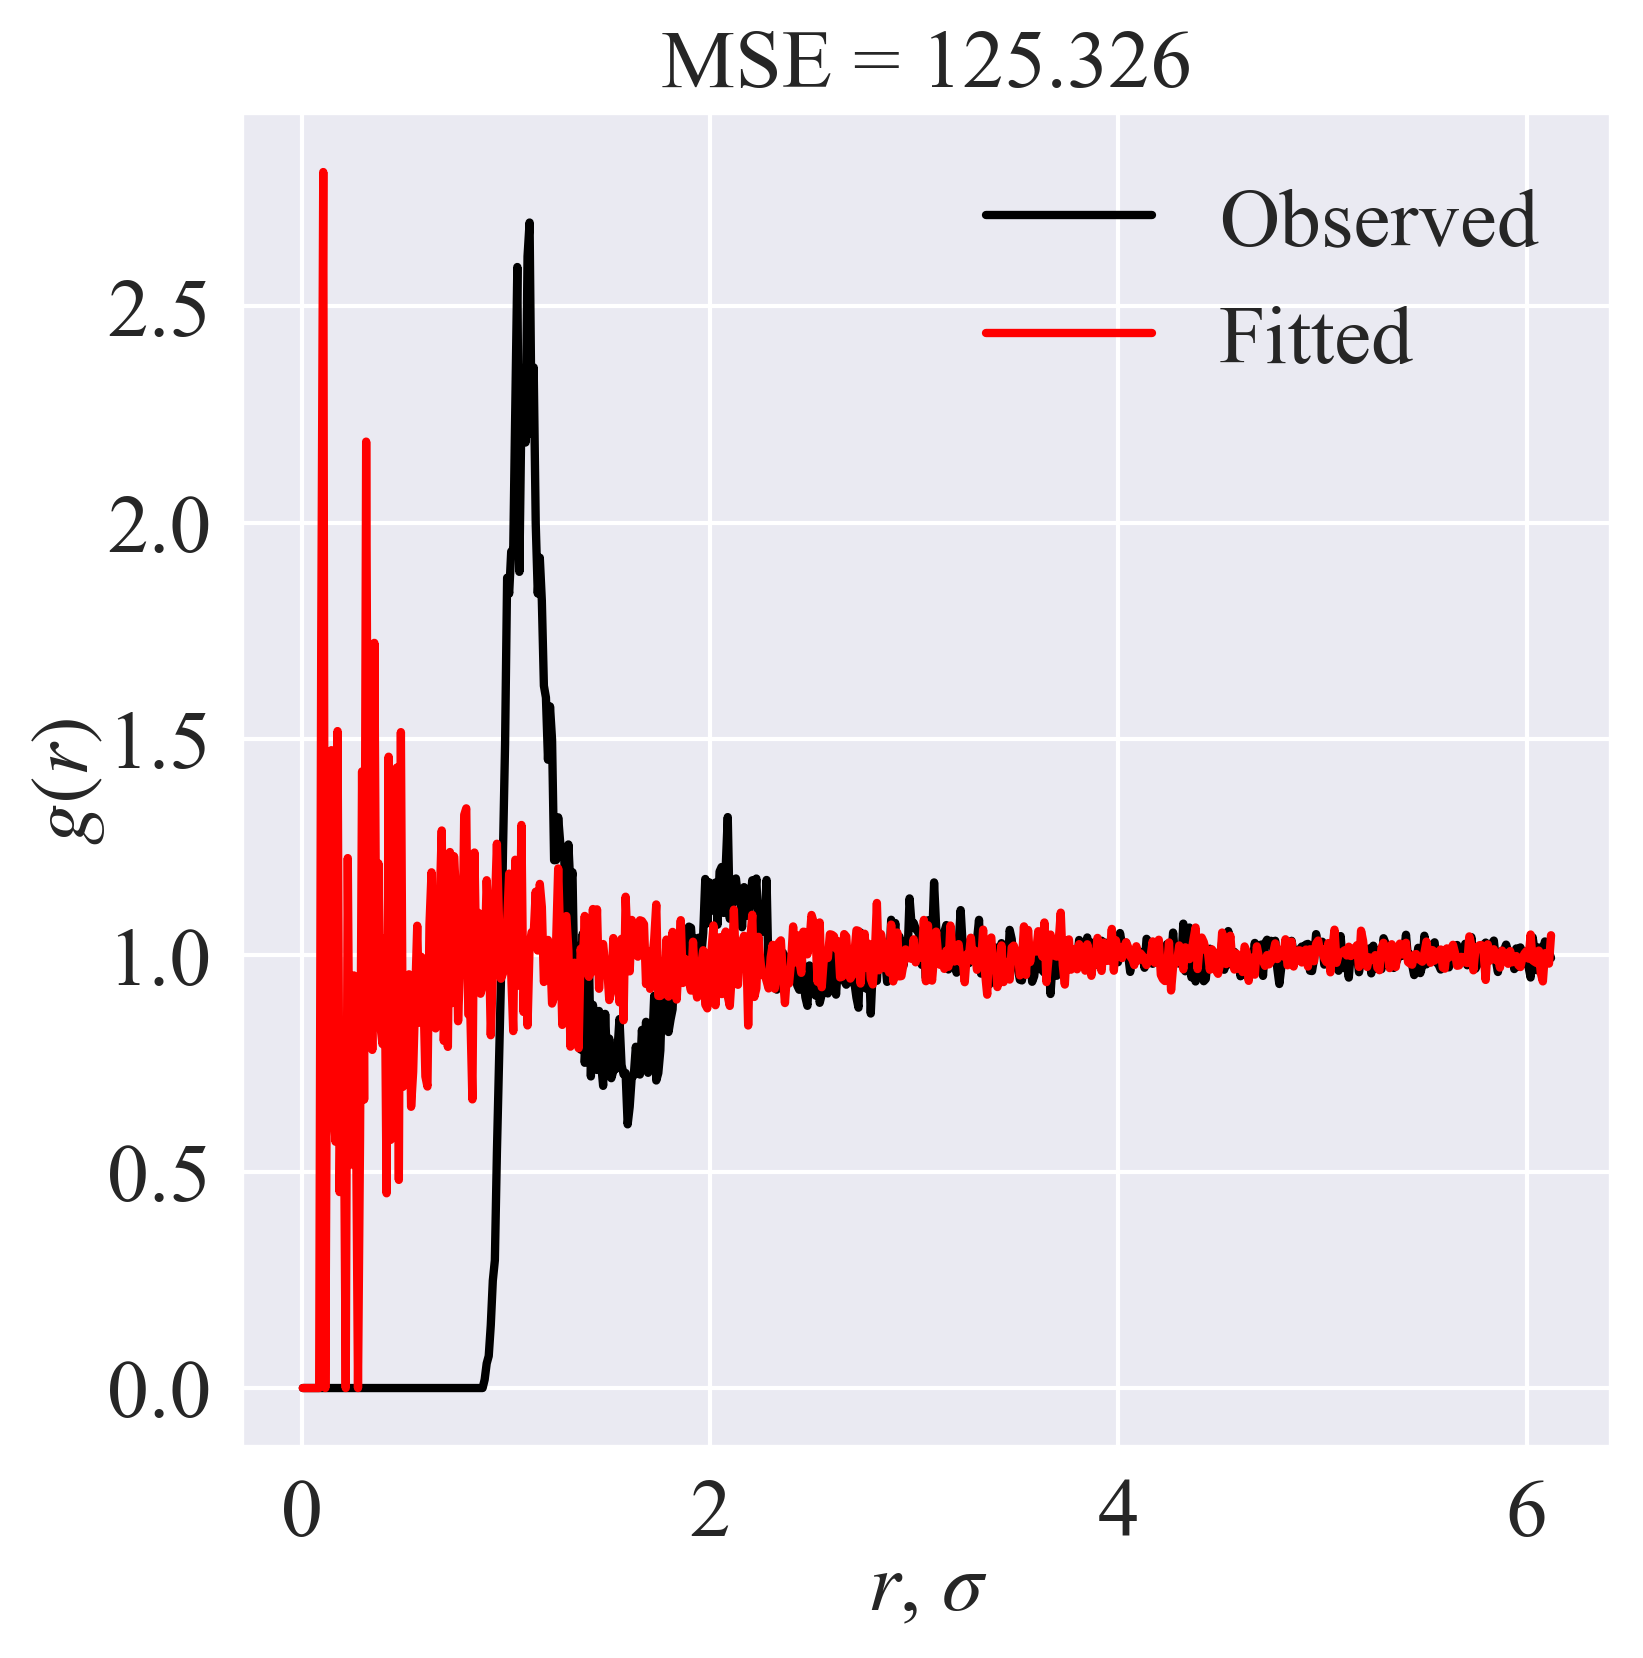

In [13]:
radii, exp_rdf = calculate_rdf(np.array(some_positions))
size = obs_rdf.size
radii = radii[:size]
exp_rdf = exp_rdf[:size]

plotter = Plotter(
    path_to_plots=PATH_TO_PLOTS,
    labels=('radius', 'rdf'),
)
plotter.ax.plot(radii, obs_rdf, color='black', label='Observed')
plotter.ax.plot(radii, exp_rdf, color='red', label='Fitted')
plotter.set_title(f'MSE = {mse(obs=obs_rdf, exp=exp_rdf):.3f}')
plotter.get_legend()
plotter.save_plot('initial_state_local.png')
plt.show()

In [14]:
cell_dimensions = np.ones(3) * 12.25

In [22]:
def optimized_func(positions):
    collided_number = 0
    positions = positions.reshape(1372, 3)
    radii, exp_rdf = calculate_rdf(positions)
    size = obs_rdf.size
    radii = radii[:size]
    exp_rdf = exp_rdf[:size]
    if np.where(exp_rdf > 0)[0][0] < np.where(obs_rdf > 0)[0][0]:
        collided_number = exp_rdf[np.where(exp_rdf > 0)[0]].sum()
    result = mse(obs=obs_rdf, exp=exp_rdf)
    print(result, collided_number)
    return result

In [23]:
new_positions = differential_evolution(
    func=optimized_func,
    bounds=[(-6.125, 6.125) for _ in range(1372 * 3)]
).x

142.10816030689517 605.8139432683847
146.88145904349736 607.8966327006918
159.03704962170602 612.9640661354736
165.6597216683379 615.0143717074313
145.42293428212227 606.4363772676136
147.07275427027875 606.6813209917104
206.90828050241194 621.1095996175563
297.1498123595955 617.8207910982774
139.00251089182277 603.3823481569996
136.1805570918638 606.2574565847443
144.8009870409248 605.203284593817
152.63421242687505 608.8932805951202
186.81151711745446 609.8026675831313
124.9985388753388 597.9056495833803
132.7129263150946 601.0482505280846
232.01347573132847 619.7951709421286
198.83530724846432 611.2510977765728
135.87333500796495 603.1198454757769
119.28851250545168 601.9925072004792
152.39185926840656 609.7755110230994
311.1480877037579 619.1420709249954
134.41102775414598 605.2522847925469
170.85713298266725 612.3665772709957
154.26355626144394 610.5695893691118
386.93931375681444 631.4308821656566
372.7535225145706 621.9206401116164
326.8724057929234 622.9684237302581
142.3553523

156.02561743690836 608.4415659472721
155.58009395478786 609.7897577900884
124.39150129783705 599.7408578457216
140.7675794194673 604.269526713008
157.9867599537198 606.9419893716179
138.60955896041324 604.9466860082124
132.62541423925043 601.1893301110127
155.11693914795 607.8803859293442
126.97010928664089 600.0262432809897
154.94419941803457 609.9678068608296
137.82215474407772 607.4778160093708
181.07065397146 613.9217005661586
203.54361390402852 613.3024693196344
207.69921627275957 615.6102629918124
254.62072783860302 631.5172615371384
4543.533828419556 669.3029235943443
130.91369555016993 603.7334555731054
156.85371343626596 608.2263184131258
752.7151666297851 633.8870616922278
192.0575050737361 609.0198875524916
144.09740267547926 601.7104631659508
157.5990725199091 611.8524916583524
122.5215651674175 599.0798572274443
147.8898290099121 610.2814529072912
196.80431655776312 609.8720186517396
141.89487280437064 607.9945307437317
833.6491496945125 633.9445495953564
244.8213932675388

126.87606349396918 602.6365937989237
160.77713948072724 607.8573119248676
200.0527536835522 612.235877241586
158.7856708124015 606.0912263583375
163.4575727393524 609.8314149344955
207.13872976777918 618.4772335073015
146.77627879061657 605.1211307481
145.72769781107021 609.8075937107562
127.75097129084176 603.6740160075761
126.9833108680404 597.9977783043037
141.4986823923204 608.2185302949144
733.8691779592845 629.5314088046348
132.8417308642845 602.1890089576672
170.68167016947757 609.5478806525123
222.55204295163188 617.3931333958134
132.90503884953495 605.05345497187
173.03084177388973 610.3938653163744
137.30805693939595 608.0866946748578
188.47271230078098 610.2257107298608
128.43991165723216 604.2274064148671
138.87977487883583 603.3495526803601
144.04592108076497 608.8338722134552
231.49885041501034 618.4968604260245
138.480109034337 603.5182884095325
207.62999382017668 612.9522097740867
133.76366029846224 606.3462517128721
326.52224980743557 619.5916739469219
339.509318842891

271.9859189415162 607.1970106065321
140.75599718997677 603.9458614401813
117.65313206728374 599.0441433001716
154.18758132896053 605.0868537529824
303.44165752509844 620.3677493859655
141.45687865077963 607.9200621172115
166.75112862983042 605.2062763704612
121.67943528193337 599.2873822680342
212.13771443189228 620.4613166265508
123.1213783247998 597.217158653353
156.14365484548833 608.7332220005223
146.63299421215882 607.9940783270206
744.0308713182649 633.4888456661881
291.0285270496272 617.9116050490906
124.52165040666337 603.3047421045342
155.0987587166687 603.0983599187095
150.8902724608239 604.8225309612934
131.2554710954362 606.6382196279895
140.97871896772295 608.6045488570248
213.72238895010452 614.9330286755054
155.74573189622615 611.846071906832
158.5531584946442 608.2551049120505
134.80069575212224 599.2671941395581
136.65117628809128 604.1653105062599
149.995885053128 611.2365961373434
320.32455211374275 619.7895576081119
158.6468873006034 609.8965583083434
294.2289712917

136.9609220316436 606.7422141404377
147.85283566524296 605.2526908310043
135.72593977543698 605.9431606599596
155.31860623552623 611.3247206918743
157.18770160172025 607.407835420611
117.06462429482964 596.6211161770236
137.5852173362628 608.9788646287323
181.1967175599184 617.428682839196
298.30425074949176 621.1458231158665
405.114397878144 640.8504997986208
126.6710674678831 597.6044052495236
154.3554391829417 606.3102849268097
165.40866890119383 611.3878144851041
224.23717782664858 618.0274333620798
141.27500057717668 604.9828606664323
137.96987384390772 602.8760903877362
135.06570725845378 604.6652560364892
304.81862221835814 617.1635725940425
130.17407597498683 599.827275211916
156.89712439504643 605.6644502752715
137.13421610571197 605.9471371990456
139.7489564636608 603.948972627092
221.69290427686857 620.9421813082218
194.23781263695324 614.573261009838
133.44341014849718 605.3139498500625
286.19573066344145 614.9598021235895
146.46011269693926 610.0025742351595
355.9882587799

134.6616437152251 603.3372503966983
121.86137506103083 597.1186316346516
393.09443449951794 636.4786243357528
150.47710377568967 604.5844505747446
144.26139592874628 609.685950387794
170.1836107649124 615.720002847978
190.62778370050896 611.4223975753437
188.3998900142243 609.369709844964
164.58518251108185 609.9284904083404
161.82006706594694 614.2743297533833
130.13226035119862 601.7905497326021
145.13088924638862 604.3397378889547
126.87717307093573 601.7584796046722
124.1759009455973 599.7923028181654
165.05938253903352 606.6388837733277
144.01222798187123 606.0899019122585
174.34473129966605 608.6875439349377
233.75110357375408 618.170979906153
130.33239327653817 601.4776123101682
225.08239885073883 617.0302500987643
118.63489194079077 597.8470849559167
142.8004190196616 608.8914837020131
113.93987202327305 598.0716879352523
141.60389990021918 606.5726713164463
177.46069258521936 612.3798324475329
141.5807325249472 603.3252409353963
156.6760678801443 611.8633332807465
144.96546639

145.16595837349476 607.6770605035908
152.2072837055536 608.9305981657842
134.76816143496896 604.8558239759516
132.20945449128402 604.90515208391
122.7533757401904 597.5847501572666
734.0783028389417 626.78853840071
125.89299603306172 599.4820816808707
117.1281474778644 600.2715258768085
152.01750552172473 604.3944637021756
130.80777627571086 603.7246870162815
198.04128078509683 612.1656528260646
161.81564948047435 613.35389827107
171.19988340194067 608.0373447644128
127.97436797549557 601.263200263345
121.8256122020974 599.2571005945797
139.70290734140497 605.1675410040149
234.76565803718498 622.2283800788302
404.92447710326155 632.0431570947945
174.23499082288032 604.0034531742099
159.8851067598288 607.3470365703427
148.05940897309682 603.137971948453
167.87197729530465 606.86773676955
199.56002722380973 617.9817947697513
135.74128083497308 602.1105543694832
140.27039787355434 603.8516653040128
155.1036846794558 610.5511617844508
118.25416384538711 598.3800581708721
152.56333233129348

167.2756706463608 616.4313462356952
166.4668940198055 610.8296916769191
350.0546990413711 627.002043444695
135.52251386732422 603.083654075173
147.59021204958054 607.42627386564
273.50507183661216 626.1940986393688
164.20867122938245 610.6440156443111
160.48606982046536 606.7122200249062
156.05710478660157 609.2850764825234
143.9500019938579 607.4389485098078
135.5437695094781 602.5950678175943
147.21393500075916 607.4380584693345
136.0846283146056 603.8919487503788
138.07784841011932 606.7151286803562
126.32420148407414 601.2561190971861
131.76894813957392 603.7235505060166
193.24218713972905 608.1849834910472
279.89224942667596 612.658453331864
122.2553087512208 598.9780520287962
4707.924264231538 682.6876001620128
154.84778021085452 605.3853354239549
294.2044696404065 616.3411164409251
194.29162824425805 617.2725138759399
139.9357891243068 604.4273674269012
118.50019329362358 599.077156596738
330.81217744241906 621.8122273516889
302.92140480856034 619.4794185225982
156.3995206151930

149.9571127030533 605.3417666068972
137.4233463390511 604.1157023363164
133.85010258051244 604.4204834404426
141.94629907418016 603.7319763568975
761.0863083930275 635.1306028466204
132.27178019178325 604.913359323062
164.76787279444181 608.0069924775479
141.52669492727162 599.4978894470964
134.97424113364102 605.8153780477296
274.18761864264053 609.2405541697327
346.14079535028924 628.0693679677261
150.77740481450098 602.4502807081884
201.69339237732027 618.1482477959601
161.68266515304416 608.1462394001785
157.2318838834925 611.0908181454093
149.857011533941 606.8064491545645
357.11283702803223 631.3469663171485
131.99137662967223 602.2380263325268
166.33036713218894 611.6030652379468
148.12175538064523 608.3137051499928
142.95351319822493 602.8007407884294
133.63929389527453 603.5321480779869
132.52404406714217 601.2944115906898
147.81006891695765 607.4561182848929
232.89502619232238 625.2898180365138
166.0178599012879 611.3123715558105
159.97276522784705 605.4684170127455
170.32034

175.36491618227805 614.6356007680079
119.06157661051056 596.916885238918
168.16056928065245 613.4149104788451
233.19609979997085 618.1420780340832
171.0791976344061 607.0138624784986
318.26922547933907 622.1403534505321
121.54152839205716 596.0620147219574
126.5189928442098 599.5490216371527
146.41872655120804 606.7946520194785
139.2795812382413 607.3171344043316
150.7345358196321 601.7334337654565
140.3264119561936 605.4555305340685
220.4664613459842 615.5683060351023
131.98531280677705 599.7624514843976
184.56322306579938 622.2888057534242
147.66812814427763 605.5937098012095
245.51828593137986 612.0299723202991
230.9643323020786 620.609356097078
154.69076472926716 609.4984936934809
153.66964121069654 614.2061299590949
143.32784853279745 605.5927080061281
180.07837253163257 616.1418539023207
136.12192380840835 602.7428719206134
141.6994600390719 607.6554627437627
177.08683289080662 608.4173417747348
155.8420249232591 608.1509497469008
142.17455499318675 603.8517707219178
133.08433998

117.63355625029973 596.2003520640656
138.37796409210657 603.0606726447388
117.32476277955926 598.5866796591988
183.20797099601094 613.4089495871333
127.35019519959953 602.82302879036
129.95084095142718 600.2584450432182
122.71436462997328 600.1363581637994
188.57061004103858 619.9704419615755
159.23898773668554 612.0940533853742
154.48763909888254 607.2220766895817
4559.106817015865 671.2444735414765
236.5563231806954 621.0943038744264
122.77734011007234 598.2672801852035
126.23691974542345 603.4703046819932
301.5348594520199 621.1731753859599
164.09255962678355 610.3769569626651
139.19862568575857 606.671465312257
159.27722244638454 614.961694439834
385.1557123415716 633.1753593327846
138.18949185158652 603.1897119003373
142.125207109534 601.0402634460424
124.71858142310535 600.3849587194941
162.0914902880746 613.844392186541
129.8344038615962 601.2393515449746
128.81891578233197 601.9901150104113
130.21486998633483 601.6482391612344
194.2446783370231 612.2778661369879
121.31161179864

159.28494448817463 609.3641449614204
169.46438908835827 611.6458350502296
178.69856934131596 614.71528246931
134.63470689270713 603.2252318115246
136.7064111166563 603.0124950459337
135.61799191559416 603.6303917424668
127.94848023964803 597.3894041003553
203.93747936367694 612.7210200541948
190.05885495666217 615.0295291728091
255.80030473190396 623.7011194856127
133.7065315239122 604.3618358824754
143.43668027270922 608.6032484719664
159.08913253550182 605.5180609123544
182.56369585538476 612.1294026057273
149.1026427860761 603.9317227494876
137.3197320154288 604.587878178809
139.2241460754884 603.9019106442935
136.33371254849513 608.501882013127
136.4084348496504 605.3668193865894
176.91306990251155 610.875452401769
158.48320788777633 605.8734488032903
368.0015671369201 628.7127869680537
141.04036481677474 603.3184364141414
132.2071663972633 598.8166153011744
146.4413960855454 608.2400641487045
226.41207707907728 621.182450315122
122.09176033195503 600.9681103070442
122.690812292923

157.56041988506382 612.5961430538865
137.0154468465946 602.7198895678526
767.1763472032454 635.8166058538865
172.06867682181124 611.7973299135558
117.28643715020618 599.6502378073001
185.07449149227043 614.8809619407283
133.89069748028936 602.1180568732798
128.05096236483814 602.6458562332589
187.16288152686067 613.6041421728553
167.4104175324687 610.4503380226761
159.8244243369312 611.7596248713427
124.371553897336 601.2153166716716
153.3892195696519 608.9450266246635
147.09486005734803 610.7099821089773
143.47020896244584 605.6365016039905
124.54374566277656 599.0106765738617
131.5501842145597 601.2522325473794
140.65189858691036 605.2471769535255
293.57389954771025 613.6595861570398
142.7672470842071 604.3234284857913
139.32010424152548 600.9914350491651
133.85229591441473 603.6579705993206
133.05854599825335 605.5883697931347
370.8720824240985 635.4047101674382
131.43977495809725 602.2049834472589
137.30381326143242 602.7505310034483
149.18157495097296 609.7605711187501
200.2258115

125.76681331831055 600.0654542022867
305.1509183891984 620.2156773939828
132.3478967100306 605.6057712307776
227.66741013166916 620.149011467466
159.11070075896583 610.3687594167941
134.3017750567547 603.4780171285408
299.80483945999725 620.7282486850272
141.79158814086912 607.5958185444738
179.2828784613764 616.3195459165461
215.2283764740733 618.5009346825699
190.0985607521738 611.4868425546
156.60494112451283 606.7959217975684
154.2665924218827 609.1586749422386
159.4023338834827 608.746851579993
141.269363645356 604.8496867270303
126.39363269645716 599.3307803187365
130.8912296645886 603.7968479029371
341.70834550006 623.2854714158982
129.3670256959189 602.351514318502
138.07884863456235 604.3588992114771
159.34803815062227 611.3090490171722
131.00510889052848 600.8304014759532
188.31770088749917 609.6419719765893
165.755695182132 610.9228181752133
132.73038350741598 605.3731695883674
209.7792021607504 613.9179812900443
163.82463331285177 612.2344987271068
138.21250270380324 605.80

132.12193947830824 600.8644110267508
123.12856248563727 601.2648716751182
168.33818878094277 609.2156163154793
148.09350869573518 609.6009080333347
220.5768869982131 613.654175762108
137.9144350950638 606.4832072556229
229.05804959574544 621.3784135100934
125.76762489644376 599.555958259627
220.13382856958853 619.9280135146157
177.30281788756636 618.0208183948554
4539.1193101509625 666.2482284292821
123.49624312992843 597.7824433526457
147.51359178458327 605.2286807693599
146.72288756079107 607.8310042825534
139.16130696496901 601.2732116579673
136.86126465129811 606.3244900765937
144.28259683679767 606.7641767506394
178.69677985585955 605.8676896035698
152.82627562391352 605.7524589982521
131.29700188883382 603.906803712855
147.90111301728004 609.6095288934227
177.49102065740382 609.5278569169151
4537.530396532541 665.3692023028607
156.34294418210663 611.489902885741
161.01615794385464 613.9027165588304
125.70188936399899 598.0492138976576
158.1383145007906 608.8626764771111
150.22227

134.70784085353986 604.8736313402808
141.7521765711193 608.9247210206825
167.71572838598365 606.3939749885933
152.05089966756742 609.5047402166904
188.2714369110895 610.3106563304998
148.78773312886685 605.6573258312765
153.33885819021128 612.9338725415205
130.89659933994787 601.954021354428
153.96985095084528 611.5272114724363
295.7964042378815 614.4108203749436
139.04948053844222 604.1599436220658
156.9257783785412 608.0089673801244
147.34937607712837 609.7926881031873
763.5297180245204 631.3012555951246
150.98450770682436 605.5833135557784
155.62143525875123 610.7171184754147
128.51899654080137 599.5735129571085
131.59187783717218 600.341110381735
137.65432073480454 601.6326603285742
155.1258180019707 612.1487636529499
121.98401131877971 600.054605912047
226.59568297927524 619.0011344920833
164.25404232509666 612.4038672263902
151.34988476839658 610.0227903386849
290.166923950537 617.8573909756752
232.49957746048176 621.6981072983566
169.9093778963671 614.1415063958901
135.484049491

322.5845719212963 624.1609580518133
147.503197486153 611.5567708875603
4588.371547507471 671.3168072362292
152.96806403672844 611.8208792245616
151.6346968984903 609.3833520146515
126.40329185009314 600.9310347342509
227.58576187150905 621.109368465402
386.334349401334 631.4037777922003
144.76031464331402 606.7992786900766
165.12491265413743 609.4690448728325
200.6145893729081 619.6721103174756
280.5985260490919 612.3074431734259
160.4489025081816 608.391994020657
121.62594879807604 600.4963480401354
132.38550736792075 602.7963230746146
136.91673651836166 602.1812409699427
288.57773368885114 615.0318813469098
162.985140640694 610.5422108184674
136.17511278218186 602.791715619616
150.37683532242065 604.6671070238522
144.00291527169927 605.1252578245915
786.0048376712405 635.7872636621341
124.92114209203028 599.6046425712095
146.91827946125676 613.5581167175459
115.13370548870058 597.2750729370929
297.1309383032694 618.5766615304835
150.06181773023624 604.0756894237859
152.15551024077342

129.06003766635337 601.6665276844101
130.4239877605328 602.2155649283072
154.6042071027232 610.1834276131295
127.26280603362946 600.7952314250593
143.31331292469218 603.9529150135317
125.63393503673802 601.722344641415
123.3274834032909 602.1821561633307
125.75999876704881 600.3745564110324
161.14487088268314 608.0219786134055
121.85956985056231 599.3603604835049
217.97651189451898 618.3492635766172
142.87455582312813 603.5889215955035
148.37622171193385 604.8344491188345
149.44720508813108 602.2298241637975
144.414594794058 598.2150071229181
125.75916302237292 602.3171498460265
296.6214407763846 616.5257677336695
165.87445917215618 612.8469648980732
127.4236053906014 603.1546601837597
123.95299005488046 600.8084196931311
326.90935052056386 627.7365996619252
137.2975511343141 602.0720417059265
186.37335519801152 615.3207853676237
155.17015130366798 609.2833842208927
150.59408764015464 604.7336764904246
137.04533430439034 602.1385337739265
159.28004455978467 609.7395275784332
168.972863

134.98369496832206 600.2430606923482
132.77184318776227 601.9609219939309
121.78300899194348 599.6180941281168
142.4314603144149 604.8336921382465
381.62047598107495 621.9215069113834
148.73831548940134 607.9107478175108
154.1876354989931 605.0262801585708
151.62786793665722 609.5625894313459
216.59910038353428 617.4113268541848
725.5489131927774 629.6523264724783
797.8110035348354 638.2354210181426
146.64675533327764 610.406673658382
234.95989537305343 622.4600468316717
166.46698091875422 608.2145084621025
724.5901608152692 625.7777584267247
185.09720813302982 609.3713668031223
177.72040568082247 615.4702514527346
199.67001044377633 612.2406846485483
148.02164370108264 611.8260030479518
134.91954629336095 605.7741738439385
137.5530380720181 606.1940698899875
166.33324008963896 611.1003591698103
136.67795489405336 603.341256736116
137.71523500075102 600.9966143143704
148.82388201415486 609.509792689973
142.07440991915473 606.3943034912004
791.3454292373917 633.4546486339452
114.5684787

220.4112392038615 609.9789579268519
153.21907024967712 611.0950872162364
208.1966044891009 611.5624619129422
154.06260167913533 609.927398758829
157.411360425266 608.3653961654499
153.99421138271478 606.5904274492677
157.0998564996099 606.1137766053595
164.17165100206094 608.838837118304
174.86097983983643 611.8518352975618
154.19969055126688 607.9038609881015
132.3715553360156 601.2291971182719
156.0287637335868 610.758481362459
890.9173470581005 639.5111676047852
192.6098140403496 613.4047120212194
179.05420888214655 612.5619915849429
135.44612945288392 602.8774543066174
734.4367224553663 632.3328990219675
155.15179713970508 609.105273764684
192.68551700098527 610.6671648205473
163.32925452415617 609.2688478455201
737.9634647963034 631.6064459817386
158.50719766747412 607.8951305308536
129.51371564637387 601.3629966377548
296.4943274710135 616.6742610577951
197.81904050944178 609.0824826806831
210.32258280447797 614.7120853745639
134.84645682496404 602.7525135326704
153.1439705135665

193.56448997740745 614.5182915751466
118.75784840432958 597.1144258226166
149.77922651258697 607.4089341701003
130.21426121252722 600.1887825181988
145.44093951161668 605.7462507491299
146.3687414879052 608.1494103806554
826.6317249079608 640.754730015486
150.31536087183758 609.6617694114452
165.64271054441454 614.1608205396717
135.29586220892122 601.7434382970198
776.3898850072088 635.8256845903043
295.1959803650575 620.4048161104145
141.1856231858931 603.9951252035675
176.37179495438056 612.930728999827
179.06339154596625 605.6744887360002
299.8652608417051 617.6074328694622
142.714048257765 609.2674018585344
256.4330154273284 624.6765363925379
149.13588279718925 607.7836286395689
345.57945668171476 617.1075769774448
113.42095859926492 598.6968874959107
178.3669034152373 613.9657355246204
138.78594772365352 606.8258382071515
200.14903714263087 616.2209784970887
170.9973075490096 610.8099864366341
146.08823829706904 602.8412737807263
149.9081343633122 608.8751409866152
233.81952120186

772.6092272695145 627.6405679282043
143.91784147060855 609.8278291355184
161.0404796216101 606.6416707258853
118.02644360290248 596.1741292191005
160.1626356956511 609.6628085833601
144.1175675733758 607.6645291957233
149.66329518340385 604.6777991738463
127.39238598539774 601.4185419956491
162.63264318773165 614.0758724660215
151.74978825458396 606.7976287893015
177.394413803799 614.9462584051453
283.9946163903575 618.356380202405
143.5399026923712 605.9276810093298
136.21037094925725 605.2531500031548
155.61833064129482 611.8315834613846
731.6834659896014 625.3805767724762
171.5068858821571 604.3538939369116
187.85830141947392 610.3806831267468
140.0560971158831 606.1643779593722
171.19866481908943 615.0119066031803
174.69944217304501 616.1478747805859
185.71931090634945 608.1507137151223
4595.424749312817 682.8997547270695
123.76664210599867 599.3409416086704
137.2460698815485 607.8841352515072
167.242948815607 605.151468368777
188.34980083142722 616.9161721102131
128.5258321005586 

177.40033949821571 604.3130244060302
136.30787026358382 598.7145387679624
119.64262114874248 597.1428837891727
365.5448904220477 631.2386943179521
131.03433426987664 603.1103014429349
149.8061892637863 609.0497632240297
764.3724245001952 634.6219466656171
122.5840232116909 599.7928363729292
169.65175672092192 609.3961809942723
132.03810744738215 605.9899481436443
368.1074250475105 619.7209472752677
1375.069211269496 654.4914756188831
134.3481623397549 606.7194824467254
160.44367075903764 608.1390728908481
139.5076779038184 605.343485681526
177.04497414642142 608.353958782177
210.01396722354187 615.1216570345637
239.15241797625856 616.7778799441517
141.0731941879029 606.6769249774457
132.79211615019787 600.2693528042716
152.01209469999415 604.346292171638
718.4355892907377 623.1199614469467
197.8926924959493 612.3755084734144
192.49272052935467 617.8954349432281
169.4024363591605 610.3094638396824
287.3781413765242 615.2750677093068
156.60923391614782 605.2103317741031
133.0766159360025

328.4255512538621 629.2073783176394
120.64443124528776 598.5710573850131
738.6473724880713 626.8378455676789
123.04592243686562 599.9237310760739
149.2640212585639 609.0033427657436
139.67311142218324 605.0306492055254
147.64697078907062 606.748301654395
142.8077215478738 606.6934261469801
122.45948221559763 600.6429102539396
139.925609961709 606.1196255577345
186.6564705097524 611.9264993484858
137.96754742575138 608.7764300058295
123.32264760537583 598.5968812338315
157.18837382562683 608.9796832099901
193.44166017218706 609.6216980200714
748.7463069332231 634.2056149531808
183.80186323757468 607.7602206495488
220.73385590404047 618.7520956406679
149.03208415934162 614.8241884059519
167.37805190542352 611.2570442502072
772.9434439449042 638.7403154512829
140.11631469600465 608.4922429971152
146.24258565610205 610.3775126146021
139.07943653980092 602.8015364494815
118.55234204654357 596.9476044771229
156.59595596689033 607.1388099039468
142.89418801034404 605.5077675540703
122.1749529

138.60403409390983 605.2027519321501
151.96030077716975 609.6996830477843
128.15366056625615 600.0458791304069
160.4586805174882 612.7741891910496
144.58471195927302 604.7886545112485
147.44679794527568 604.9618519187333
261.6820799383887 618.1911409420348
132.3197601205232 601.3085042429097
132.44487511810118 603.2076366920633
124.67123972344905 599.3232645285356
148.54614495355466 605.8373385434364
153.05459784162082 611.4535305093198
137.26962719207444 605.1706574162879
134.6754559923958 605.3427111245421
299.8483752955109 617.6075674603676
137.25204028070698 599.686075388091
205.05488333508472 616.4874379291426
151.98673190974674 614.8595094684206
137.60117985302074 606.9352844098732
145.98743471231532 606.8124839409202
133.64111349192285 602.7347904940896
134.8189158990725 603.7850079755372
134.5975158966154 602.9844083451924
159.50599597690422 611.2810025134922
124.872825483767 601.6677379323332
128.65903234655485 601.4194185886845
243.83771017262822 615.4044918050984
206.2856769

143.65575274878947 607.696015619318
205.93690718860836 613.4827447916492
136.94468099447616 605.1863172930684
183.07928119521983 613.2639161878823
137.79612172864947 606.1024055222268
139.5679405737123 602.9038956278768
191.42975052572302 611.378242685395
372.1400530228854 618.1699151934184
359.20701234836616 614.9937709502506
196.1361802232623 613.469232367607
159.5192053270165 613.2890840211555
762.8774123709728 627.333270861053
132.35048530420062 600.3771707527621
319.1627506587828 619.7659330577544
192.52001239917993 611.0803371192918
310.5631973119077 621.0634116269146
180.39023746103504 618.276260090174
130.7345632347124 602.2481562966004
132.41319129185456 605.6575836208783
731.4650733164203 626.6234495998334
201.09884575635223 611.4892741697156
337.08721249750613 624.3927322057004
295.9684442711244 616.9910932964486
132.47888804603338 599.7001167835667
117.40473441087002 599.250964961908
147.6505795388522 607.4807259952049
141.4123623977244 601.2086263603474
126.76494082251857 

136.14531624715403 597.9211340105442
163.27251242129788 614.3383169565491
138.99395959337426 604.2432175248059
149.23946500116725 606.975439041189
4709.2677747432235 682.5184387434233
149.0293017219213 608.4772212413199
159.62339566762503 608.4048797388185
148.70620654962542 610.1819197958791
157.00567280108763 609.9588638080074
158.07847624966803 606.900538391674
168.42782739253386 613.1770353209852
744.2109170304607 631.0757950886905
118.21311244797191 600.6899282196598
139.38967497821753 607.6130398429063
143.65744470638668 609.0657517527621
161.33524089971917 612.4839772847556
149.38818933143492 607.1173708716444
142.75413023488514 607.0742146836691
139.37776429658118 605.0379024660807
149.27452051144684 605.7432312567446
176.28558189137868 605.7620592786059
190.28030829758134 611.7178617042623
153.2199882476279 609.216960472173
122.31814011845938 602.2086434332718
142.66440914426707 611.880455915224
134.22612333573016 605.5779039406581
127.14679246686731 600.5571136048659
151.1751

149.33263149486032 603.6737800665002
121.05039419365436 597.7018957383482
308.3988992391488 621.1342231136377
146.42512653089727 606.2075554643656
225.0051130214246 606.9250539501213
278.05275757499203 611.0173184537484
157.98276497612727 605.8589306503276
121.50543541113659 598.7258305328907
132.5988155795943 600.6812627977499
136.14435828595816 599.8509098208831
118.95064277871384 599.8923466202783
191.53199120480585 614.7191813947946
146.88633170744075 608.642613835847
152.24647849377843 604.9818131066475
130.99437276700027 601.1596845955
732.286505509493 623.8579088831273
145.76001310406946 605.8895333021185
148.42191011827038 609.6078536924266
156.61781554497705 605.97254819369
134.34744120905887 604.6115322921129
170.12227167564362 610.6514575596628
149.49147220764084 603.01788580982
214.66860248750714 618.2437259395265
129.8135937893601 602.351337887073
258.3946055109866 620.234319151255
147.84900593703586 608.0805243351319
158.70748433109864 609.8414104917379
130.1648430296292 

134.90207890867515 602.4235934355451
238.00272788080008 613.1813699024335
233.99971833636155 615.85934095316
143.34673394204512 607.8586306687474
167.19992577066324 609.4720912314469
140.2443165457925 601.5424911943622
136.41148619100767 603.4914506422648
163.01165653221716 608.754558528309
328.9738812151282 625.8182618990056
368.9651163976404 629.2660466486573
138.86765687233066 605.3944169120184
157.56797817875378 607.3716833741092
135.35400696263127 605.6631213565133
195.28548841638357 611.2554366781062
152.96148568386457 609.3670788900556
213.07325812586072 619.5119921937826
126.82674763363327 603.2978421752442
165.79915641021148 608.9234483441555
132.57798020672269 603.8936826083216
144.15073245793795 603.7580944991009
289.3807165556677 613.4868005467808
4539.006285715679 665.7247966959637
290.872729285562 617.4729729646122
151.00528200640105 608.0464339993002
110.82197942975144 593.4539767623264
120.86132741055901 595.957591902953
209.49529936871576 618.478059313114
142.838014423

363.11664690636906 617.8818567508182
133.616983433651 604.5864264513706
122.9338246550189 599.3288007215388
132.83676645136205 604.1756498915782
312.69131221521616 622.5703524244942
844.3841709512403 642.418525679152
902.7536892996637 648.9463097931567
212.5480102507009 603.031736281588
127.28676193480219 606.5659495626819
133.88540972229814 603.9979144252743
320.07296890590163 620.5250778130991
123.68487518671247 600.4834999740781
182.5538313850991 604.9182080919943
210.90989950514734 614.5137830855956
193.64053617054603 619.8512925050936
160.61761251151486 610.0728696891758
204.9108223464304 616.1940152902819
157.99467240616795 612.7155931394029
128.3107392969272 605.0717693670038
162.09465487285465 607.7199511637983
177.61754951997403 616.2238343190816
176.6524445471544 608.9692159150634
187.04034225618952 609.4670441308895
129.04800555113368 601.1280402918195
173.48670144367205 617.7061022385192
165.6061579106951 610.7942473184792
141.18097778875156 606.9865831718691
211.3788292771

251.57249659678868 617.0558323258481
168.96725247270777 613.0854187258036
124.59314779384813 597.0451363882881
190.74786639448917 619.2723143195764
4601.167951315354 671.3769476426332
198.03383074751454 610.6124048976192
154.66078298762332 609.1297999373859
403.4420011476477 626.1907005704029
147.48213619337358 606.1136184424931
662.8923325445613 629.0003656791993
307.60110503618 622.4019330202032
133.97173850283946 606.3725600164324
138.06750110269363 606.7161285019574
164.2927943432879 606.5646873823634
146.7122609208212 601.7723794945914
218.95469603214895 616.1162888633758
122.23890762082851 599.5363160137787
152.2510760722106 606.8604986987771
182.55456375277373 608.8147918468821
132.06169418723462 602.0471623048024
194.32127904262475 613.5395631052397
798.7712962606347 645.5573218140507
214.3749807748823 615.7810538678127
178.14086759323112 614.6544610586177
128.34686071312183 602.1998271853276
164.9181278516052 614.025028296473
155.2849811292452 609.9891948288791
127.98888127391

142.5494247153051 606.6462535684366
143.97026749537432 607.4656626185606
179.6787930603975 607.4141317175277
144.42827341697455 606.9051878627286
144.76421550526612 608.6335826773573
190.25703843243332 615.9864349675454
152.327656675517 604.2353729478618
155.64848738963113 609.2503869861661
125.46084038159944 601.9536111758
143.9475324267073 602.7404945490367
237.05552751024254 613.3115298520429
125.09138552260349 601.3298260720503
165.8745091595576 611.9183026233723
217.70439863421282 609.1839683398962
149.78737878385354 608.2395264336362
162.71264981161872 608.3253511106841
151.82526957558656 601.9568873368859
196.7799062072356 617.1737375755874
198.05914174682152 618.0566242568798
122.18504715506269 597.9767081381528
155.17200797696302 612.0623509752203
138.83861905387488 600.6424744261021
141.970208939043 604.9340741018816
151.2532366272814 604.7381501559164
128.71925256794907 599.6279969083737
138.66851412273508 602.983525400799
182.0716011326215 604.590365327477
297.6454161294106

124.11092443862759 598.5798817906352
310.933846383315 617.5581105385107
124.36760235536006 600.6915023826707
194.5592600476804 612.7466387888446
145.65889376582624 605.29982124085
231.96077033825162 614.7128564513566
199.81502869196225 619.5363275304853
134.30524490975492 605.1070569813639
123.77755755420291 599.2658227490974
297.95844769464696 619.0877784015616
121.45424440500216 598.3645680862338
133.01091834151728 603.5057222744174
284.9669441353507 616.5794485934516
280.74451434318405 624.6001890354039
128.92348134649643 599.265138524229
134.44495171480463 604.5256780768005
116.32415937342807 592.8974343323438
167.68410040290257 608.7967809762986
152.80868220779823 609.1525779786862
293.47698754337733 614.9541192511884
135.07107670503927 605.7670403255449
204.65377083632674 612.575950620594
142.04193290976977 602.7803230659077
4644.087488868561 675.3128968260664
142.25119897586404 601.3373976610953
148.8237102952965 607.3295213881299
161.65026495482564 607.7099268515328
168.5649290

147.84020056625582 605.3210545657929
136.68429026173524 607.0102295988912
170.53471632797408 599.4521404384367
162.8980364186703 610.8407865995143
132.11619728482 604.2352986866226
148.93108257807413 608.0441353427062
925.1788467730148 652.34259178328
132.55710986810595 604.6290580560353
137.9988519771552 604.7867980231189
170.55208043334216 607.5250050445607
131.13119906812122 605.4931524485588
122.35525439091828 596.2624511634463
200.7517150760255 615.1413723244202
314.46129429484205 624.1685040348004
268.7124512931302 618.8133722151724
126.6749956654491 604.0295692257746
197.83412997748707 607.9522429891898
125.71313476838284 598.6684135573657
152.75660750845978 606.7498984232402
163.28584844997008 610.4079670985786
130.2404552340397 603.2031096426147
146.8213726109518 607.9835689188762
130.78675588711886 602.9194525158423
116.26314099245548 598.5824086749624
756.069695085129 630.659781191584
114.99955921446771 596.254758915482
347.9267101145864 626.8898652477502
152.16524526756874 

162.0499577424008 610.7982993111768
153.89069847396195 612.4409349147084
145.0600817275819 603.9542252039864
126.30185714284184 602.2294261731058
126.8120063412805 599.9676497564893
767.4685622639679 628.5746088607767
205.59359856781543 615.9717705403006
125.93902056086105 601.1993337662051
219.20259799131793 617.2664307708892
122.30912521801056 597.140738533165
163.46884610084635 607.5678262388298
136.9253187213887 606.4020839730285
192.02032048531123 611.8171753889799
190.4866229545532 612.3501657271078
161.96705391008646 608.1029819451901
888.4298569760966 639.6252223184724
120.0922855395098 598.2344174155612
183.04370891923853 611.1266546097611
757.8749538944619 625.0685649630769
143.28536837326632 606.6983703207244
131.8040122194929 603.8237492043195
282.6067675136341 609.6636761496213
216480.9788334034 1070.4365149000341
330.89135073997056 623.4365908012225
136.07309874576615 606.4341024377593
203.17071246168445 614.8909757451488
147.96304952574505 609.6274802703499
126.657353362

151.81995159797563 610.9970752235928
256.10747772003765 612.4911949304187
152.56057746632536 606.9983971614462
232.74742496488113 619.5821981715434
125.87531095891572 602.5437385059795
137.84974291582452 603.7877250628815
151.914692351371 604.2787038627754
184.83034935962317 618.948669921901
378.5089844749605 621.2689256721393
132.51450197607016 604.3629707125694
144.33742610952902 607.3014920952369
164.5933700605502 609.8499377367602
174.5537601924468 613.5957936264681
121.07879862377918 593.6782312116591
142.2963373022128 605.8080556293025
304.5573269225102 621.65734518148
298.1652560159338 617.1040356940329
202.1358848712306 616.342449258139
122.70486403308941 600.0108254183208
171.01378719585702 607.7321383060646
139.13664010351826 605.6026498921174
144.37400684584804 604.0309562854223
142.5651896270957 607.2692514586431
155.14932697013901 608.5148588715388
393.6142588749925 623.8202167674415
132.76016742421479 605.1175643922254
118.0412839745779 598.3248770397167
299.3666246802895

152.90858724062548 604.2031644648397
753.5090016166375 629.6728440642289
173.54340181376213 610.997465587001
200.14023557262237 619.4996051079688
211.80916652043396 613.1497627250076
154.46461622275956 610.385112872539
255.2985244952144 618.0877611749655
128.48747657516486 599.3671403739837
161.04176706526286 608.4006181660768
275.58748339715913 611.518358320062
154.6790475009607 605.6626725763774
291.1335612591606 616.1994971269924
160.67036914277182 608.6466973477479
152.8197001648177 612.4318347551234
122.99123211741751 601.3430244235765
120.59915788360324 597.7234075058751
135.8751352037067 601.4018162711706
118.86767152260386 596.3885738549216
304.06634241085123 622.1416588301158
156.430139138328 605.791329310289
137.1984349109946 606.6468052526901
128.39946526201206 601.8198767366866
144.27455052826224 606.9258449973039
163.7646777107093 606.8028327642152
757.0087477629655 632.5176279166592
296.4502400174971 617.6423372062773
325.5342802480585 627.1812665429627
742.5386823857003 

153.12235334804498 606.3305020799761
323.75961888608856 626.8487161751825
186.5756238210258 605.5837277874155
146.41556020687642 607.8847614240831
176.9934679877095 613.9893370776308
144.5264758398588 609.0177219617162
134.54398899285124 603.1278785064488
154.76067103370505 606.9052984105163
130.6847965483264 606.7144418661195
189.14299728222898 612.3205632796448
149.32846149442324 606.6513940772018
138.83781545652175 604.0830034103165
148.78852807275862 603.3947953266526
149.55287092521476 608.4321602340565
180.51580936860452 612.5683369386893
223.60339053959774 619.6891202933051
121.03498952785087 599.2860974809591
183.14256231400577 616.1526749244413
296.11593787540323 617.7955423963133
348.38295994572087 624.3575506554696
133.05207634984464 602.1519125320845
125.63756986182199 601.6432386427448
723.0862828881558 621.4998178753854
233.6861878115078 612.6386109601077
164.66604025872587 613.4972434694462
146.43325688453328 602.9368651704847
125.77763534977915 600.998727108673
161.8433

186.61543101327476 615.2071771299618
127.00299705262469 601.4119478785848
129.98033489238134 604.9324355495976
150.9633319666322 613.7882714523666
142.125359855537 604.5284967257194
131.07025210060894 600.7819354550361
131.790889325422 604.0576157466427
138.60275733013023 607.2628485536902
120.93204975175722 599.1561333893087
117.3574174410673 595.4594764470799
131.12057782633187 598.2865794703644
142.82778648956315 605.6244825775854
127.93678005531457 602.1087340348708
282.2302543717645 610.6805588534307
142.22175151560597 608.4232712901407
187.72677765523198 617.3147273705517
211.23466614337067 616.4833882427711
121.99441192699985 597.1507016989731
141.6698773921772 608.6978793347898
136.60672907638474 606.146811580275
156.03002250295756 610.1036538660668
152.07924547977342 606.3865478452601
148.0085174529001 610.018899903547
137.3182349455227 604.7919122418733
173.3676706288618 603.510395909833
127.41564215605918 598.8669566375547
135.77092860197538 605.1784523881254
140.08548883240

183.10671936823357 609.3154093617609
134.09382124057808 602.0271647849595
145.19107215782978 609.058078604811
216.60760249388815 616.3564124511108
198.99839516326008 613.7731847751672
190.15097264086828 611.375293829824
156.86396532021257 607.5041383005156
153.54304708343028 608.46850045705
142.71719464593758 601.7273414357769
155.03033151848564 605.9639212954131
145.92673778149157 604.1251012724146
4575.6182254155765 676.0671504581335
146.28392851741097 607.7647174073286
115.90718387888441 593.8125323730633
4533.778877020194 664.4453625256684
162.6737474644994 611.2846838746214
122.64375105157625 599.367917341006
383.20645320039176 619.4258380424253
152.4832372579089 607.6453023821488
155.59993646152552 608.453279819156
4575.375393496948 681.0645971651352
158.37978034083315 609.9522312640611
145.85457374226306 610.8768543131741
133.81123506694263 605.382070641507
140.39770441901075 604.2725565494785
320.5701117291711 623.2892950657017
189.6769924049216 611.050254038812
135.76222671866

152.47491769368085 606.9673697861596
117.19677745309053 598.8348291947295
123.66232405200626 601.1770551432285
313.8943737917377 619.9210583547763
162.87472131354056 608.9131300153367
152.78876144358668 612.6413510884852
194.89662091081203 614.4992183816946
172.10847309671948 608.7686853376933
149.6489546957494 607.2095443937801
742.5953604589388 632.7151081349668
178.87157305223565 616.7031156082284
175.29604803593065 610.8324452981622
175.00340053414052 604.2322201258196
190.8204596104334 607.1113226937982
305.33487509197204 620.6748246293071
125.97684568331532 597.0964500799519
194.65865432447308 612.440987331107
748.7652565953545 633.4763852198821
154.6451387207299 611.7775373592938
131.25443599852005 606.7741029012695
123.38485153094017 599.521936252676
163.13203302434718 609.1218636431138
173.6507947697247 604.3362277871081
117.14939391384192 595.3778059799383
255.94268294891162 621.1534587876857
145.77530482695633 604.4467290515413
147.82130299745262 606.9802684478975
157.269158

182.13967983397185 615.3040902664006
129.49580785775103 600.7647454068442
129.06860842670508 602.2324994656026
151.1489174851147 607.2169225048673
129.87388653203982 603.307878002678
183.607272014694 615.6827220918897
125.79703215680443 603.0985682557807
130.3754867722201 600.4668181042781
145.13250826530185 602.6108357305807
147.67176157027797 609.3698738613143
122.06466606545901 598.442629269037
136.28543868879586 604.5035977841986
156.55531884446958 609.9288135378271
139.53832048082327 606.3775083803789
143.81629273448232 609.3852155673542
145.06666895801283 607.4751189833704
215.8442283921729 618.841579202717
370.7691195977801 619.7340748794136
199.63739254326435 613.5291222782031
174.50856965623257 609.3724040392407
114.89155645960798 592.7984587827568
125.8926692731758 600.4827948800944
352.13565828543796 612.2391509111869
365.4929237581786 627.7371959568566
170.43287004649886 611.8553108576542
145.60644703731268 605.8905482071516
144.21343995099176 600.1495230165541
219.43978939

139.41307826874154 603.1831245448991
126.55376878525192 603.0552776648583
730.0549068502314 632.0693712651075
154.3871736374688 607.6897641697595
138.07457126459926 608.4420865615141
114.93152509743508 596.5509714379702
140.38895058910322 605.4771983063089
154.66932199757866 608.1111694238416
163.39835131086448 612.7991722267441
159.64436822900174 614.1472924993294
159.42483569487177 611.0538929363852
352.66194571528797 627.396583618053
147.73235579611256 605.4015226427014
167.57912590715137 612.4809305232351
145.49980546663065 605.521065215733
310.7308288374864 619.4638175160283
241.14064698366022 622.887830488193
209.50424618131737 613.8879848694555
267.2138927991899 631.8927916981551
127.87805364306573 601.922792396216
155.94793745369918 604.1382222292696
120.8225601914891 601.8285549790971
181.74549740268446 616.9473292418741
213.41675700147053 618.5933550437372
155.12317672938318 607.2079772999565
198.40860467292126 614.9343970637017
165.45459779164167 605.9190665653766
157.522242

157.73297370708104 607.4247923543044
121.97352463716702 601.0704920112224
115.42202803684005 598.7878656214764
145.17294515679504 605.2197576983393
121.6040117695475 595.2632563931777
753.4003205406638 633.6934163359922
131.15878194248066 601.1779267505642
173.76180480404005 610.972287675542
127.4583506757125 601.8884103489142
138.15426599282893 604.9197330808145
167.88065504048953 613.7988536228665
199.0148902070584 615.5089913304024
2605.0482930413764 665.5189915235851
159.72219322007385 607.1581276905736
205.584197739887 607.6694673566483
291.29782744286297 613.2620515531698
241.88755493687586 615.4485574376049
142.7161338373277 605.4580988131901
127.32235685159822 604.0995589742176
147.57952792929396 605.9731119040345
295.28607259730967 616.265227111213
113.3215320907294 597.695549297578
4534.2342321233 664.991435504134
821.8148088777643 639.9256310007241
140.52840779788608 604.3236964367237
161.41404098004818 611.1506157347885
132.37004108120874 601.6038450030896
4566.224993260328

129.42549920903215 603.7143708907026
123.35958990435714 601.4120960594769
153.2596311615223 606.0774254729412
132.61582417429946 603.433051188608
179.71900280652991 615.1088941922401
149.28521693182404 607.762703435322
140.86301755633787 604.8262348427643
136.3539982613437 604.3669631616597
134.73297138187579 601.944000195933
146.28324778413375 607.2229423754325
161.5604555054263 608.0594260097682
208.24112830832436 612.4908552908507
222.4096066604013 618.168229991789
162.16984041525404 607.613628274611
167.77662462780728 610.493319852527
152.60756426841596 610.7224300323021
116.59653763179419 595.0929846178992
154.26245758646698 607.8516927077108
188.13703104100495 609.9523403995847
2586.503330430774 655.9495354660419
195.13751995070808 612.7909639070441
391.0547059921844 625.6453333658469
140.75441150048735 603.2815617627301
137.01673317230757 605.383107321896
222.52973995452123 619.2417402026699
744.9526591352849 629.7920414394866
124.02901565040486 601.1917551004565
137.32481410485

330.54069005229866 628.0539621166615
174.88091351741875 615.3895022381264
177.59766315068964 606.0641591887941
340.5627947472722 622.8829887770364
145.30202576994583 606.2449862667944
140.0255722964924 602.8887952651764
172.11567812319996 611.2381147237561
160.32558427974806 616.3760886076975
777.5868196910617 636.8483978505833
4766.760382325031 673.4671449272444
165.3846490367412 605.3842859998031
193.43219798359723 613.6181829647429
324.7451249985479 620.476651731946
135.73201885865825 606.2838218739652
126.41394235681962 601.7237142615165
150.71520739603565 605.6390366235582
136.63295683596863 604.983974510359
952.8955096374663 648.1654429447971
232.88672742468506 612.9868112334077
182.17604860975467 605.6633672727971
124.83407437760377 600.8138627789331
181.49797849843756 613.241513913775
187.44629093889313 617.7729292643601
116.40651135044419 596.8195019066243
148.79359143628307 606.4625003790757
193.8737639979687 612.8929306561548
138.51157823425484 607.4807742664582
125.03415918

155.73967289892377 607.1301304969625
253.08605198373274 614.8148866770307
111.2405016579349 594.4914408633017
166.12337842252288 610.8301389735044
128.90420100633173 603.2568635334574
119.35674798046223 596.8581989880556
132.85814926590623 602.6996221739236
127.5671227848579 600.6484770914069
4566.047125193728 680.2309914957154
169.84542504945864 613.3367620044272
234.5584533871619 609.0068136252769
222.56793743415852 621.073088316268
282.93187511384906 612.1900644387495
266.77690826451277 626.5180433000028
123.7490760735303 600.5356121872197
341.3427203452915 624.2817660612457
165.684585202965 611.0169441320988
159.93046411570745 609.1959892726611
173.13179294709826 612.320380568482
124.52702782800701 598.4361465736384
136.3279473287156 603.902997571945
163.06183759137414 607.6242102623416
159.9288007358874 608.9439960933221
132.61359877814414 606.2660361107305
138.73409639886034 606.8379166834675
135.8570322130937 604.3155802764504
132.52330879002062 601.875318108509
148.820945362208

145.99993186143337 609.0903249135151
151.52291658940652 609.4704844843462
152.4173463784592 607.3527439692884
169.50357047146414 610.2219701446836
147.8265251396927 609.6510746479344
233.34203842032483 617.5516541582356
154.49200763597588 610.0828293927565
238.57580740628305 616.452148896866
127.51102516090711 603.7615891706287
134.74784959612933 604.4853123651026
136.67606990217035 606.6712525738617
119.70924004829763 598.5442924403808
319.2071781750077 622.9564431799424
4535.616750860401 663.5235968667668
160.12216717500365 609.192069955076
144.85413639353652 606.4423910700688
128.17361568146788 600.5790109967916
209.58599750925185 611.2306591846996
168.15651514972012 606.6269652021365
151.7210924621204 609.219393765072
114.63262365774908 597.118494417942
4577.9628691004755 677.4645411430422
146.35047533200242 606.6966585565726
174.63069470042413 614.1820435902846
170.58038130750924 611.7269225331466
146.18789253676783 610.1830077456135
170.42387597977 613.6712136272713
155.108277165

231.99353831176947 614.1299569497935
140.28788578167448 606.8896169831924
194.1934326620482 614.6718332452047
158.175307073766 602.65550610918
240.21414673513902 614.5317359152868
142.99527626043675 607.0687958657311
129.80629303365077 606.193277505984
187.49664586859708 607.3749195097002
159.70678609219271 606.1602341646096
145.75856775651584 606.4630475872189
188.39311132762688 610.937975541575
229.9471620569886 620.7733205785445
172.21218468312549 614.0480845712458
154.2134774954382 605.0192964394903
382.87134083775936 621.0404701747126
136.5751115615275 603.847379232212
131.28573880922553 603.1401739175395
154.6721785716415 610.6771141758624
138.7494403493079 602.8294275704345
180.82010159073502 613.819745680596
209.98513517935004 621.7437337070437
142.63790401737455 602.695341228279
178.63620751339343 606.7875507891089
122.24861746222709 598.6160337834206
137.31185904560226 604.3858604431074
159.3595759514024 609.0424981704783
889.9596904423679 638.6454400943087
154.0457309532544 

140.51457379436198 610.417707536952
191.3900553185957 614.2948259504545
155.83269861421303 602.1110975895672
171.34706945368248 613.4988043592045
179.04873794586618 614.0778076138101
137.43550428742523 604.0161569420933
204.7757845858775 620.2209245250048
147.5686680401758 610.628012944537
161.62611511551364 610.1166565652412
117.50859138597664 599.3072001919651
396.16855625081604 624.4324997096638
148.24710532379606 600.6090271697925
142.6609185522013 607.1152546519854
177.33445905057576 612.2426586416884
128.18481985110745 601.2242765294201
126.08247552993444 599.0402922008186
359.17520915461523 628.6183985385737
134.23803166276704 605.3256273320428
134.82643883176405 606.5636735282715
130.3586694636564 603.197053965037
390.4981688507056 622.6382907682837
728.8558852592828 626.4507677439999
191.180555637719 608.6741192383586
143.1752997800752 606.2853461803447
144.41542620268652 605.5343989463236
161.53595908887806 609.2540723479282
133.1225688053513 603.8543689379508
327.60239018898

131.21692694855588 600.9695520249422
180.02745481291169 615.431882537673
146.82418011703365 607.425451984885
131.37193297998508 603.1885234503493
306.616204283518 616.6230923837322
133.88727623842126 603.7340502730547
313.0157213498926 626.0566471055533
106.60599712205963 593.1755427333912
221.23442322216906 621.9276120815688
114.27532807354811 599.3337285758471
141.85122687615012 604.5842384939338
142.8224025266779 607.992760463178
157.41164584127492 609.0287266522989
4548.529779375549 667.7861129715103
170.51302783148222 615.6965041007428
128.6164600095813 604.2460444587084
216509.82193100045 1073.0666536000306
757.0164093774415 633.8959050857956
127.6548472504035 601.9179362256855
157.47895767660975 607.3021894910761
128.24472680254618 602.3444495258526
128.61285850516705 601.6151362020363
191.3080332205334 612.3362941445698
127.39632372080138 603.6393747065101
181.000716637472 614.9984129315111
197.16072069667544 615.4434088442629
165.36027806889734 608.2471962349434
155.7972315700

139.00173986174784 604.8211717429099
130.17775001371015 601.1107802222232
162.4257517035448 613.0727502776904
129.732968399385 598.8012396388091
161.40467619217495 612.798523264473
215.59077832321 614.5658786170343
177.3202235391119 609.2471877756748
160.5426089742966 608.8922720438345
151.7595121280601 610.0108487968317
131.07566283761665 604.3277010100551
151.10531872605802 609.6965980831233
140.35674940185442 606.9730326586828
134.14933018609406 602.440984808715
162.9134350414463 604.5398685237789
322.015702879723 625.153124211281
130.42170485546745 599.758878378819
154.73691480008378 606.3378857647629
134.3446919518812 608.6487494071403
224.10331448676163 616.7284606082278
162.47376298431809 607.1514322144656
121.0841210938965 597.815258160701
140.1624897892145 604.4717803864935
132.88494580185244 602.7052707200276
197.06251296111247 613.769122157367
163.52279446282535 609.4873329369789
262.02664479016164 628.1669229025671
158.43755141219995 613.6407038386926
163.89637460287048 615

159.09619924107406 609.9611952312864
149.5366779908444 606.9297166565037
123.70466267515395 601.2650452009168
145.66208898925882 606.1434904188759
338.36869121183236 627.411944827448
193.19727474890777 611.9856867182159
160.12605838944526 606.0317769494438
113.51321853895968 595.974157069384
137.90006356002715 604.7500514774401
145.01710078643578 607.3520404001329
154.93473589561347 612.6080196840261
137.84135155470227 601.7882126586743
353.35706725758735 628.1241099469175
150.56434352088655 608.5288180070183
123.96996731064301 602.9897765360968
215.1454072866588 611.6783551223635
126.43123762815469 599.7080173786173
322.7039654998509 626.537003476012
136.49793639775115 605.1836440391124
158.10006897164936 609.7418678124734
132.13958900412177 602.8380528467212
202.4062471873869 617.4164642514827
172.80429920508 604.7834388693805
127.65331478182935 601.9312078818303
130.06767362777666 601.5315309297039
121.09362599105359 598.6557230149982
185.62423713458085 615.9865221396072
146.5171015

150.97090747142224 607.094655797001
312.2506154338997 616.6845305635773
211.62811932730258 622.2562711258431
151.67787945710108 606.4389785256375
148.82591547477145 607.7072583767833
185.0038743701043 621.237949501811
128.9795183964694 603.132344413734
214.60717427316334 619.670727696544
134.58221263171885 605.3257339688745
147.6371883993831 609.3897266025917
155.869161660113 611.9013060413579
165.97647207678312 609.8286247105833
137.05994430501565 605.6191889239889
123.9954190901763 599.3068921434544
163.1459000621348 605.741629493789
117.18214768926705 594.8050643496427
339.782788326943 626.7490217499318
159.05553229055405 609.6789458636288
160.36025879846505 612.1054911480778
139.29332518164074 604.7096068440586
196.62265395165429 611.5901638488283
133.03222070798407 604.9763844520957
123.22340298880307 598.9845746620285
318.01324607616215 624.2560935863216
217.86406961593335 620.000115901606
193.9292314495014 605.1987541004416
129.43496518671216 604.4524605180766
144.74644209922343

127.10065939018183 599.9606203524469
143.22271783012303 606.5255787384194
159.41793415644037 607.8156689504001
137.65460879640477 606.345866097287
177.75371739959485 613.2412538654614
123.95174107998096 601.876415206044
166.09321892979582 609.8595145678468
226.74050590447297 618.6453930474523
131.6617608028299 605.2894234399889
124.88391830382055 601.4935229324798
731.3375877882603 627.7639511934123
157.76376781798928 611.2253881058268
753.0265390640343 635.4731566827465
138.99386139471596 604.4566868868399
291.9775504177807 614.9834416304443
127.57517838823314 600.8251205970795
157.3741325858826 610.459818487262
137.9929469376167 606.5467459546489
779.2807504451488 629.2677770640846
139.72972331929623 605.8812773377585
189.2202432502506 610.0277320882856
167.7083590788744 610.5572193445361
149.2896204291326 609.3713074065276
131.0287573744455 603.7588774438734
143.7096377513209 606.3061864579121
130.995919014041 603.6586712126027
134.62837154128152 602.6582217880966
141.06389321759096

192.66104099497593 608.3059745817258
342.33884569373174 624.0855948596386
166.6804420380312 612.7935270022065
145.03064133553875 601.5730298122187
127.78909180084001 603.933808320379
193.67309443090068 610.0841266055337
132.7864494025458 601.0707432365588
134.9294617715787 603.778881351355
182.5331128490077 607.4753955144544
134.4616348800373 603.9901069225909
338.9368792330899 622.9280236906923
179.41141765322595 606.3301579060931
219.55138888562144 613.1422366374818
293.7693026155712 618.9452317094732
170.2945290140896 612.4233245254973
240.14752927851396 622.4837874422012
130.18604330543593 600.3067247035988
269.2376577877883 622.2363334416668
134.90093279007075 607.3612732339412
144.90638270898341 604.0343364577593
757.8373819248691 634.2395549650553
151.1172943362049 604.8015183082059
129.9478877592271 603.3005190450672
215.64517883966028 616.0104190595193
123.77056454247901 598.8603528390877
752.2447932693082 637.7577710590496
151.00065909551884 605.1533633188744
121.089274082834

136.62674770442175 602.9480609994692
326.96432518837895 622.9711051512911
136.04059594209602 602.9937508538261
132.82703068427384 602.8018869074854
137.60198773688646 604.3098165921771
124.05479123178105 601.4550423089718
153.95907419300443 610.873076808768
4545.348473507251 668.9369305655503
152.5563185164168 608.549737295503
150.36364793439887 608.5167181387816
149.50081834672685 606.7108167879464
128.43985634347416 598.8034918679946
173.0192387957608 611.7186611161095
129.12590674210168 604.5924450251774
137.74610506452902 606.8194506598888
135.14398111486835 603.2951884665995
218.77364124175836 621.839184235617
203.10425713964304 611.4864523569229
156.66929639578416 610.8636796765794
139.4241605516369 604.1271618841234
358.56651597400065 629.7762455704685
211.8773725618014 613.2031838223211
137.1971782106528 604.607758205633
163.59826101066588 610.852152373787
175.23119517086403 610.0465205010778
133.79833983065495 602.3200882565536
177.3480034007528 606.9970587296107
138.657963509

123.79040956722272 597.0360997605067
165.39629930533658 611.5373215618105
120.85091615074477 597.7003213030712
129.88836712057662 605.4570136965729
159.07872156516106 613.7748278998699
135.03386483924575 602.7006628950423
165.61377316093265 611.3208250509072
139.3935582313791 606.2592990954436
156.33349874487268 611.2094398551731
174.9011155810926 614.1904936624691
132.76367340820232 604.409792748661
215.4349980327168 617.3138364111128
139.43404729307755 605.1263543442637
125.03879984924593 601.6193478958633
134.52778333673862 603.1380511331126
154.73862469443117 611.798598565628
114.65974244996356 595.0722239169861
178.6601183685972 605.928866882311
145.1042926472776 607.9906124183035
190.40737781390757 610.130944050654
140.7085222272444 606.7978631745348
175.3697281604824 605.1624822259394
274.9824674322801 609.769018677916
158.72794110547702 608.8902649586448
389.71937012355846 621.7945346469187
166.75797886082202 613.908847827062
139.12126402846383 603.0893666803013
131.52229737794

156.02486131478366 610.0071421310906
120.73107513169651 597.65357589974
158.91611292666792 609.571322093985
123.78613938125554 600.5155041859559
130.8938242400106 602.4058325752229
217136.33691049516 1105.5635733965369
168.40334181097506 612.2416160682359
298.75579457095023 618.3228864942123
167.11408952945197 611.7248554755407
144.00948571591465 609.6565356692283
133.72241495212197 605.7654825449276
143.79055060818908 604.3097535102534
135.94117884153673 604.3032731248975
136.01954464445225 605.5874172329984
188.59530102746038 619.4404421001545
135.3324443750653 604.8213730546532
120.87353108624131 599.4111260399068
180.03645674621993 616.9788867398975
168.28383396076035 614.3075094151208
122.47683856439053 599.4958217549065
281.4942519175472 614.6602591615205
309.38328604854917 626.9226150513055
202.26647561190015 613.7116696727876
316.4863422548792 621.953682726531
123.04165862023605 600.0191975942791
140.85635179021858 607.4378203442117
2693.6266584787913 666.5051243350861
132.7976

157.7195672210892 608.2142269856099
290.55948271233905 614.8254229779429
183.10936166371596 607.0850548865485
430.01243206780356 630.4219074033431
205.97536919005813 615.0396900083891
186.90961559047 617.642192140034
180.14658329265944 605.219571006655
120.01398500152047 599.7236710825357
290.8126235515154 617.5189443772855
161.851892179411 612.006223026187
142.4887689924905 604.7781333633852
321.4015425820381 626.8892155061343
164.03170669934426 612.219066585878
185.8946130977005 613.2540254814373
129.9362349456931 603.8712763209722
164.3380270001139 607.6678659643178
231.3225822830169 612.4157902474813
196.6286567207192 608.0136152351108
113.60307772309909 595.292090786508
154.77419406952882 607.4474703004223
146.26339553749597 602.6175647794435
129.4110585417663 602.2631806368854
314.65261578442477 617.2126332557407
149.07125970723033 610.5811208663368
134.3146003090429 603.0099099964841
111.08483619995968 597.8538127578937
163.01920029581234 616.763736369817
257.19203751915614 616.

179.7585626916153 605.46144945795
135.1207774647491 602.8218151481367
164.12356254779422 609.8304375050872
148.30754774066915 610.1180745821716
138.4395083054912 605.4172674498232
130.06379331685454 604.347878319368
132.44102082336758 606.450256621664
179.48591583138878 613.9230911137838
127.93041388927182 603.1618033272291
197.09459235300272 617.5412309378332
133.972427345591 604.9767052830398
162.70999787248965 611.2645298548684
333.00503382656785 619.2140786192664
367.39066422328773 619.317225642988
169.04070962564356 611.8549644434785
156.4721251916738 611.5005205042978
126.0124421688752 602.8489914131343
126.8845202361485 601.3971604411183
119.88761674729554 599.9899762918199
145.03183002631502 604.3343194163067
145.5897044731125 606.9067020695818
132.3857011113564 603.774462517394
160.83129334750004 608.5253261672087
194.93277135218224 610.3220579916886
133.67590677606793 599.226276557986
141.37989372792126 605.1225595766789
208.7534706599461 617.1963894571413
121.3390518183293 5

139.17686198598383 603.6522895676171
135.9851159720507 601.1945537885522
139.71836368692746 607.2278663279999
115.88165868503941 597.6701769603882
171.35977992551264 612.1685735183318
148.06760015125647 603.9301592262814
164.64641498549761 611.9226039687662
137.10753573337973 602.2984530906065
133.66549366361468 601.2919596044553
736.2230244654932 627.9480660513045
179.472731544889 613.7067780232136
160.45494487132422 612.2880624390333
200.51930351300803 615.2805593046418
200.07429275901276 615.3911526503318
195.66839705652475 611.754620199579
198.0741545104855 615.7819347787356
163.20777823990488 610.3470542598296
128.46458718793969 598.7070353457653
182.73251546124536 614.7074845155774
168.05121569981304 613.5925515100314
134.75125236545858 604.194754839286
134.28372023630058 607.1077110069386
281.3603708423269 612.6242677721348
323.4247837362432 622.7533860775466
184.5972185550376 619.9804727733995
206.88283118594424 620.3430322019756
166.10630145152695 607.8356868570095
228.8948057

135.47756612350955 604.3014785571713
136.65897507171633 603.3644450016069
308.0396313995857 619.717391872995
294.86041886495696 620.4013336465694
183.40730856728572 609.5095756296078
149.31154939739022 607.7945181563165
138.62222066575413 600.8751520358891
179.16834116258624 616.0286914348948
199.5445721614113 608.9078417554143
179.19420490337922 618.1272726994524
824.1609146051043 633.7641787866485
156.32848436213743 609.4729823034406
391.0485540680246 637.3624691428724
135.32050977025813 601.6920772877427
139.5176629627157 607.1447592526888
143.8890122790522 608.7137932218636
118.93383714273531 596.1593083306054
173.62692862398896 615.7753312848064
227.37215882986172 606.6106654456112
259.76276341917446 629.8615356959657
152.18459813995997 609.0772001145635
158.59619293306937 612.0431096932105
139.01663685147537 604.9070578154208
155.3133387996035 605.8272851778459
124.99501624216059 598.5779126780737
215.82075382459533 612.4869289015279
137.00462009908625 607.0340693361564
124.30966

199.78116123877345 611.6754888203523
118.17731405514947 597.5002689978643
715.2609769792922 619.8222453319686
166.79952251031239 610.6856991920656
257.3513122338923 617.0569424848577
153.54480700816185 603.9875033832814
119.4924385314997 597.1221629574866
141.36880430040418 610.6618030808637
134.1211427541448 601.0021287936439
154.19288513088776 610.1723766211603
127.1499585161653 602.0038764797243
140.33649064896312 601.7120360656484
157.48972950905213 608.790857117786
133.71902357003663 601.8198614242053
738.2962937779535 629.6637776600696
132.36933043319286 603.2774582435161
156.06153805192895 607.1289120621898
193.114297118575 609.0404821218092
134.7984942411367 599.9085410767217
131.9724974541139 605.7777423600121
775.5661513204624 642.7095448513629
212.85108277291272 614.7214396573244
153.7645374914726 610.2856036283696
201.65463765431687 610.9756182428189
157.97552589737228 610.5265068506001
154.93764345061885 603.7165147778388
126.08115069084072 602.3257584481215
195.0825035787

181.19464611207403 605.5363593842778
149.72481491749207 609.4159168666265
194.70771180596537 612.8672631098864
116.14599781248714 599.0860169137495
122.2675685631331 602.5581827997681
183.29368266353848 612.7366960235092
296.46120449693063 619.3826936301012
128.31264130492983 601.9296644932266
117.88077233632237 598.9544588284775
189.31827384702171 611.9241717181523
134.05756948436485 603.1848572326167
135.7909933505629 601.1109324446052
131.77547674694247 605.6712731530272
137.83790677914692 602.4422652362747
165.13009735305053 611.885537712686
117.40433965651806 596.9554329348111
185.65482679160945 614.0107291891308
134.87753308585295 601.8881275246162
172.29358935963802 613.9194743723851
138.44033394652314 603.4630807948807
118.83937460572447 597.2344416739961
156.68093936050232 605.8706600328026
138.499441010221 605.2397370346787
171.2057629874589 613.8577523620158
142.5307811383992 603.989294655246
138.2020425005487 605.3436192559167
218.00772125530364 615.4566181639764
135.814724

145.89886172134763 606.2229253426959
193.71060681340876 611.6572113711594
151.77791131852106 606.5557717856367
161.58495788017316 610.5852631030561
128.365601986815 603.7934838549132
150.05418120655642 601.4403362182863
126.53611250933116 601.5392681202045
171.0268799104561 616.3150149846253
152.26599395940775 609.0756350304665
337.5602551282408 618.8046325097819
230.1739386537207 619.4672410674159
149.57608525460032 607.9376192929105
359.9488197879815 628.6988247216082
178.49668671420136 616.9363078897541
724.529993373198 626.2377328103325
167.59059242594034 612.4858547316318
245.24755540486467 622.1547582508615
145.18800078858496 605.7493549271205
203.73693337526478 617.9301282404077
193.17740149660304 615.2468027007505
131.62452235979288 600.8663266717847
136.46473052783918 606.7570427819919
159.65114766535996 604.7845285551446
4552.70423572918 672.175154398515
189.2749326357086 611.3022305846355
142.6858218539005 607.4684223696486
127.35093128624398 599.18204118593
137.398890204344

133.16178063753517 604.9118826118932
136.78185823620862 603.4014785156859
151.0927112358063 607.1330979761156
160.4567446486969 607.3010579796121
234.83667401894883 623.5670591646658
134.6712782380209 606.8942929216862
134.30759037119546 605.3232994548191
197.23417770902495 615.9779864820393
129.68592439057818 603.2184963109464
321.5044605444639 629.1940568536108
125.9850994158511 602.5345163674315
154.487501217524 613.5401653559825
146.8194452114277 609.0235923515006
192.5577707315403 619.4489280352428
152.68013148348894 609.2216737507172
164.4443086884759 614.4147176286406
135.4149383849443 604.5487225688903
151.29030702598547 606.8073365498074
148.70229168565177 606.230684817385
210.36515109351788 610.8569309700183
123.7472604007593 598.1140261366738
160.15463466200424 605.9522393526056
150.86249412737175 611.6783461170261
182.10815926123914 614.7241124725435
135.85905018872822 605.7920287877494
211.01230737228573 612.4255316697172
883.9913281321984 639.582534627403
145.398679801999

154.7795536060581 611.3901291410448
171.97480697792244 609.2706074492953
128.58565790756333 601.0144766783947
187.060516520542 610.1701536923448
153.12983554738304 609.70624463435
121.94719410049696 602.1001842699437
168.20801404177507 614.531939509189
122.24967961021552 598.5210457065319
133.73793976636642 604.284574319892
170.4750839082442 613.5648215626177
171.64100409063136 612.5027599366672
281.3675382903167 608.9751770000805
159.9440817830332 610.9396244538557
150.12016762241976 606.7947359893802
830.7212282698712 648.9911695493504
160.98080571449213 611.9117018620768
144.7010052407956 604.9186243195029
126.15473271621657 599.2576039348464
191.8465242152585 612.8231852594488
153.0943991440479 608.8802855713
171.75984835162353 617.1654175606018
137.0606771457504 605.4914492089868
371.2691871365293 634.2903100316626
143.92112281887523 606.7304677615155
314.3053612053201 624.4890259845802
196.43036335779254 613.9954437189524
123.82327581399024 599.8296813842051
227.75079788212608 62

135.59641167163036 600.548489164873
135.34972216943007 606.3147575355342
739.5675255218721 628.9080902447689
136.58242736393805 600.4396187386093
161.59463265449628 610.5992104967897
236.4518554282358 616.4557043298645
137.9335318440138 600.9220832291625
146.22455331692632 606.597230093238
125.67011119116202 601.5542960928253
131.8533087879823 601.9595916518329
150.2952888235454 607.4860104449164
153.09708445283582 611.1814743345828
152.06041753542658 609.6893390719914
140.56689350082863 606.9401315578777
164.36004612311817 613.9359388867789
188.03300780346697 606.6233641920321
128.11424836899516 602.4653138963846
181.69783110677335 611.3084301666795
129.43032080894548 603.1221028974884
169.9263563674066 609.2092035752817
188.6303451300868 610.4942424747918
159.51299554899845 612.114348062958
153.74765542201573 609.4934650800865
126.25526035192345 602.3782700244271
4574.042317078641 679.2167017727459
198.770431535399 610.866408457205
158.20609795017657 609.7239448328966
126.28016597769

179.13484176391472 612.7481969633213
143.33008795401753 607.9274801362778
287.78852570250024 619.7434968274625
124.92784136528363 600.606777304266
137.11248258232214 603.832661464686
130.18648929786653 600.5392379433285
145.476209395798 607.1364023306769
154.07614763313427 610.8303386230224
165.90534384568056 605.6530079310319
162.91174350178943 611.3528444357344
126.62448531926188 602.9600007604963
737.2987259137809 631.3553394619939
167.11503978384104 612.832247294552
140.8254014950227 604.4392434814797
222.95608138085726 616.3267346701311
129.10294925416989 602.7003233621807
132.99955832227408 605.3198491248436
153.573481509906 609.7669144534696
156.77461211796393 610.5116997614441
170.07137497411534 610.109536901117
162.12952829680606 612.6478216438348
134.9022949121176 605.0125178032031
144.76809523464462 604.419049492138
149.0057962362519 610.2538462624175
203.87741460711192 612.9481780295719
734.4926808230899 628.2216467990054
168.5729557371988 612.3119425912712
184.535948193870

202.44522967432005 616.5043374331242
240.53480405976612 613.3936338544372
190.89542738708187 611.4598544205224
137.4836890922626 606.0446805998781
184.45304323500739 610.6727416941069
154.89138989579305 609.970092373962
221.82110179523343 616.4864203226941
129.903567249973 600.3533334441513
191.55253626517174 621.1328128149341
153.23037326008287 609.0651896823258
154.2556550960116 610.4348917803115
153.74115675140462 607.6385210461788
126.67853893005736 601.7201858782787
144.04146330258823 606.7154589952938
193.67544869840142 612.7398766334417
141.88952307721092 604.7178498382193
151.65008634597137 608.2495592702904
216.15968852993026 613.0991540772595
202.21438297477283 611.8272749833417
741.766312116424 629.9321590521433
130.0244383517766 604.2101339612573
161.80373478838845 611.6273843348624
161.20785866417302 609.3381989116906
129.57162073766787 603.0382169080507
158.63132235212535 609.4137495393682
128.0545267155606 603.9470023323347
293.5270346335735 611.4839586536364
299.0567816

140.8273451296232 602.6412650885153
155.26519961905643 605.4661645371943
131.72612625210837 602.320990627866
324.35217621123235 626.3519484694061
198.0297143613508 613.9992344824979
150.83612728791977 603.3061793155275
165.96890505060972 611.2031687200857
127.74572439609771 605.5274753403704
144.37076794429518 606.8603096756758
280.57034446549807 610.9012549753504
142.10290922685252 603.14679791633
133.19301253180882 603.2723007422189
148.3326011980533 605.7727061106551
255.1619497015283 624.1663758651248
156.44020498056537 607.4477349194758
125.26378319155167 598.9790278350043
748.0319361509055 633.73194198964
139.52986095912297 605.7467727637838
131.3302568510978 605.1635351026111
113.43844941838185 597.0512559628493
144.1034584989874 606.4125758518188
188.03802981544342 621.8574341969153
154.40570642921435 608.8821836446514
309.7939890607213 620.2882425198159
214.1603027097175 622.0850422118406
191.85327322479034 609.2250094696763
128.99929563429444 603.5372767774088
141.86659003639

206.41098325839144 609.8561110652578
186.1980106549617 607.0517426865629
127.73376050335467 605.1320872495185
174.99520836143708 614.5983008403781
171.83609498434583 617.379231284985
363.0336142023999 614.9013492583913
199.77311402325802 615.0093244539426
121.05771889548714 597.5091470678883
321.4437145195046 624.9766906822031
162.31307745347593 608.899669896244
304.5459257496323 622.1503898562593
151.72025909861847 604.5827952066147
144.21825129036446 604.5426835075491
4555.522966670616 667.8523121252949
130.9496635370927 599.0044673334962
727.321289883468 626.748387087622
154.95734718979077 612.4079876633091
149.91023978963798 609.2470140823707
116.62362541686595 598.8721537374099
136.96149248024665 606.7479220969763
159.69821243956943 606.9486604364585
149.0173795096484 601.9227616166045
4577.17525824394 674.5027684942011
154.34894543858726 611.3206505627315
143.33786127727328 603.629056799979
127.96565031034253 599.6655824059916
127.72985525655456 600.3590195380525
128.998285093626

131.3128158823928 605.2377199725001
119.70768434690503 600.6194600320302
125.72796363342971 599.0802345663479
132.95625743852614 602.0174990289519
150.94854151222245 607.9318111169792
186.16365409956856 613.7623148336739
744.6600530558185 627.6101159563298
147.59960741379902 608.0128183692601
130.14551869332982 603.1561480621526
146.65037990388134 607.7494457662881
131.76267854573382 601.5455281384927
732.244919487684 623.1711529233332
168.0234371328029 612.9543728026224
122.5314937889961 598.0866349582388
154.5446471932051 603.8359821312571
125.72678368469457 595.573365227749
226.56969466781217 616.0511830235287
151.6169711122829 602.893746588783
204.5075098637685 614.689564562127
135.71715358999722 607.4256059154403
135.90919269266837 604.7960230976933
129.58419911506962 605.9811163847305
135.35521181150642 607.8954969047691
296.9803606744918 620.2002767426368
204.12579095747463 613.5500160462581
138.1192398150267 608.3631041291644
154.57345622094715 607.6383550710551
743.96527431543

165.45256953107932 614.664256872446
211.98147713777868 619.5953183354495
190.75471476967223 610.39785220252
347.8700288617998 620.1064545319052
127.8373662266216 601.1766434619393
299.7001692490723 622.2272572163288
127.18570165316179 601.4275068522987
154.00396810163724 604.6481396699357
130.31264136093301 602.007761691131
247.58053681874352 612.7835650857899
162.44048597852705 610.5807589918244
185.04779399459778 608.7356080901043
154.34147491391744 607.7262920232147
133.10857287246492 601.5160622162155
123.85779567004212 596.9213712357193
125.30011069143468 601.8614132561213
230.98900023483327 618.7197307248872
161.9901870472356 608.1275532656452
180.70797915431308 608.1354190358345
153.01567288416237 607.4901930665908
197.7990031380806 616.0957670918166
190.190740032955 617.8888742917397
186.40799093470952 610.4995801520319
142.37442727434586 608.9523876586318
151.99331568368845 611.9493891636564
160.0766563812452 611.1237032721624
130.89454646975688 601.4521112446677
4531.47133484

122.90302060966161 598.0188470509959
195.1737318662489 610.0294410145937
196.82862961804173 624.0759986865593
119.40187067169104 601.4392601834969
177.28659360905746 615.6368856384865
194.49632531118684 608.5300859646073
145.68986809357014 607.6666317971975
125.0564819775367 599.5349858990828
150.56788932928083 601.8616218643349
117.48519492596543 596.0619245125945
121.18804022368501 599.8123539397839
168.552728501443 612.8095847742679
201.654266850506 615.08701269945
115.06859282310697 594.5708964093861
167.8236172061617 611.9522905618016
367.9561525718599 619.5020896106003
130.19016967281416 603.0050779467349
130.80259409304216 600.8056498949217
143.59360423226138 606.4733399456534
290.3255535359393 615.4186268183075
139.1311308519452 605.9931092149454
165.76730498143004 609.3832300420786
182.995914680989 614.8949705966847
129.27331790080217 605.2549835328177
386.3804937768051 632.4924901509785
193.7619908113689 604.6269298914192
144.41034769124863 608.1926151661203
919.6886911094235

148.17417942751192 606.9612786620786
139.1722204730818 603.3429416699012
143.58639534180352 607.5558171884136
187.3378837174368 613.4563090477842
141.7597815616447 603.0846912161714
168.21102269540043 608.7267001408527
200.60058260286337 617.3992844118405
149.25586586513904 608.9025161936086
930.225266001151 648.20755278309
232.1277152136599 624.347717116892
158.02779641508664 609.6208689544206
142.70924210280762 605.7352784926238
147.50572734177499 612.2232601049878
133.5444572092026 600.3988420140281
129.0009829415899 600.9162882705226
207.92021655810814 609.4558258087554
152.82648297264464 611.0032174604785
740.3456091358822 630.8904841029931
145.12770012892045 604.8495285410977
137.50963511990227 605.4110101011254
148.96384377714813 605.8644716097432
194.81097286267652 612.2626510719493
162.68821163217015 613.8355149747715
137.51015441046687 609.794155437537
152.09505129797142 607.4268428565626
122.63785484041703 598.4959871626934
174.41352782516017 605.6479334917167
177.8113787778

144.8389110652255 608.5243324533154
165.88610979984207 614.6514851150505
288.0733947492102 617.2656611315174
144.80219487287184 605.1638869026483
245.28439807595097 622.8591023239891
118.53404901583721 598.6810808870325
172.20646034713292 615.982300212951
153.018558260652 605.024010826365
154.81020012516151 608.2251658037815
205.68197891008867 608.1579061406214
128.1522754711061 604.3542582355869
243.81436868070693 620.2644671140749
126.85529215123866 600.0291123703878
146.48238708390753 605.3974016474498
144.1174345977693 598.4287676790884
737.5584489149355 629.4935753422624
780.7552143093684 639.9704029648028
136.41290152639363 606.1408486150976
129.18730101472244 600.9642469078623
170.04668269967354 609.4013640316152
124.15345873275794 600.38543090147
142.1326759922911 605.0780307841446
208.248824624189 615.329575807451
305.4062899756971 623.049268187416
227.04671018729465 616.7946602027368
143.01492010653965 604.0125461896712
141.51384810149364 607.8539763574972
146.43316060444815 

137.06602523332117 606.8081936477515
189.82928285112817 618.8118318273614
180.3525730653617 613.2636985953752
137.3729485077935 601.2166747461781
200.4721505702932 619.8069699480552
146.0791352793313 608.8854231225189
125.318167669782 600.5840566205997
129.13976736722432 601.4236390834965
131.2743769829059 601.3889266166311
278.25433858399134 613.0705355148011
350.6415629175222 615.7086242309606
171.4257263229496 616.6216687795816
199.84500181772034 623.1200368747818
198.82423420142817 611.9966135812966
179.05083120979748 615.7772967646491
188.48175593277642 609.6019313580261
145.91906174810939 607.353734756817
158.1538088884251 604.0826780660377
749.297468793348 632.5327160261887
156.3038867427092 610.4824720160076
131.7257467009476 605.6475577177214
190.88429768788987 616.2374618453687
133.71471497861458 603.27708570154
192.62029687898703 609.5621911195566
287.0539707998832 621.8379477433523
144.66754179378384 606.1056587021503
200.6698461504591 615.7428410919226
140.25032181529423 6

134.4815550339941 604.519492886503
125.50544961068648 599.8151741240712
170.85417756778122 609.3151690457053
125.93204778135784 604.1994433784965
168.22309385160895 612.9582759867989
173.2562866755547 614.4071560526269
133.76678049557103 605.6374494753028
125.1685531583742 599.9971011702938
179.05396373527944 613.035044078672
188.2509933573533 614.4770754362307
174.64962044705098 617.0246436437465
124.8761038807496 602.2474455140851
170.57941206246826 608.5645141424349
136.24689961203347 603.0565014981407
154.70098228101742 611.5468997729599
162.97951227828506 609.009786449897
131.3947383998339 602.8601195037897
253.5042230060051 619.1823088052292
180.23133514684926 616.1757975929348
139.325938363976 600.9507950184035
216.95805359961085 615.679545550829
133.8656667232237 602.0631876959943
738.1914844062079 625.6327837905907
129.87718059651624 600.2732249030455
140.1152910846681 604.509173013502
159.12078245004747 610.3427581033088
133.4650639262482 603.2044222074137
126.72906281426447 

177.9248159361622 603.0491989164256
197.46840665236056 620.5362632236522
958.2306520560642 648.3806302086075
148.2797951301123 604.5297003262126
142.1532127146154 603.9613989889431
121.14853141477067 597.0227775054939
753.2573442738754 622.4955125672158
193.0574040082449 614.5772986717685
167.83490337480438 607.1919443511765
149.08814304965776 608.6217368368951
156.25367704039547 609.0573762735114
185.6035595427535 615.1669345891039
127.64387154838579 598.8423079705348
192.60728530602609 611.6118415345056
130.89404080880323 602.6732856022642
301.4849699766059 616.3592078842576
136.78305694804047 603.2153733021172
289.8873526866625 630.4517008541291
140.71721970804032 609.3250514725286
157.81861679732026 614.5024150713647
193.6858554490547 613.5655668684107
143.24625155325367 605.7929808144487
155.90818719261915 608.3976747493241
765.9658024700185 633.5558627386891
145.91574355221996 605.7142609492026
152.04433607843978 612.3917859306182
200.10371741524048 612.5229625616466
123.91288276

290.96105681820706 614.1929833775919
118.70851408728413 598.0058175854255
200.99061714642534 609.0441197943096
367.90281594296874 627.5149641216533
159.778427241045 605.9826435238367
177.6150808173051 614.9265227187543
126.54440419528467 599.9114256162467
131.46156602955878 601.2999866635587
162.42272591078267 609.9554702547771
186.99480211342677 617.4543665214933
193.30092785378733 614.620474110228
147.55984245481602 601.6335878088089
228.79244063910255 625.5093402294468
149.66629331476358 605.1213708192995
142.88261130514715 608.3890525221126
150.8712723094502 609.0762488348398
123.20212057314417 599.8524687723111
153.60075057419763 607.3036051856749
146.86511423829486 609.3211765290239
299.8926755227608 618.9934525147967
154.41634582701766 607.9898932526698
196.3069828856007 609.9927476818971
140.5856284824622 603.3473700240561
175.5757805172567 612.2746292019942
737.3683085889288 630.0603268708849
148.72005123431993 606.8586947304066
119.0896489949981 595.8356469787905
200.00296633

155.31816719624666 610.2755612153978
194.88277955007334 612.4126826151015
161.41720867856947 612.7859235461176
128.27906081307523 601.3879635618428
247.90312506878578 616.9712708993802
756.4980116238592 631.8093151774387
182.1647425539513 608.8030123226981
267.54303522898164 619.6806944276491
139.19967287072572 604.7856111699094
739.2155191909903 628.2831130939519
160.86990692030415 608.608423218096
125.78786730566152 600.7524430951502
157.0534301373407 615.9338070379852
181.98713414325618 620.7065080766082
188.34236790960747 618.1701102221688
374.19712090839613 622.0254262488304
145.79282799686317 607.1169216714953
161.06489227967754 609.9783144743136
373.74368083844223 618.9836322994474
149.8539138600884 607.116996934947
140.82456884033 605.7717493795049
321.2087452641391 626.2340267564173
747.792800819376 633.8065471222858
145.87254989059778 599.4825777706894
195.46680445752187 613.2127399247731
321.6626783298668 623.9226705850178
116.8698065270772 599.1537809108754
118.876023362489

135.1772845518168 601.2147589379128
158.50170687322208 609.1850243324227
287.53912000985173 614.5305273528223
215.15497683512018 617.9329273053853
150.97054403420566 609.5521107679697
163.1826008279814 607.7519406468676
158.77454349881882 612.342539894577
142.43004540406417 606.4019229938613
143.52474776668342 607.1334485161165
149.44030401360652 604.053611665053
148.88720524269615 607.4589725671444
4584.181591188084 679.5200281978887
144.54149874096666 609.3807055761522
149.19156847939965 609.371781781242
154.81590382836177 610.0524975593676
291.34476470547816 613.4182752687304
145.74353829717157 609.0234174767927
749.7788012380965 631.9823709690719
160.8987625306486 610.3612515123824
210.98514300958897 617.2456399771055
198.0748474397486 615.7713579446852
176.16457730824916 615.9783677034666
125.313209542478 603.2390808224771
150.75582394968097 607.5373358073451
153.07244073157398 606.9950163068029
156.66860500557578 609.3751683658172
174.85535319671658 614.8217288267326
158.28782569

143.96547375639304 606.5140944978496
241.79795259157564 624.3309778316346
156.29762357520272 613.9079590100666
123.91429571894619 601.9852660424114
132.17664920443116 600.715473882223
170.47827095118427 614.6786034269264
206.31426251345505 621.7943946746955
166.96882452716648 611.7702858519268
186.63745164838943 611.4215465829335
4579.147312565561 679.0098025996504
127.87904313300359 602.4576772165763
140.9442072767906 607.9537818660385
135.32092741238773 604.1876409125842
126.86987099978212 602.6856790499153
4645.184059897143 686.9315029885299
135.37736585974508 605.3570636454951
138.24786977791373 604.8647674540798
154.3924036081084 608.9033500567327
202.0034189319763 611.4616853081344
144.5217628567013 609.3023994776881
133.88262167805073 600.0595069870753
759.5830132175445 632.8869362339248
140.31816071543125 608.3207198333819
221.76503582613125 613.7526918905957
123.37987087986338 598.2210786527614
123.0815761242156 598.3429021507354
266.4204413872622 619.3295504280782
151.6681120

222.42467816438443 616.9351776750448
142.18897463149673 608.585412418443
175.95633584598016 615.9091983349902
124.98074687925302 599.307517175751
142.2288706499646 604.2417646314966
198.68565010422316 611.1145127521067
732.7369811851476 628.7948119009814
142.13342017878796 600.5859753376407
228.11499431716607 622.0004443494347
141.97587802071962 605.1487006400687
195.0576378889555 608.9736982614804
138.7945434021328 604.0840595013121
133.27902083056793 602.2992848704009
154.75144827796777 610.1298544272092
203.6684833242451 615.8552924965815
127.89359207198635 601.9912323912299
126.45868065045075 599.3207179685108
140.37381520055868 602.379723186286
275.0745379923289 611.0217508577493
195.681431574215 610.3682539524953
733.783795618427 627.5739303915713
181.8270176820967 607.5523869635776
120.41346887492526 598.2537220863709
142.40111089611253 605.432702690938
131.19380253938834 600.6462858213542
136.65258805807727 602.5951410659793
148.8965322633274 606.7898420358222
156.0837803649597

884.7008133015652 637.6872731341931
151.89119207617173 609.1065210212762
156.41415780009356 608.8910792477319
209.9617045346504 616.1905956494224
159.86484014773424 605.3947199526954
219.35092623793528 611.8727069152304
145.11521026168214 604.4008282711702
139.31323998147124 605.2326286740727
204.9435660791553 612.4066493476118
126.22946108966492 600.4246615208716
136.71472036800802 605.0963024412818
133.4860904342603 606.7204339529474
156.74453455471726 611.9577561625852
217.2398557326357 615.1801161674422
297.4137646490767 620.730933943915
154.81190073332974 611.6102565942456
146.7616903752952 611.4781678968875
155.71768913768818 611.8884773411929
765.6444154690093 635.1959626905841
143.52741730377198 606.5999696923668
158.79709197521603 612.3852516580637
315.61173691489006 622.8023778065166
127.51706693726257 601.3626755821924
114.20312667272646 595.6930058509573
407.3727484542645 626.9859106879676
218.53199748442623 614.7764865315946
292.78550720342645 613.4558393245416
136.7532132

200.76576352707195 606.8561891940826
163.88031693406862 608.3898869004581
206.10842590267615 613.4628258287344
153.47281873354424 609.1193489985935
152.5150308283252 609.5011732813293
309.68369657187196 618.1763426676487
218.36009659716768 622.7308392888384
167.76490356554615 610.3101914013691
724.3233367588244 625.3623480148938
135.188176418386 600.3063272434863
815.4658063983965 632.2333718042128
320.30990580799363 624.6355943734018
154.45372165310906 609.7015352278715
184.52228103704306 616.6147439474735
136.71321723056894 606.6022289540123
736.1509188396067 630.2875013203245
310.15607081748743 617.5634170763863
232.08095420471278 611.8794213493941
122.49881999069117 598.2370067900612
134.9304998782689 603.7667268750731
157.71329148440057 608.7187575587665
133.14254347570528 603.2406891103922
159.5286471023128 609.251162489561
174.09031893910563 614.8075341258195
154.8743203799379 609.6188086352549
301.62531901901855 618.4383520529007
168.27471515285674 610.9390309932148
149.9490072

131.3424420275578 603.3871204908137
147.10795412157057 609.4413095370129
134.42316203009003 605.0245204443637
166.82543596573856 612.9699016046395
208.14002240083158 612.1231416728999
4640.463929807278 676.2807959271586
194.98421824981216 611.9765770563129
122.43704311021054 597.8267583672501
113.15328534873349 594.9759507400757
130.50140201974892 604.8660058289352
156.34274968712623 606.9759928336184
127.82556859621923 600.2282472268688
143.0627914077996 609.7118682956448
153.66473844785736 605.7907261597638
180.58281936057128 609.6990068843651
126.13700910028074 601.0627674464458
171.10318921976778 613.3404494300352
127.1080709008395 601.8091730300561
133.28853085749986 604.6663823240244
133.2542841098916 603.199034176276
168.3659786093873 610.9815397369948
163.54284962652173 614.765672523471
128.63232935719407 601.3107813072902
188.53142136513168 609.1707290995278
152.35322020879698 608.599438514286
158.7508244838935 606.3581401279896
133.3116622859316 604.2265312992363
193.07805828

180.121840237394 611.8302059296515
134.36849024765453 605.3554641420415
122.0874986269512 597.4700463719444
153.2963622531539 607.8103278410618
142.84673027936546 607.7892947138532
146.9347576459791 607.6844720027808
135.13027570466375 603.4170217214828
149.98119631523815 602.4761367749823
142.31379316178857 608.368136462263
748.7228444504702 631.3809427645026
167.75760314704192 612.4368765554451
196.57421514123192 613.4220041369366
128.48471362868332 602.3110021431876
143.66379346970285 605.5938085462096
763.0194504491875 634.4309140969377
156.98297659673293 608.0448639515233
157.92681168110883 609.2422119706955
168.1166302074773 606.281441204628
4550.920833889829 672.0585899319595
156.01858209197275 610.8367229889918
181.36725252208657 609.7451438250332
4561.259469818288 674.5913950914098
176.27198098378935 612.380553859786
151.13598648712033 610.9621407625469
148.74219411726685 608.0335136875339
143.9272461692674 609.748716983539
124.9844344014665 597.898997337166
138.10496259139148

125.29227186721326 599.0124842562388
225.7460704763588 619.0871852163737
139.37194312983203 605.5282602600159
144.6130560546345 608.2895052630896
130.80275753014112 604.5308937412742
797.8086963942784 637.1794824339485
122.673315635746 595.3088787142406
148.63631652006532 608.2412426447249
137.67737152558422 607.4446440783295
135.67130975058154 607.1614426500118
379.8242341718032 622.0798500396161
187.7318178788152 609.9740234945049
123.35638538197465 598.9087025995852
171.6700465535843 614.2840769849256
292.7067604509938 614.7244681136633
144.032081654975 607.6726773476279
871.9795242981634 630.6468360525737
133.74601884690207 603.0011711969762
138.9650170328399 605.8996915032933
283.3201405087958 615.7075386678215
146.90648620005211 603.1603467293407
152.3410337871632 601.4088733441693
144.73146367521656 606.65818325153
245.36980011165312 614.9397268705828
198.0693086822963 609.1499764669371
150.7825178251617 608.8785133867617
157.8169046269007 609.4404465570873
226.00598717020185 61

230.06443077844818 620.7925504404716
144.35709892389696 607.2057375263665
126.05254639440363 599.6706854797133
152.7798712781843 603.0250692667496
168.66967287161813 611.9855540910996
160.3519852614577 607.4668829149526
132.3311793104021 602.1466653480844
377.5458778888774 628.9868526114474
140.2857604873463 606.7291792843992
136.64784219630823 602.1698581850427
161.6616532048121 606.2027850192902
176.2321249817355 614.9084071070786
183.61471621883152 605.915976499567
167.96839415103327 614.2019143682758
201.63267789329382 614.3610465269526
179.40076334105245 613.9539895124603
131.96101529246656 602.9388182694304
167.64464067486205 615.663752184574
135.44725315147485 601.2529595196172
147.3897215003122 607.6926444651539
125.40925240681518 601.1146559156264
150.36902352424096 607.7682270110206
151.9246550918462 607.4555068490838
141.8259125741075 605.4317606887441
151.92849034974773 603.8526685597157
124.39787581822851 598.5154108762395
138.2258164174792 611.731395304481
142.70356171490

146.13669530093946 607.0316858509614
143.86877425565356 602.6095662063649
237.1927402303 613.2211899071143
156.85607835211715 605.9154050274212
128.68979286999195 599.8865799596169
157.78987954086685 609.1072670302007
176.5835621213492 615.9674580765361
137.95183798565978 604.2843141637682
143.48816463177508 608.9606408910081
199.51979418876044 614.3381336516529
249.4164730463539 617.7634981334495
129.45760624699022 600.6781646215579
138.39555068601166 605.5493511569391
144.55415736264916 608.685482836017
186.50410573037627 609.2975317152861
144.93839499673376 608.4262651050478
129.89598160441562 601.3480079385254
307.4272291070227 623.1418990568827
5165.834930604976 697.5996621550414
184.63446958307094 617.0091859453808
136.23371536533105 604.7261010244089
127.19143513086256 602.0754643043997
203.54009352609555 617.181518169999
194.03621037776585 613.7109026207381
189.40207368211608 609.7807197321273
130.56951917897732 602.4541027413795
136.90840560825 606.9586187614165
289.6756754503

114.40948227258241 595.8470680564724
158.29000953776202 605.8664866423114
129.44716970543277 600.3819857815904
177.3171009059292 613.65898957188
733.4019082230989 628.1899202619269
160.6959322397183 610.7006701142808
119.19479605048951 598.8119389437508
135.9526483480031 606.4634138924046
135.4612371672864 606.0688213997879
193.92045588793567 612.205356414135
738.5658919898513 625.7806877759333
171.52922336008317 614.8366544882634
126.41711115453151 601.3997052335903
125.27066014312724 601.6448532821996
130.55270670578162 601.1300032880285
126.65220342492518 601.766667756382
178.22714409579672 609.7047314617614
816.7280234916309 640.1037508448134
129.24474890921897 603.0089419772912
136.42710759694754 603.2504821187911
129.5844020641543 600.933787430542
166.9434477757953 610.2281220050344
175.74723616364028 606.5903794379201
147.7374567062376 608.1205697074303
209.18591547456035 616.9106059649748
169.97966481710642 599.5433893248899
131.8491881715902 602.4281136216217
756.456556632376 

142.08518324611845 606.3720422770728
145.51535345612402 607.7200929227656
132.36886012372835 603.8092676644143
169.39370617654697 614.4271584039067
224.96529621969626 616.998955059951
190.77626808846804 608.771807465838
187.64586982443407 609.3847734403424
155.21707179591488 607.7036472829352
308.37263562727856 618.4674749551249
146.2797270399729 605.3468659148525
139.4162746152833 604.9598662349999
129.24679785987783 603.2770583862523
147.4378116051895 607.4889265495779
142.8894683568882 607.5643384737241
131.00928507582233 602.408946535928
161.83346384740247 607.6095160553455
176.1494695485637 610.808697593006
126.23125315356309 601.7994927220434
728.9113624846516 628.1875299677439
208.56656748848957 614.7111355876957
118.86383901908422 597.7887169453822
122.62424741605933 600.5295889586444
317.49584529896094 622.1642910612544
167.94330319063153 609.4501423906188
179.29660829113598 607.6160000706393
130.91879823892089 603.2379291562221
271.0388511838631 623.4105304811482
118.52696610

133.25136232812523 603.9032820799969
371.49254683476534 618.5506062269355
132.0821532715724 601.7296685856724
138.0617164634203 605.1152947215509
169.9237925062039 611.3822890963455
140.57851844449976 605.2721789752777
144.3948096602933 608.7999629259416
813.7009251451674 640.4950247029087
129.3033540119902 603.5177889550413
162.5954096108637 611.4225271574312
347.34502368553575 623.8767740370673
323.610358588211 632.9554250872504
144.85338606229348 609.8647948870474
134.24347569876218 599.9396814190288
283.21437912865633 612.2435893150491
134.41018851377598 605.4134448214027
311.73447768795614 622.3202908662638
140.31490679668968 609.3080380912652
133.67694768887844 605.835280136607
128.6041409944643 600.302913347808
140.80309184667726 607.96904861835
164.43727571963785 610.0814234677922
131.42753188717407 604.2805771793004
143.5184440432718 606.0676431186221
140.66478722222524 608.9436179640592
340.42503170663286 629.4252587929495
156.46893329739186 607.6449782781212
729.802634603920

159.01410574960718 606.7776399358736
132.6642333055248 601.0629529287463
146.8525144217699 603.5148905519426
146.54981899299597 603.3255158265722
145.34372752217445 605.85561654903
133.2360303774641 605.4925927537901
139.5239212708868 607.2947259993819
123.65776911283098 600.0265640763172
151.48133211538064 608.8881611151796
316.30713232508396 619.2582550372945
186.4588984897953 613.9766496733689
155.94148575667901 607.4372063316639
132.75986549308774 601.2747332141556
130.10158979083616 603.6380370707814
161.02465855367703 608.9541567921246
123.83005892162932 601.7880249858486
290.35941978434306 616.6896035463503
159.4965335619654 610.773086451534
4538.533560536862 669.1843359682487
124.32231549899262 602.5523896243639
137.24714984491385 602.9813421922597
119.08837370284326 599.2204638737749
166.2537497947693 610.9858193527662
127.70986615793315 602.0680537974022
140.19991136092932 608.747919663887
246.967789969636 613.262797459225
116.89312737602397 594.6168098979572
143.780391727157

KeyboardInterrupt: 

In [38]:
new_positions.shape

(1372, 3)

In [40]:
radii, new_exp_rdf = calculate_rdf(new_positions)
size = obs_rdf.size
radii = radii[:size]
new_exp_rdf = new_exp_rdf[:size]

In [41]:
def hooke_jeeves_minimization(
        optimized,
        function: callable,
        accuracy,
        step: float,
        minimized_index: int
):
    old_result = function(optimized)
    new_result = np.array(old_result)
    mse_values = [old_result[0]]
    parameters_array = [np.array(optimized)]
    outer_step_number = 1
    while step > accuracy:
        inner_start = datetime.now()
        print(f'{outer_step_number = }')
        print(f'{step = }')
        x_old = np.array(optimized)
        for i in range(optimized.shape[0]):
            if i % 100 == 0:
                print(f'{i}/{optimized.shape[0]} particles are processed at step {outer_step_number}...')
                
            for j in range(optimized.shape[1]):
                _steps = np.zeros(optimized.shape)
                _steps[i][j] += step
                new_result = function(optimized + _steps)
                
                if minimized_index == -1:
                    if (new_result[0] < old_result[0]) and (new_result[1] < old_result[1]):
                        optimized += _steps
                        old_result = np.array(new_result)
                    else:
                        new_result = function(optimized - _steps)
                        if (new_result[0] < old_result[0]) and (new_result[1] < old_result[1]):
                            optimized -= _steps
                            old_result = np.array(new_result)
                        else:
                            new_result = np.array(old_result)
                else:
                    if (new_result[minimized_index] < old_result[minimized_index]):
                        optimized += _steps
                        old_result = np.array(new_result)
                    else:
                        new_result = function(optimized - _steps)
                        if (new_result[minimized_index] < old_result[minimized_index]):
                            optimized -= _steps
                            old_result = np.array(new_result)
                        else:
                            new_result = np.array(old_result)
                print(new_result)
            
        x_new = np.array(optimized)
        optimized = x_old + 2 * (x_new - x_old)
        old_result = function(optimized)
        if old_result[0] >= new_result[0]:
            optimized = np.array(x_new)
            old_result = np.array(new_result)
            step = step / 5
        outer_step_number += 1
        mse_values.append(old_result[0])
        parameters_array.append(np.array(optimized))
        print(f'Current MSE = {old_result[0]}')
        if len(mse_values) > 2 and mse_values[-1] == mse_values[-2]:
            break
        print(f'{datetime.now() - inner_start = }')
    return optimized, mse_values, parameters_array

In [42]:
def interruption_proof_hj(minimization_method, args, **kwargs):
    outer_start = datetime.now()
    optimized = np.array(args)
    try:
        optimized, mse_values, parameters_array = minimization_method(optimized, **kwargs)
        print(mse_values)
    except (KeyboardInterrupt, SystemError):
        return optimized, [], [np.array(optimized)]
    print(f'{datetime.now() - outer_start = }')
    return optimized, mse_values, parameters_array

In [43]:
new_positions_hj, mse_values, parameters_array = interruption_proof_hj(
    minimization_method=hooke_jeeves_minimization,
    args=new_positions,
    function=optimized_func,
    accuracy=1e-9,
    step=0.001,
    minimized_index=-1,
)

outer_step_number = 1
step = 0.001
0/1372 particles are processed at step 1...
[ 50.02615284 544.37785781]
(50.02546764266389, 544.3777250454043)
[ 50.02546764 544.37772505]
[ 50.02546764 544.37772505]
(50.024227021412365, 544.3777032217967)
[ 50.02422702 544.37770322]
[ 50.02422702 544.37770322]
[ 50.02422702 544.37770322]
[ 50.02422702 544.37770322]
(50.01802886913173, 544.3775652305803)
[ 50.01802887 544.37756523]
[ 50.01802887 544.37756523]
(50.01783359945356, 544.3775061444838)
(50.017699836123725, 544.3772780502284)
[ 50.01769984 544.37727805]
[ 50.01769984 544.37727805]
[ 50.01769984 544.37727805]
[ 50.01769984 544.37727805]
(50.015750572564016, 544.3772278098952)
[ 50.01575057 544.37722781]
(50.015533461389474, 544.3772235544075)
[ 50.01553346 544.37722355]
(50.0120692039536, 544.3770393267205)
[ 50.0120692  544.37703933]
[ 50.0120692  544.37703933]
(50.01088781817967, 544.3765169362066)
[ 50.01088782 544.37651694]
[ 50.01088782 544.37651694]
[ 50.01088782 544.37651694]
[ 50.01

[ 49.83661438 544.36704332]
[ 49.83661438 544.36704332]
(49.83234266787699, 544.3665384508461)
[ 49.83234267 544.36653845]
[ 49.83234267 544.36653845]
[ 49.83234267 544.36653845]
[ 49.83234267 544.36653845]
(49.821418776725224, 544.366308108944)
[ 49.82141878 544.36630811]
[ 49.82141878 544.36630811]
[ 49.82141878 544.36630811]
[ 49.82141878 544.36630811]
[ 49.82141878 544.36630811]
(49.820610820027724, 544.3662444183317)
(49.81939680625104, 544.3661268900203)
(49.81731947620972, 544.3660057867623)
(49.81472586311663, 544.3659221306272)
[ 49.81472586 544.36592213]
[ 49.81472586 544.36592213]
[ 49.81472586 544.36592213]
(49.81249094618809, 544.3658963251876)
[ 49.81249095 544.36589633]
[ 49.81249095 544.36589633]
(49.81047062836531, 544.3657900742585)
(49.80973794295029, 544.3657352787336)
[ 49.80973794 544.36573528]
(49.808695794865955, 544.3656861001803)
[ 49.80869579 544.3656861 ]
[ 49.80869579 544.3656861 ]
[ 49.80869579 544.3656861 ]
[ 49.80869579 544.3656861 ]
(49.80855174029072, 

(49.665869590078195, 544.3575442079604)
[ 49.66586959 544.35754421]
[ 49.66586959 544.35754421]
(49.66570142389105, 544.3575370654091)
[ 49.66570142 544.35753707]
[ 49.66570142 544.35753707]
(49.66440069914401, 544.3575079685335)
[ 49.6644007  544.35750797]
(49.6630803977626, 544.3573131150835)
(49.661174424158816, 544.357288740396)
[ 49.66117442 544.35728874]
(49.65586433534043, 544.3572727406124)
[ 49.65586434 544.35727274]
[ 49.65586434 544.35727274]
(49.65446695341837, 544.3572377550803)
(49.65369951655717, 544.3570268879063)
[ 49.65369952 544.35702689]
(49.64490164536176, 544.3567635904808)
(49.644387717351954, 544.3564340771777)
[ 49.64438772 544.35643408]
[ 49.64438772 544.35643408]
[ 49.64438772 544.35643408]
[ 49.64438772 544.35643408]
[ 49.64438772 544.35643408]
[ 49.64438772 544.35643408]
(49.641616688847215, 544.356353878811)
(49.64056084019286, 544.3562551035088)
[ 49.64056084 544.3562551 ]
[ 49.64056084 544.3562551 ]
[ 49.64056084 544.3562551 ]
[ 49.64056084 544.3562551 ]

[ 49.55432413 544.34990995]
(49.55258538299955, 544.3498511230117)
[ 49.55258538 544.34985112]
[ 49.55258538 544.34985112]
[ 49.55258538 544.34985112]
[ 49.55258538 544.34985112]
[ 49.55258538 544.34985112]
[ 49.55258538 544.34985112]
[ 49.55258538 544.34985112]
[ 49.55258538 544.34985112]
[ 49.55258538 544.34985112]
(49.55081300474157, 544.3498104942004)
[ 49.550813   544.34981049]
(49.5482627270931, 544.3497030608363)
[ 49.54826273 544.34970306]
[ 49.54826273 544.34970306]
[ 49.54826273 544.34970306]
(49.54749040916521, 544.3496938871732)
[ 49.54749041 544.34969389]
[ 49.54749041 544.34969389]
[ 49.54749041 544.34969389]
[ 49.54749041 544.34969389]
[ 49.54749041 544.34969389]
(49.54591893447322, 544.3496299396152)
[ 49.54591893 544.34962994]
[ 49.54591893 544.34962994]
(49.545509784265796, 544.3495636304501)
(49.5436655480676, 544.3493537206068)
(49.541609057839146, 544.3493002139529)
[ 49.54160906 544.34930021]
[ 49.54160906 544.34930021]
(49.54020510481189, 544.3492586766383)
(49.5

[ 49.41207712 544.34161246]
[ 49.41207712 544.34161246]
(49.410021768506695, 544.3414304272815)
(49.40870506244001, 544.3413341426794)
[ 49.40870506 544.34133414]
[ 49.40870506 544.34133414]
(49.40829027459056, 544.3413302817455)
[ 49.40829027 544.34133028]
[ 49.40829027 544.34133028]
(49.4078251893287, 544.3412825677035)
[ 49.40782519 544.34128257]
[ 49.40782519 544.34128257]
[ 49.40782519 544.34128257]
[ 49.40782519 544.34128257]
(49.40776142479825, 544.3412769199238)
[ 49.40776142 544.34127692]
[ 49.40776142 544.34127692]
[ 49.40776142 544.34127692]
[ 49.40776142 544.34127692]
[ 49.40776142 544.34127692]
[ 49.40776142 544.34127692]
[ 49.40776142 544.34127692]
[ 49.40776142 544.34127692]
[ 49.40776142 544.34127692]
(49.407531919140204, 544.3412544342871)
(49.40710400346474, 544.341230604729)
[ 49.407104  544.3412306]
[ 49.407104  544.3412306]
[ 49.407104  544.3412306]
[ 49.407104  544.3412306]
[ 49.407104  544.3412306]
[ 49.407104  544.3412306]
[ 49.407104  544.3412306]
[ 49.407104  

[ 49.26613591 544.33491149]
[ 49.26613591 544.33491149]
(49.26609893565413, 544.334477839755)
(49.259008308499915, 544.3342862540837)
[ 49.25900831 544.33428625]
[ 49.25900831 544.33428625]
[ 49.25900831 544.33428625]
[ 49.25900831 544.33428625]
(49.25889383834886, 544.3341016493043)
[ 49.25889384 544.33410165]
[ 49.25889384 544.33410165]
(49.25795939049985, 544.3340345625596)
[ 49.25795939 544.33403456]
[ 49.25795939 544.33403456]
[ 49.25795939 544.33403456]
[ 49.25795939 544.33403456]
[ 49.25795939 544.33403456]
[ 49.25795939 544.33403456]
(49.25602332216099, 544.3340007179597)
[ 49.25602332 544.33400072]
[ 49.25602332 544.33400072]
(49.25521377638306, 544.3339496510412)
[ 49.25521378 544.33394965]
[ 49.25521378 544.33394965]
[ 49.25521378 544.33394965]
[ 49.25521378 544.33394965]
[ 49.25521378 544.33394965]
[ 49.25521378 544.33394965]
(49.25494551436467, 544.3339292543981)
[ 49.25494551 544.33392925]
[ 49.25494551 544.33392925]
[ 49.25494551 544.33392925]
[ 49.25494551 544.33392925]

(49.129388422820625, 544.3272296460892)
(49.12923323506346, 544.327208264495)
[ 49.12923324 544.32720826]
[ 49.12923324 544.32720826]
[ 49.12923324 544.32720826]
(49.12871837074081, 544.3271994533673)
(49.12831064429474, 544.3268849938049)
[ 49.12831064 544.32688499]
[ 49.12831064 544.32688499]
(49.127260924299726, 544.3267143984942)
(49.12697737174976, 544.3266777610265)
(49.12636044130763, 544.3266734680267)
[ 49.12636044 544.32667347]
[ 49.12636044 544.32667347]
(49.12613661084152, 544.3265582823809)
[ 49.12613661 544.32655828]
(49.125407404741395, 544.3264303460701)
[ 49.1254074  544.32643035]
[ 49.1254074  544.32643035]
(49.12376756503724, 544.3264258105148)
[ 49.12376757 544.32642581]
(49.12361253119086, 544.326335614656)
(49.11403119484943, 544.3261578778383)
[ 49.11403119 544.32615788]
(49.11293619800081, 544.3261447980988)
[ 49.1129362 544.3261448]
[ 49.1129362 544.3261448]
[ 49.1129362 544.3261448]
[ 49.1129362 544.3261448]
[ 49.1129362 544.3261448]
[ 49.1129362 544.3261448]


[ 48.99141894 544.32010367]
[ 48.99141894 544.32010367]
[ 48.99141894 544.32010367]
(48.99038919521209, 544.3200962274991)
[ 48.9903892  544.32009623]
(48.98948833644394, 544.3196187342955)
[ 48.98948834 544.31961873]
[ 48.98948834 544.31961873]
[ 48.98948834 544.31961873]
(48.988436690691096, 544.3196076528291)
[ 48.98843669 544.31960765]
[ 48.98843669 544.31960765]
[ 48.98843669 544.31960765]
[ 48.98843669 544.31960765]
[ 48.98843669 544.31960765]
[ 48.98843669 544.31960765]
(48.9874259694185, 544.3196055105802)
[ 48.98742597 544.31960551]
[ 48.98742597 544.31960551]
[ 48.98742597 544.31960551]
[ 48.98742597 544.31960551]
[ 48.98742597 544.31960551]
[ 48.98742597 544.31960551]
(48.9871036557588, 544.3195491837528)
[ 48.98710366 544.31954918]
[ 48.98710366 544.31954918]
[ 48.98710366 544.31954918]
[ 48.98710366 544.31954918]
(48.98686566515474, 544.3195460800958)
(48.9866675216141, 544.3195279933282)
[ 48.98666752 544.31952799]
(48.98459843250939, 544.3194445738112)
[ 48.98459843 544.

[ 48.91063037 544.31248436]
[ 48.91063037 544.31248436]
[ 48.91063037 544.31248436]
[ 48.91063037 544.31248436]
[ 48.91063037 544.31248436]
[ 48.91063037 544.31248436]
[ 48.91063037 544.31248436]
(48.91050546870288, 544.3124669550599)
[ 48.91050547 544.31246696]
[ 48.91050547 544.31246696]
[ 48.91050547 544.31246696]
(48.91025639160862, 544.3123047485792)
[ 48.91025639 544.31230475]
[ 48.91025639 544.31230475]
(48.90995016025739, 544.3122739678672)
(48.90958574659659, 544.3122273650519)
[ 48.90958575 544.31222737]
[ 48.90958575 544.31222737]
[ 48.90958575 544.31222737]
[ 48.90958575 544.31222737]
(48.90846133760385, 544.3121346229511)
[ 48.90846134 544.31213462]
[ 48.90846134 544.31213462]
[ 48.90846134 544.31213462]
(48.907735724194985, 544.3120976283099)
(48.90705613627113, 544.3120078742487)
[ 48.90705614 544.31200787]
[ 48.90705614 544.31200787]
[ 48.90705614 544.31200787]
(48.906448313630825, 544.3120047071877)
(48.902793719882325, 544.3119231104946)
[ 48.90279372 544.31192311]
(4

(48.82985259455535, 544.3055182330099)
[ 48.82985259 544.30551823]
[ 48.82985259 544.30551823]
(48.82976848513908, 544.3054641357128)
[ 48.82976849 544.30546414]
(48.829465629510466, 544.3054241805952)
[ 48.82946563 544.30542418]
[ 48.82946563 544.30542418]
[ 48.82946563 544.30542418]
[ 48.82946563 544.30542418]
[ 48.82946563 544.30542418]
[ 48.82946563 544.30542418]
[ 48.82946563 544.30542418]
[ 48.82946563 544.30542418]
[ 48.82946563 544.30542418]
[ 48.82946563 544.30542418]
[ 48.82946563 544.30542418]
[ 48.82946563 544.30542418]
[ 48.82946563 544.30542418]
[ 48.82946563 544.30542418]
800/1372 particles are processed at step 1...
(48.829048971100214, 544.3053816808276)
[ 48.82904897 544.30538168]
[ 48.82904897 544.30538168]
[ 48.82904897 544.30538168]
[ 48.82904897 544.30538168]
[ 48.82904897 544.30538168]
[ 48.82904897 544.30538168]
[ 48.82904897 544.30538168]
[ 48.82904897 544.30538168]
[ 48.82904897 544.30538168]
(48.82807179544178, 544.3053567451827)
[ 48.8280718  544.30535675]
[

[ 48.79453538 544.30128811]
[ 48.79453538 544.30128811]
[ 48.79453538 544.30128811]
[ 48.79453538 544.30128811]
[ 48.79453538 544.30128811]
[ 48.79453538 544.30128811]
[ 48.79453538 544.30128811]
[ 48.79453538 544.30128811]
(48.794267803267694, 544.301226743627)
[ 48.7942678  544.30122674]
(48.79249684538554, 544.3012088056813)
[ 48.79249685 544.30120881]
[ 48.79249685 544.30120881]
(48.79136822529123, 544.3011861677213)
[ 48.79136823 544.30118617]
[ 48.79136823 544.30118617]
(48.791333497293174, 544.3008149762721)
[ 48.7913335  544.30081498]
[ 48.7913335  544.30081498]
(48.79017983042399, 544.3007708991481)
[ 48.79017983 544.3007709 ]
[ 48.79017983 544.3007709 ]
(48.79003164679315, 544.3007439874048)
[ 48.79003165 544.30074399]
[ 48.79003165 544.30074399]
[ 48.79003165 544.30074399]
(48.78933324261201, 544.300732099591)
[ 48.78933324 544.3007321 ]
[ 48.78933324 544.3007321 ]
(48.789020733314246, 544.3005396017122)
[ 48.78902073 544.3005396 ]
[ 48.78902073 544.3005396 ]
[ 48.78902073 5

[ 48.73657825 544.29586855]
[ 48.73657825 544.29586855]
[ 48.73657825 544.29586855]
[ 48.73657825 544.29586855]
(48.73513269949918, 544.2958005538853)
[ 48.7351327  544.29580055]
(48.73057291854344, 544.2955506863467)
[ 48.73057292 544.29555069]
(48.720583641719074, 544.2953793572286)
[ 48.72058364 544.29537936]
(48.71699382382396, 544.2950984740926)
[ 48.71699382 544.29509847]
[ 48.71699382 544.29509847]
(48.715061520984904, 544.2950044031116)
[ 48.71506152 544.2950044 ]
[ 48.71506152 544.2950044 ]
(48.714354091000956, 544.2949226487772)
(48.714038293690564, 544.2949188541761)
(48.713630846602435, 544.2948643700939)
[ 48.71363085 544.29486437]
[ 48.71363085 544.29486437]
[ 48.71363085 544.29486437]
[ 48.71363085 544.29486437]
[ 48.71363085 544.29486437]
[ 48.71363085 544.29486437]
[ 48.71363085 544.29486437]
[ 48.71363085 544.29486437]
[ 48.71363085 544.29486437]
[ 48.71363085 544.29486437]
(48.71335994484702, 544.2948074740793)
[ 48.71335994 544.29480747]
[ 48.71335994 544.29480747]


[ 48.67629273 544.28983741]
[ 48.67629273 544.28983741]
[ 48.67629273 544.28983741]
[ 48.67629273 544.28983741]
(48.67519470876598, 544.2895137357687)
[ 48.67519471 544.28951374]
[ 48.67519471 544.28951374]
[ 48.67519471 544.28951374]
[ 48.67519471 544.28951374]
[ 48.67519471 544.28951374]
(48.67438055919753, 544.2894515144887)
[ 48.67438056 544.28945151]
(48.67410516071487, 544.289298353321)
[ 48.67410516 544.28929835]
[ 48.67410516 544.28929835]
[ 48.67410516 544.28929835]
(48.67338912236848, 544.2888605778535)
[ 48.67338912 544.28886058]
(48.673313857134275, 544.2888182492425)
[ 48.67331386 544.28881825]
[ 48.67331386 544.28881825]
[ 48.67331386 544.28881825]
[ 48.67331386 544.28881825]
[ 48.67331386 544.28881825]
[ 48.67331386 544.28881825]
[ 48.67331386 544.28881825]
[ 48.67331386 544.28881825]
[ 48.67331386 544.28881825]
[ 48.67331386 544.28881825]
[ 48.67331386 544.28881825]
[ 48.67331386 544.28881825]
[ 48.67331386 544.28881825]
[ 48.67331386 544.28881825]
[ 48.67331386 544.288

(48.60004109343457, 544.2841035785204)
[ 48.60004109 544.28410358]
(48.59997720466938, 544.2840530667083)
[ 48.5999772  544.28405307]
(48.59948560832739, 544.2839731509921)
[ 48.59948561 544.28397315]
[ 48.59948561 544.28397315]
(48.59924326309008, 544.2839333943625)
[ 48.59924326 544.28393339]
[ 48.59924326 544.28393339]
[ 48.59924326 544.28393339]
[ 48.59924326 544.28393339]
(48.598947241623335, 544.2838320166126)
[ 48.59894724 544.28383202]
[ 48.59894724 544.28383202]
(48.598641823144696, 544.2837788679565)
[ 48.59864182 544.28377887]
[ 48.59864182 544.28377887]
[ 48.59864182 544.28377887]
[ 48.59864182 544.28377887]
(48.581617707994646, 544.2835625892218)
[ 48.58161771 544.28356259]
[ 48.58161771 544.28356259]
[ 48.58161771 544.28356259]
[ 48.58161771 544.28356259]
[ 48.58161771 544.28356259]
[ 48.58161771 544.28356259]
[ 48.58161771 544.28356259]
[ 48.58161771 544.28356259]
(48.581095374701015, 544.2831661467043)
[ 48.58109537 544.28316615]
[ 48.58109537 544.28316615]
[ 48.5810953

[ 48.50304223 544.27898367]
(48.502882252497464, 544.2789722622115)
(48.50164834250732, 544.2789568193305)
(48.50122292338373, 544.2789210253627)
(48.50062228182289, 544.27886164003)
(48.500102809026366, 544.27883415922)
[ 48.50010281 544.27883416]
[ 48.50010281 544.27883416]
[ 48.50010281 544.27883416]
(48.498768422274196, 544.2787346459429)
[ 48.49876842 544.27873465]
[ 48.49876842 544.27873465]
[ 48.49876842 544.27873465]
[ 48.49876842 544.27873465]
[ 48.49876842 544.27873465]
[ 48.49876842 544.27873465]
[ 48.49876842 544.27873465]
[ 48.49876842 544.27873465]
[ 48.49876842 544.27873465]
[ 48.49876842 544.27873465]
[ 48.49876842 544.27873465]
[ 48.49876842 544.27873465]
[ 48.49876842 544.27873465]
[ 48.49876842 544.27873465]
(48.49804022568205, 544.2786396928364)
[ 48.49804023 544.27863969]
(48.49760824142073, 544.27854257301)
[ 48.49760824 544.27854257]
[ 48.49760824 544.27854257]
[ 48.49760824 544.27854257]
[ 48.49760824 544.27854257]
(48.49541396896143, 544.2784803157881)
[ 48.495

[ 48.44582622 544.2719166 ]
[ 48.44582622 544.2719166 ]
[ 48.44582622 544.2719166 ]
[ 48.44582622 544.2719166 ]
(48.44565037438115, 544.2718569977392)
[ 48.44565037 544.271857  ]
[ 48.44565037 544.271857  ]
[ 48.44565037 544.271857  ]
[ 48.44565037 544.271857  ]
[ 48.44565037 544.271857  ]
[ 48.44565037 544.271857  ]
[ 48.44565037 544.271857  ]
[ 48.44565037 544.271857  ]
[ 48.44565037 544.271857  ]
[ 48.44565037 544.271857  ]
[ 48.44565037 544.271857  ]
[ 48.44565037 544.271857  ]
(48.44552838020109, 544.2718132795062)
[ 48.44552838 544.27181328]
[ 48.44552838 544.27181328]
[ 48.44552838 544.27181328]
[ 48.44552838 544.27181328]
[ 48.44552838 544.27181328]
[ 48.44552838 544.27181328]
[ 48.44552838 544.27181328]
[ 48.44552838 544.27181328]
[ 48.44552838 544.27181328]
[ 48.44552838 544.27181328]
[ 48.44552838 544.27181328]
[ 48.44552838 544.27181328]
[ 48.44552838 544.27181328]
[ 48.44552838 544.27181328]
(48.44505500522492, 544.2718121692528)
(48.44481840726385, 544.2717887791061)
(48.

[ 48.40809414 544.27002025]
[ 48.40809414 544.27002025]
(48.407491414547245, 544.2700148777283)
(48.4074410453823, 544.2700115245455)
[ 48.40744105 544.27001152]
[ 48.40744105 544.27001152]
[ 48.40744105 544.27001152]
(48.407321414524354, 544.2699892043361)
[ 48.40732141 544.2699892 ]
[ 48.40732141 544.2699892 ]
(48.40717582693955, 544.2699851317717)
[ 48.40717583 544.26998513]
[ 48.40717583 544.26998513]
(48.40709253564369, 544.2699715032579)
[ 48.40709254 544.2699715 ]
[ 48.40709254 544.2699715 ]
(48.40691089276083, 544.2699686285742)
(48.406894214309034, 544.2699664722595)
(48.40672462154368, 544.2699556869079)
[ 48.40672462 544.26995569]
(48.4067129205961, 544.269950839572)
[ 48.40671292 544.26995084]
[ 48.40671292 544.26995084]
[ 48.40671292 544.26995084]
[ 48.40671292 544.26995084]
[ 48.40671292 544.26995084]
[ 48.40671292 544.26995084]
[ 48.40671292 544.26995084]
[ 48.40671292 544.26995084]
[ 48.40671292 544.26995084]
[ 48.40671292 544.26995084]
[ 48.40671292 544.26995084]
[ 48.

[ 48.39483857 544.26916088]
[ 48.39483857 544.26916088]
[ 48.39483857 544.26916088]
(48.39483504585736, 544.2691514726279)
[ 48.39483505 544.26915147]
(48.39482396192137, 544.2691491025741)
(48.39475868651383, 544.2691484884792)
[ 48.39475869 544.26914849]
(48.39472145555349, 544.2691416824048)
[ 48.39472146 544.26914168]
(48.39442031225685, 544.2690831926395)
[ 48.39442031 544.26908319]
(48.393879943858316, 544.2690751646745)
[ 48.39387994 544.26907516]
[ 48.39387994 544.26907516]
[ 48.39387994 544.26907516]
[ 48.39387994 544.26907516]
[ 48.39387994 544.26907516]
[ 48.39387994 544.26907516]
[ 48.39387994 544.26907516]
[ 48.39387994 544.26907516]
[ 48.39387994 544.26907516]
(48.392932100198145, 544.269049503569)
[ 48.3929321 544.2690495]
[ 48.3929321 544.2690495]
[ 48.3929321 544.2690495]
[ 48.3929321 544.2690495]
[ 48.3929321 544.2690495]
[ 48.3929321 544.2690495]
[ 48.3929321 544.2690495]
[ 48.3929321 544.2690495]
(48.39258031483073, 544.2690380763918)
(48.39235455364014, 544.2689566

[ 48.38049385 544.26767208]
[ 48.38049385 544.26767208]
[ 48.38049385 544.26767208]
[ 48.38049385 544.26767208]
[ 48.38049385 544.26767208]
[ 48.38049385 544.26767208]
(48.38041731960541, 544.2676619548508)
[ 48.38041732 544.26766195]
[ 48.38041732 544.26766195]
(48.38014567152533, 544.2676377591847)
[ 48.38014567 544.26763776]
[ 48.38014567 544.26763776]
[ 48.38014567 544.26763776]
[ 48.38014567 544.26763776]
[ 48.38014567 544.26763776]
(48.380063128521094, 544.2676352080762)
[ 48.38006313 544.26763521]
(48.380035814810725, 544.2676239091429)
[ 48.38003581 544.26762391]
[ 48.38003581 544.26762391]
(48.38001280979723, 544.2676062310059)
[ 48.38001281 544.26760623]
(48.37993676093833, 544.2675790239623)
(48.379877411598905, 544.2675790164449)
(48.37942403504049, 544.2675149532458)
[ 48.37942404 544.26751495]
(48.3790279600977, 544.2674930282982)
[ 48.37902796 544.26749303]
[ 48.37902796 544.26749303]
(48.378956154147794, 544.2674927433504)
(48.37848425497402, 544.2674814221889)
[ 48.378

[ 48.36419105 544.26608511]
[ 48.36419105 544.26608511]
[ 48.36419105 544.26608511]
[ 48.36419105 544.26608511]
[ 48.36419105 544.26608511]
(48.36398021385648, 544.2660843255871)
[ 48.36398021 544.26608433]
[ 48.36398021 544.26608433]
[ 48.36398021 544.26608433]
(48.36306359990322, 544.265964007923)
[ 48.3630636  544.26596401]
[ 48.3630636  544.26596401]
[ 48.3630636  544.26596401]
[ 48.3630636  544.26596401]
[ 48.3630636  544.26596401]
[ 48.3630636  544.26596401]
[ 48.3630636  544.26596401]
[ 48.3630636  544.26596401]
[ 48.3630636  544.26596401]
[ 48.3630636  544.26596401]
[ 48.3630636  544.26596401]
(48.362987706369466, 544.2659440759919)
[ 48.36298771 544.26594408]
[ 48.36298771 544.26594408]
(48.36285383214472, 544.2659440310524)
[ 48.36285383 544.26594403]
[ 48.36285383 544.26594403]
[ 48.36285383 544.26594403]
[ 48.36285383 544.26594403]
[ 48.36285383 544.26594403]
(48.36281370210506, 544.265938334637)
(48.36276285230863, 544.2659283034455)
[ 48.36276285 544.2659283 ]
[ 48.362762

[ 48.35626829 544.26533971]
[ 48.35626829 544.26533971]
[ 48.35626829 544.26533971]
(48.356125236824425, 544.2653277834008)
(48.35598855520062, 544.2653221456092)
[ 48.35598856 544.26532215]
(48.35585648561631, 544.2653043091499)
[ 48.35585649 544.26530431]
[ 48.35585649 544.26530431]
(48.35562971655041, 544.2653041085885)
(48.35553973557393, 544.2652893542306)
[ 48.35553974 544.26528935]
[ 48.35553974 544.26528935]
[ 48.35553974 544.26528935]
(48.35547324551112, 544.2652864186526)
(48.35537417922548, 544.2652750741346)
[ 48.35537418 544.26527507]
(48.35529189313766, 544.2652711244681)
[ 48.35529189 544.26527112]
[ 48.35529189 544.26527112]
[ 48.35529189 544.26527112]
(48.355047849415016, 544.2652683155679)
[ 48.35504785 544.26526832]
[ 48.35504785 544.26526832]
(48.35504778876641, 544.2652613191017)
[ 48.35504779 544.26526132]
[ 48.35504779 544.26526132]
[ 48.35504779 544.26526132]
[ 48.35504779 544.26526132]
[ 48.35504779 544.26526132]
[ 48.35504779 544.26526132]
[ 48.35504779 544.26

[ 48.33914095 544.26409533]
[ 48.33914095 544.26409533]
(48.3388966743422, 544.2640767233888)
[ 48.33889667 544.26407672]
[ 48.33889667 544.26407672]
[ 48.33889667 544.26407672]
(48.338833664293794, 544.264075786954)
500/1372 particles are processed at step 2...
[ 48.33883366 544.26407579]
[ 48.33883366 544.26407579]
[ 48.33883366 544.26407579]
[ 48.33883366 544.26407579]
[ 48.33883366 544.26407579]
[ 48.33883366 544.26407579]
[ 48.33883366 544.26407579]
[ 48.33883366 544.26407579]
[ 48.33883366 544.26407579]
(48.338761644317096, 544.2640751291749)
(48.33874458818484, 544.2640714843233)
(48.337836656881386, 544.2640662864203)
(48.33778511824809, 544.2640608488643)
[ 48.33778512 544.26406085]
[ 48.33778512 544.26406085]
(48.337503548534364, 544.2636771795654)
[ 48.33750355 544.26367718]
[ 48.33750355 544.26367718]
[ 48.33750355 544.26367718]
[ 48.33750355 544.26367718]
[ 48.33750355 544.26367718]
[ 48.33750355 544.26367718]
[ 48.33750355 544.26367718]
(48.33711643842802, 544.26364050886

[ 48.33093812 544.26305905]
[ 48.33093812 544.26305905]
[ 48.33093812 544.26305905]
[ 48.33093812 544.26305905]
[ 48.33093812 544.26305905]
(48.330923765114576, 544.2630185196083)
[ 48.33092377 544.26301852]
[ 48.33092377 544.26301852]
[ 48.33092377 544.26301852]
[ 48.33092377 544.26301852]
[ 48.33092377 544.26301852]
[ 48.33092377 544.26301852]
[ 48.33092377 544.26301852]
[ 48.33092377 544.26301852]
[ 48.33092377 544.26301852]
[ 48.33092377 544.26301852]
[ 48.33092377 544.26301852]
[ 48.33092377 544.26301852]
[ 48.33092377 544.26301852]
(48.330861096298094, 544.2630001862356)
[ 48.3308611  544.26300019]
[ 48.3308611  544.26300019]
[ 48.3308611  544.26300019]
(48.33075343869233, 544.2629988782658)
(48.33039433710692, 544.2629784923926)
(48.32938438233242, 544.262923234519)
[ 48.32938438 544.26292323]
[ 48.32938438 544.26292323]
[ 48.32938438 544.26292323]
[ 48.32938438 544.26292323]
[ 48.32938438 544.26292323]
[ 48.32938438 544.26292323]
[ 48.32938438 544.26292323]
600/1372 particles a

[ 48.32219851 544.26150843]
[ 48.32219851 544.26150843]
[ 48.32219851 544.26150843]
[ 48.32219851 544.26150843]
[ 48.32219851 544.26150843]
[ 48.32219851 544.26150843]
(48.32208998864385, 544.2615072695257)
[ 48.32208999 544.26150727]
(48.32186310671231, 544.2614699092969)
[ 48.32186311 544.26146991]
[ 48.32186311 544.26146991]
(48.32154814816391, 544.2614627340513)
[ 48.32154815 544.26146273]
[ 48.32154815 544.26146273]
(48.321416222018094, 544.2614562491725)
[ 48.32141622 544.26145625]
[ 48.32141622 544.26145625]
(48.32122695352076, 544.2614436419944)
(48.32079446412782, 544.2614374108484)
[ 48.32079446 544.26143741]
[ 48.32079446 544.26143741]
[ 48.32079446 544.26143741]
[ 48.32079446 544.26143741]
(48.32067903671803, 544.2614120825149)
[ 48.32067904 544.26141208]
(48.32054281412661, 544.2613956164064)
[ 48.32054281 544.26139562]
[ 48.32054281 544.26139562]
[ 48.32054281 544.26139562]
[ 48.32054281 544.26139562]
[ 48.32054281 544.26139562]
(48.32031579700714, 544.2613862245818)
[ 48

[ 48.31266179 544.2603954 ]
[ 48.31266179 544.2603954 ]
[ 48.31266179 544.2603954 ]
[ 48.31266179 544.2603954 ]
[ 48.31266179 544.2603954 ]
[ 48.31266179 544.2603954 ]
[ 48.31266179 544.2603954 ]
[ 48.31266179 544.2603954 ]
[ 48.31266179 544.2603954 ]
[ 48.31266179 544.2603954 ]
[ 48.31266179 544.2603954 ]
[ 48.31266179 544.2603954 ]
[ 48.31266179 544.2603954 ]
[ 48.31266179 544.2603954 ]
[ 48.31266179 544.2603954 ]
[ 48.31266179 544.2603954 ]
[ 48.31266179 544.2603954 ]
[ 48.31266179 544.2603954 ]
(48.3122912146475, 544.2603823575855)
[ 48.31229121 544.26038236]
[ 48.31229121 544.26038236]
[ 48.31229121 544.26038236]
[ 48.31229121 544.26038236]
[ 48.31229121 544.26038236]
[ 48.31229121 544.26038236]
[ 48.31229121 544.26038236]
[ 48.31229121 544.26038236]
[ 48.31229121 544.26038236]
[ 48.31229121 544.26038236]
[ 48.31229121 544.26038236]
(48.312188043438915, 544.2603803955407)
[ 48.31218804 544.2603804 ]
[ 48.31218804 544.2603804 ]
[ 48.31218804 544.2603804 ]
[ 48.31218804 544.2603804 

[ 48.30503012 544.25976174]
[ 48.30503012 544.25976174]
[ 48.30503012 544.25976174]
(48.30421350150694, 544.2596991664806)
[ 48.3042135  544.25969917]
[ 48.3042135  544.25969917]
[ 48.3042135  544.25969917]
[ 48.3042135  544.25969917]
[ 48.3042135  544.25969917]
[ 48.3042135  544.25969917]
[ 48.3042135  544.25969917]
[ 48.3042135  544.25969917]
[ 48.3042135  544.25969917]
[ 48.3042135  544.25969917]
[ 48.3042135  544.25969917]
[ 48.3042135  544.25969917]
[ 48.3042135  544.25969917]
[ 48.3042135  544.25969917]
[ 48.3042135  544.25969917]
[ 48.3042135  544.25969917]
[ 48.3042135  544.25969917]
[ 48.3042135  544.25969917]
(48.304203655801665, 544.2596825817482)
[ 48.30420366 544.25968258]
(48.30415942390265, 544.2596684435384)
[ 48.30415942 544.25966844]
[ 48.30415942 544.25966844]
[ 48.30415942 544.25966844]
[ 48.30415942 544.25966844]
[ 48.30415942 544.25966844]
(48.30414602764917, 544.2596678515456)
(48.30354022737751, 544.2596639920159)
[ 48.30354023 544.25966399]
(48.303353887325635,

[ 48.29792519 544.25926561]
[ 48.29792519 544.25926561]
[ 48.29792519 544.25926561]
[ 48.29792519 544.25926561]
(48.29785659222263, 544.2592563358312)
[ 48.29785659 544.25925634]
[ 48.29785659 544.25925634]
[ 48.29785659 544.25925634]
[ 48.29785659 544.25925634]
[ 48.29785659 544.25925634]
[ 48.29785659 544.25925634]
[ 48.29785659 544.25925634]
[ 48.29785659 544.25925634]
[ 48.29785659 544.25925634]
[ 48.29785659 544.25925634]
(48.29773752797256, 544.2591974065355)
[ 48.29773753 544.25919741]
[ 48.29773753 544.25919741]
(48.29764779651131, 544.2591825895029)
(48.29763031917495, 544.2591795211117)
[ 48.29763032 544.25917952]
[ 48.29763032 544.25917952]
[ 48.29763032 544.25917952]
[ 48.29763032 544.25917952]
[ 48.29763032 544.25917952]
(48.297333914680806, 544.2591507325992)
[ 48.29733391 544.25915073]
[ 48.29733391 544.25915073]
[ 48.29733391 544.25915073]
[ 48.29733391 544.25915073]
[ 48.29733391 544.25915073]
[ 48.29733391 544.25915073]
(48.29721253325774, 544.2591454503836)
[ 48.2972

[ 48.29023781 544.25845624]
[ 48.29023781 544.25845624]
[ 48.29023781 544.25845624]
[ 48.29023781 544.25845624]
[ 48.29023781 544.25845624]
[ 48.29023781 544.25845624]
[ 48.29023781 544.25845624]
[ 48.29023781 544.25845624]
[ 48.29023781 544.25845624]
[ 48.29023781 544.25845624]
[ 48.29023781 544.25845624]
[ 48.29023781 544.25845624]
(48.289591333950504, 544.2584221594605)
[ 48.28959133 544.25842216]
[ 48.28959133 544.25842216]
[ 48.28959133 544.25842216]
(48.2895160320004, 544.2584209363057)
(48.289494285598025, 544.2584081868131)
[ 48.28949429 544.25840819]
[ 48.28949429 544.25840819]
[ 48.28949429 544.25840819]
[ 48.28949429 544.25840819]
[ 48.28949429 544.25840819]
[ 48.28949429 544.25840819]
[ 48.28949429 544.25840819]
[ 48.28949429 544.25840819]
(48.289396070685065, 544.2583902897923)
[ 48.28939607 544.25839029]
[ 48.28939607 544.25839029]
[ 48.28939607 544.25839029]
[ 48.28939607 544.25839029]
[ 48.28939607 544.25839029]
[ 48.28939607 544.25839029]
[ 48.28939607 544.25839029]
[ 

[ 48.28289371 544.25787785]
[ 48.28289371 544.25787785]
[ 48.28289371 544.25787785]
[ 48.28289371 544.25787785]
[ 48.28289371 544.25787785]
[ 48.28289371 544.25787785]
[ 48.28289371 544.25787785]
[ 48.28289371 544.25787785]
[ 48.28289371 544.25787785]
[ 48.28289371 544.25787785]
(48.28275456687488, 544.2578712264971)
(48.28118170062185, 544.2578193316918)
[ 48.2811817  544.25781933]
[ 48.2811817  544.25781933]
[ 48.2811817  544.25781933]
[ 48.2811817  544.25781933]
[ 48.2811817  544.25781933]
(48.28094966737767, 544.2578124712725)
[ 48.28094967 544.25781247]
[ 48.28094967 544.25781247]
[ 48.28094967 544.25781247]
[ 48.28094967 544.25781247]
[ 48.28094967 544.25781247]
[ 48.28094967 544.25781247]
[ 48.28094967 544.25781247]
[ 48.28094967 544.25781247]
(48.28076322863124, 544.2578098402744)
[ 48.28076323 544.25780984]
(48.280371479365705, 544.2577900574292)
[ 48.28037148 544.25779006]
[ 48.28037148 544.25779006]
[ 48.28037148 544.25779006]
[ 48.28037148 544.25779006]
[ 48.28037148 544.25

[ 48.27546885 544.25744811]
[ 48.27546885 544.25744811]
[ 48.27546885 544.25744811]
[ 48.27546885 544.25744811]
[ 48.27546885 544.25744811]
[ 48.27546885 544.25744811]
[ 48.27546885 544.25744811]
[ 48.27546885 544.25744811]
[ 48.27546885 544.25744811]
[ 48.27546885 544.25744811]
[ 48.27546885 544.25744811]
(48.275430976002674, 544.2574403428207)
(48.27536225047466, 544.2574366729384)
[ 48.27536225 544.25743667]
[ 48.27536225 544.25743667]
(48.27497415650679, 544.2574064861558)
(48.274699558985034, 544.2574063882951)
[ 48.27469956 544.25740639]
[ 48.27469956 544.25740639]
[ 48.27469956 544.25740639]
[ 48.27469956 544.25740639]
[ 48.27469956 544.25740639]
[ 48.27469956 544.25740639]
[ 48.27469956 544.25740639]
[ 48.27469956 544.25740639]
[ 48.27469956 544.25740639]
[ 48.27469956 544.25740639]
[ 48.27469956 544.25740639]
[ 48.27469956 544.25740639]
[ 48.27469956 544.25740639]
[ 48.27469956 544.25740639]
(48.274604203654356, 544.2574052443862)
[ 48.2746042  544.25740524]
[ 48.2746042  544.

[ 48.27065898 544.2570823 ]
[ 48.27065898 544.2570823 ]
[ 48.27065898 544.2570823 ]
[ 48.27065898 544.2570823 ]
[ 48.27065898 544.2570823 ]
(48.270646325292866, 544.257072689522)
[ 48.27064633 544.25707269]
[ 48.27064633 544.25707269]
[ 48.27064633 544.25707269]
[ 48.27064633 544.25707269]
[ 48.27064633 544.25707269]
[ 48.27064633 544.25707269]
[ 48.27064633 544.25707269]
[ 48.27064633 544.25707269]
(48.27045921633006, 544.2570544082319)
[ 48.27045922 544.25705441]
[ 48.27045922 544.25705441]
[ 48.27045922 544.25705441]
[ 48.27045922 544.25705441]
[ 48.27045922 544.25705441]
[ 48.27045922 544.25705441]
[ 48.27045922 544.25705441]
[ 48.27045922 544.25705441]
[ 48.27045922 544.25705441]
[ 48.27045922 544.25705441]
(48.27040103875276, 544.2570537261355)
(48.270399325803055, 544.2570517236757)
[ 48.27039933 544.25705172]
[ 48.27039933 544.25705172]
[ 48.27039933 544.25705172]
[ 48.27039933 544.25705172]
[ 48.27039933 544.25705172]
(48.27037942585411, 544.2570516745277)
[ 48.27037943 544.25

(48.26753933334724, 544.2568425231179)
[ 48.26753933 544.25684252]
[ 48.26753933 544.25684252]
[ 48.26753933 544.25684252]
[ 48.26753933 544.25684252]
[ 48.26753933 544.25684252]
[ 48.26753933 544.25684252]
[ 48.26753933 544.25684252]
[ 48.26753933 544.25684252]
[ 48.26753933 544.25684252]
[ 48.26753933 544.25684252]
(48.267480777903224, 544.2568397881597)
[ 48.26748078 544.25683979]
[ 48.26748078 544.25683979]
[ 48.26748078 544.25683979]
[ 48.26748078 544.25683979]
[ 48.26748078 544.25683979]
[ 48.26748078 544.25683979]
[ 48.26748078 544.25683979]
[ 48.26748078 544.25683979]
[ 48.26748078 544.25683979]
[ 48.26748078 544.25683979]
[ 48.26748078 544.25683979]
[ 48.26748078 544.25683979]
[ 48.26748078 544.25683979]
[ 48.26748078 544.25683979]
[ 48.26748078 544.25683979]
[ 48.26748078 544.25683979]
[ 48.26748078 544.25683979]
(48.267472094446816, 544.2568341813964)
[ 48.26747209 544.25683418]
[ 48.26747209 544.25683418]
[ 48.26747209 544.25683418]
[ 48.26747209 544.25683418]
[ 48.26747209

[ 48.26632207 544.25667025]
[ 48.26632207 544.25667025]
[ 48.26632207 544.25667025]
[ 48.26632207 544.25667025]
[ 48.26632207 544.25667025]
[ 48.26632207 544.25667025]
[ 48.26632207 544.25667025]
(48.26630674079754, 544.2566699573645)
[ 48.26630674 544.25666996]
[ 48.26630674 544.25666996]
(48.26629252271317, 544.2566681237365)
[ 48.26629252 544.25666812]
[ 48.26629252 544.25666812]
(48.266288454238186, 544.2566649665455)
[ 48.26628845 544.25666497]
[ 48.26628845 544.25666497]
(48.26626298232121, 544.2566535958175)
[ 48.26626298 544.2566536 ]
[ 48.26626298 544.2566536 ]
[ 48.26626298 544.2566536 ]
[ 48.26626298 544.2566536 ]
[ 48.26626298 544.2566536 ]
[ 48.26626298 544.2566536 ]
[ 48.26626298 544.2566536 ]
[ 48.26626298 544.2566536 ]
(48.265994338314385, 544.2566376069557)
(48.26590422830832, 544.2566317630178)
[ 48.26590423 544.25663176]
[ 48.26590423 544.25663176]
[ 48.26590423 544.25663176]
[ 48.26590423 544.25663176]
[ 48.26590423 544.25663176]
[ 48.26590423 544.25663176]
[ 48.265

[ 48.2647886  544.25651688]
[ 48.2647886  544.25651688]
[ 48.2647886  544.25651688]
[ 48.2647886  544.25651688]
[ 48.2647886  544.25651688]
[ 48.2647886  544.25651688]
[ 48.2647886  544.25651688]
[ 48.2647886  544.25651688]
[ 48.2647886  544.25651688]
[ 48.2647886  544.25651688]
[ 48.2647886  544.25651688]
[ 48.2647886  544.25651688]
[ 48.2647886  544.25651688]
[ 48.2647886  544.25651688]
[ 48.2647886  544.25651688]
(48.26465621649593, 544.2565111822198)
[ 48.26465622 544.25651118]
[ 48.26465622 544.25651118]
[ 48.26465622 544.25651118]
[ 48.26465622 544.25651118]
[ 48.26465622 544.25651118]
[ 48.26465622 544.25651118]
[ 48.26465622 544.25651118]
[ 48.26465622 544.25651118]
[ 48.26465622 544.25651118]
[ 48.26465622 544.25651118]
[ 48.26465622 544.25651118]
(48.264639814622704, 544.2565110429821)
[ 48.26463981 544.25651104]
[ 48.26463981 544.25651104]
[ 48.26463981 544.25651104]
[ 48.26463981 544.25651104]
[ 48.26463981 544.25651104]
[ 48.26463981 544.25651104]
(48.26460878234329, 544.2

[ 48.26369779 544.25643266]
[ 48.26369779 544.25643266]
[ 48.26369779 544.25643266]
[ 48.26369779 544.25643266]
[ 48.26369779 544.25643266]
(48.26358126695701, 544.2564230908025)
[ 48.26358127 544.25642309]
(48.26353614858878, 544.2564213896728)
[ 48.26353615 544.25642139]
[ 48.26353615 544.25642139]
[ 48.26353615 544.25642139]
[ 48.26353615 544.25642139]
[ 48.26353615 544.25642139]
[ 48.26353615 544.25642139]
[ 48.26353615 544.25642139]
[ 48.26353615 544.25642139]
[ 48.26353615 544.25642139]
[ 48.26353615 544.25642139]
[ 48.26353615 544.25642139]
[ 48.26353615 544.25642139]
[ 48.26353615 544.25642139]
[ 48.26353615 544.25642139]
(48.263479251436635, 544.2564151164742)
[ 48.26347925 544.25641512]
(48.26341668231224, 544.2564121487462)
[ 48.26341668 544.25641215]
[ 48.26341668 544.25641215]
[ 48.26341668 544.25641215]
[ 48.26341668 544.25641215]
[ 48.26341668 544.25641215]
[ 48.26341668 544.25641215]
[ 48.26341668 544.25641215]
[ 48.26341668 544.25641215]
[ 48.26341668 544.25641215]
[ 4

[ 48.26218004 544.2562802 ]
[ 48.26218004 544.2562802 ]
[ 48.26218004 544.2562802 ]
[ 48.26218004 544.2562802 ]
[ 48.26218004 544.2562802 ]
[ 48.26218004 544.2562802 ]
[ 48.26218004 544.2562802 ]
(48.262133009408544, 544.2562771535019)
[ 48.26213301 544.25627715]
[ 48.26213301 544.25627715]
[ 48.26213301 544.25627715]
[ 48.26213301 544.25627715]
[ 48.26213301 544.25627715]
[ 48.26213301 544.25627715]
[ 48.26213301 544.25627715]
[ 48.26213301 544.25627715]
[ 48.26213301 544.25627715]
[ 48.26213301 544.25627715]
[ 48.26213301 544.25627715]
[ 48.26213301 544.25627715]
[ 48.26213301 544.25627715]
[ 48.26213301 544.25627715]
[ 48.26213301 544.25627715]
[ 48.26213301 544.25627715]
[ 48.26213301 544.25627715]
[ 48.26213301 544.25627715]
[ 48.26213301 544.25627715]
[ 48.26213301 544.25627715]
[ 48.26213301 544.25627715]
[ 48.26213301 544.25627715]
[ 48.26213301 544.25627715]
[ 48.26213301 544.25627715]
[ 48.26213301 544.25627715]
[ 48.26213301 544.25627715]
[ 48.26213301 544.25627715]
(48.2621

[ 48.26120326 544.25620514]
[ 48.26120326 544.25620514]
[ 48.26120326 544.25620514]
[ 48.26120326 544.25620514]
[ 48.26120326 544.25620514]
[ 48.26120326 544.25620514]
[ 48.26120326 544.25620514]
[ 48.26120326 544.25620514]
[ 48.26120326 544.25620514]
[ 48.26120326 544.25620514]
[ 48.26120326 544.25620514]
(48.26118058690431, 544.2562006755696)
[ 48.26118059 544.25620068]
[ 48.26118059 544.25620068]
[ 48.26118059 544.25620068]
[ 48.26118059 544.25620068]
[ 48.26118059 544.25620068]
[ 48.26118059 544.25620068]
[ 48.26118059 544.25620068]
[ 48.26118059 544.25620068]
[ 48.26118059 544.25620068]
[ 48.26118059 544.25620068]
[ 48.26118059 544.25620068]
[ 48.26118059 544.25620068]
[ 48.26118059 544.25620068]
[ 48.26118059 544.25620068]
[ 48.26118059 544.25620068]
[ 48.26118059 544.25620068]
[ 48.26118059 544.25620068]
[ 48.26118059 544.25620068]
[ 48.26118059 544.25620068]
[ 48.26118059 544.25620068]
[ 48.26118059 544.25620068]
[ 48.26118059 544.25620068]
[ 48.26118059 544.25620068]
(48.26112

[ 48.25987281 544.25612465]
[ 48.25987281 544.25612465]
[ 48.25987281 544.25612465]
[ 48.25987281 544.25612465]
[ 48.25987281 544.25612465]
[ 48.25987281 544.25612465]
[ 48.25987281 544.25612465]
[ 48.25987281 544.25612465]
[ 48.25987281 544.25612465]
(48.25984264025177, 544.2561199912576)
[ 48.25984264 544.25611999]
[ 48.25984264 544.25611999]
[ 48.25984264 544.25611999]
[ 48.25984264 544.25611999]
[ 48.25984264 544.25611999]
[ 48.25984264 544.25611999]
[ 48.25984264 544.25611999]
(48.259834278723055, 544.2561148156783)
[ 48.25983428 544.25611482]
[ 48.25983428 544.25611482]
[ 48.25983428 544.25611482]
[ 48.25983428 544.25611482]
(48.259819062648404, 544.2561138014876)
(48.25979744824738, 544.2561137575992)
[ 48.25979745 544.25611376]
(48.25973883509226, 544.2561108086941)
[ 48.25973884 544.25611081]
[ 48.25973884 544.25611081]
(48.25969603765983, 544.2561091075644)
[ 48.25969604 544.25610911]
[ 48.25969604 544.25610911]
[ 48.25969604 544.25610911]
[ 48.25969604 544.25610911]
[ 48.259

[ 48.25854514 544.25602609]
[ 48.25854514 544.25602609]
[ 48.25854514 544.25602609]
[ 48.25854514 544.25602609]
[ 48.25854514 544.25602609]
[ 48.25854514 544.25602609]
[ 48.25854514 544.25602609]
[ 48.25854514 544.25602609]
[ 48.25854514 544.25602609]
[ 48.25854514 544.25602609]
[ 48.25854514 544.25602609]
[ 48.25854514 544.25602609]
[ 48.25854514 544.25602609]
[ 48.25854514 544.25602609]
[ 48.25854514 544.25602609]
[ 48.25854514 544.25602609]
[ 48.25854514 544.25602609]
[ 48.25854514 544.25602609]
[ 48.25854514 544.25602609]
[ 48.25854514 544.25602609]
700/1372 particles are processed at step 3...
[ 48.25854514 544.25602609]
[ 48.25854514 544.25602609]
[ 48.25854514 544.25602609]
[ 48.25854514 544.25602609]
[ 48.25854514 544.25602609]
[ 48.25854514 544.25602609]
[ 48.25854514 544.25602609]
[ 48.25854514 544.25602609]
[ 48.25854514 544.25602609]
[ 48.25854514 544.25602609]
[ 48.25854514 544.25602609]
[ 48.25854514 544.25602609]
[ 48.25854514 544.25602609]
[ 48.25854514 544.25602609]
[ 

[ 48.25725642 544.25593692]
[ 48.25725642 544.25593692]
[ 48.25725642 544.25593692]
[ 48.25725642 544.25593692]
[ 48.25725642 544.25593692]
[ 48.25725642 544.25593692]
[ 48.25725642 544.25593692]
[ 48.25725642 544.25593692]
[ 48.25725642 544.25593692]
[ 48.25725642 544.25593692]
(48.25719190357501, 544.2559331981522)
[ 48.2571919 544.2559332]
[ 48.2571919 544.2559332]
(48.25717678732332, 544.2559313940454)
[ 48.25717679 544.25593139]
[ 48.25717679 544.25593139]
[ 48.25717679 544.25593139]
[ 48.25717679 544.25593139]
[ 48.25717679 544.25593139]
[ 48.25717679 544.25593139]
[ 48.25717679 544.25593139]
[ 48.25717679 544.25593139]
[ 48.25717679 544.25593139]
[ 48.25717679 544.25593139]
[ 48.25717679 544.25593139]
[ 48.25717679 544.25593139]
[ 48.25717679 544.25593139]
[ 48.25717679 544.25593139]
(48.2571644444332, 544.255931300383)
[ 48.25716444 544.2559313 ]
[ 48.25716444 544.2559313 ]
[ 48.25716444 544.2559313 ]
[ 48.25716444 544.2559313 ]
(48.25713194398679, 544.2559292525006)
[ 48.25713

[ 48.2564942  544.25587579]
[ 48.2564942  544.25587579]
[ 48.2564942  544.25587579]
[ 48.2564942  544.25587579]
[ 48.2564942  544.25587579]
[ 48.2564942  544.25587579]
[ 48.2564942  544.25587579]
[ 48.2564942  544.25587579]
[ 48.2564942  544.25587579]
[ 48.2564942  544.25587579]
[ 48.2564942  544.25587579]
[ 48.2564942  544.25587579]
[ 48.2564942  544.25587579]
[ 48.2564942  544.25587579]
[ 48.2564942  544.25587579]
[ 48.2564942  544.25587579]
[ 48.2564942  544.25587579]
[ 48.2564942  544.25587579]
[ 48.2564942  544.25587579]
[ 48.2564942  544.25587579]
[ 48.2564942  544.25587579]
[ 48.2564942  544.25587579]
[ 48.2564942  544.25587579]
[ 48.2564942  544.25587579]
[ 48.2564942  544.25587579]
[ 48.2564942  544.25587579]
[ 48.2564942  544.25587579]
[ 48.2564942  544.25587579]
[ 48.2564942  544.25587579]
[ 48.2564942  544.25587579]
[ 48.2564942  544.25587579]
[ 48.2564942  544.25587579]
[ 48.2564942  544.25587579]
[ 48.2564942  544.25587579]
[ 48.2564942  544.25587579]
[ 48.2564942  544.25

[ 48.25567614 544.25578212]
[ 48.25567614 544.25578212]
[ 48.25567614 544.25578212]
[ 48.25567614 544.25578212]
[ 48.25567614 544.25578212]
[ 48.25567614 544.25578212]
[ 48.25567614 544.25578212]
[ 48.25567614 544.25578212]
[ 48.25567614 544.25578212]
[ 48.25567614 544.25578212]
[ 48.25567614 544.25578212]
[ 48.25567614 544.25578212]
[ 48.25567614 544.25578212]
(48.25567504508005, 544.2557802301958)
[ 48.25567505 544.25578023]
[ 48.25567505 544.25578023]
[ 48.25567505 544.25578023]
[ 48.25567505 544.25578023]
[ 48.25567505 544.25578023]
[ 48.25567505 544.25578023]
[ 48.25567505 544.25578023]
[ 48.25567505 544.25578023]
[ 48.25567505 544.25578023]
[ 48.25567505 544.25578023]
[ 48.25567505 544.25578023]
[ 48.25567505 544.25578023]
[ 48.25567505 544.25578023]
[ 48.25567505 544.25578023]
[ 48.25567505 544.25578023]
[ 48.25567505 544.25578023]
[ 48.25567505 544.25578023]
[ 48.25567505 544.25578023]
[ 48.25567505 544.25578023]
(48.25559852642165, 544.2557783591521)
[ 48.25559853 544.25577836

[ 48.25517002 544.25574349]
[ 48.25517002 544.25574349]
[ 48.25517002 544.25574349]
[ 48.25517002 544.25574349]
[ 48.25517002 544.25574349]
[ 48.25517002 544.25574349]
[ 48.25517002 544.25574349]
[ 48.25517002 544.25574349]
[ 48.25517002 544.25574349]
[ 48.25517002 544.25574349]
[ 48.25517002 544.25574349]
[ 48.25517002 544.25574349]
[ 48.25517002 544.25574349]
[ 48.25517002 544.25574349]
[ 48.25517002 544.25574349]
[ 48.25517002 544.25574349]
[ 48.25517002 544.25574349]
[ 48.25517002 544.25574349]
[ 48.25517002 544.25574349]
[ 48.25517002 544.25574349]
[ 48.25517002 544.25574349]
[ 48.25517002 544.25574349]
[ 48.25517002 544.25574349]
[ 48.25517002 544.25574349]
[ 48.25517002 544.25574349]
[ 48.25517002 544.25574349]
[ 48.25517002 544.25574349]
[ 48.25517002 544.25574349]
[ 48.25517002 544.25574349]
[ 48.25517002 544.25574349]
[ 48.25517002 544.25574349]
[ 48.25517002 544.25574349]
[ 48.25517002 544.25574349]
[ 48.25517002 544.25574349]
(48.25508858824473, 544.2557399204288)
[ 48.2550

[ 48.25447661 544.25565644]
[ 48.25447661 544.25565644]
[ 48.25447661 544.25565644]
[ 48.25447661 544.25565644]
[ 48.25447661 544.25565644]
[ 48.25447661 544.25565644]
[ 48.25447661 544.25565644]
(48.25442949878607, 544.2556558215153)
[ 48.2544295  544.25565582]
[ 48.2544295  544.25565582]
[ 48.2544295  544.25565582]
[ 48.2544295  544.25565582]
[ 48.2544295  544.25565582]
[ 48.2544295  544.25565582]
[ 48.2544295  544.25565582]
[ 48.2544295  544.25565582]
[ 48.2544295  544.25565582]
[ 48.2544295  544.25565582]
[ 48.2544295  544.25565582]
[ 48.2544295  544.25565582]
[ 48.2544295  544.25565582]
[ 48.2544295  544.25565582]
[ 48.2544295  544.25565582]
[ 48.2544295  544.25565582]
[ 48.2544295  544.25565582]
[ 48.2544295  544.25565582]
[ 48.2544295  544.25565582]
[ 48.2544295  544.25565582]
[ 48.2544295  544.25565582]
[ 48.2544295  544.25565582]
[ 48.2544295  544.25565582]
[ 48.2544295  544.25565582]
[ 48.2544295  544.25565582]
(48.254412751854744, 544.2556522536051)
[ 48.25441275 544.2556522

[ 48.25326216 544.25555658]
[ 48.25326216 544.25555658]
[ 48.25326216 544.25555658]
[ 48.25326216 544.25555658]
[ 48.25326216 544.25555658]
[ 48.25326216 544.25555658]
[ 48.25326216 544.25555658]
[ 48.25326216 544.25555658]
[ 48.25326216 544.25555658]
[ 48.25326216 544.25555658]
[ 48.25326216 544.25555658]
[ 48.25326216 544.25555658]
[ 48.25326216 544.25555658]
[ 48.25326216 544.25555658]
[ 48.25326216 544.25555658]
[ 48.25326216 544.25555658]
[ 48.25326216 544.25555658]
[ 48.25326216 544.25555658]
[ 48.25326216 544.25555658]
[ 48.25326216 544.25555658]
[ 48.25326216 544.25555658]
(48.253215634779444, 544.255554147921)
[ 48.25321563 544.25555415]
[ 48.25321563 544.25555415]
[ 48.25321563 544.25555415]
[ 48.25321563 544.25555415]
[ 48.25321563 544.25555415]
[ 48.25321563 544.25555415]
[ 48.25321563 544.25555415]
[ 48.25321563 544.25555415]
(48.253190346446594, 544.2555516067042)
[ 48.25319035 544.25555161]
[ 48.25319035 544.25555161]
[ 48.25319035 544.25555161]
[ 48.25319035 544.2555516

[ 48.25237111 544.25545874]
[ 48.25237111 544.25545874]
[ 48.25237111 544.25545874]
[ 48.25237111 544.25545874]
(48.252358699384686, 544.2554560895896)
[ 48.2523587  544.25545609]
[ 48.2523587  544.25545609]
[ 48.2523587  544.25545609]
[ 48.2523587  544.25545609]
[ 48.2523587  544.25545609]
[ 48.2523587  544.25545609]
[ 48.2523587  544.25545609]
[ 48.2523587  544.25545609]
[ 48.2523587  544.25545609]
(48.25234129909539, 544.2554541845295)
[ 48.2523413  544.25545418]
[ 48.2523413  544.25545418]
[ 48.2523413  544.25545418]
(48.252299891071374, 544.2554529110921)
[ 48.25229989 544.25545291]
[ 48.25229989 544.25545291]
[ 48.25229989 544.25545291]
(48.25228056100742, 544.2554512278375)
[ 48.25228056 544.25545123]
[ 48.25228056 544.25545123]
[ 48.25228056 544.25545123]
[ 48.25228056 544.25545123]
(48.252239157449125, 544.2554495267079)
[ 48.25223916 544.25544953]
[ 48.25223916 544.25544953]
[ 48.25223916 544.25544953]
[ 48.25223916 544.25544953]
[ 48.25223916 544.25544953]
[ 48.25223916 544.

[ 48.25223733 544.25544796]
[ 48.25223733 544.25544796]
[ 48.25223733 544.25544796]
[ 48.25223733 544.25544796]
[ 48.25223733 544.25544796]
[ 48.25223733 544.25544796]
[ 48.25223733 544.25544796]
[ 48.25223733 544.25544796]
[ 48.25223733 544.25544796]
[ 48.25223733 544.25544796]
[ 48.25223733 544.25544796]
[ 48.25223733 544.25544796]
[ 48.25223733 544.25544796]
[ 48.25223733 544.25544796]
[ 48.25223733 544.25544796]
[ 48.25223733 544.25544796]
[ 48.25223733 544.25544796]
[ 48.25223733 544.25544796]
[ 48.25223733 544.25544796]
[ 48.25223733 544.25544796]
[ 48.25223733 544.25544796]
[ 48.25223733 544.25544796]
[ 48.25223733 544.25544796]
[ 48.25223733 544.25544796]
[ 48.25223733 544.25544796]
[ 48.25223733 544.25544796]
[ 48.25223733 544.25544796]
[ 48.25223733 544.25544796]
[ 48.25223733 544.25544796]
[ 48.25223733 544.25544796]
[ 48.25223733 544.25544796]
[ 48.25223733 544.25544796]
[ 48.25223733 544.25544796]
[ 48.25223733 544.25544796]
[ 48.25223733 544.25544796]
[ 48.25223733 544.25

[ 48.2521184  544.25543874]
[ 48.2521184  544.25543874]
[ 48.2521184  544.25543874]
[ 48.2521184  544.25543874]
[ 48.2521184  544.25543874]
[ 48.2521184  544.25543874]
[ 48.2521184  544.25543874]
[ 48.2521184  544.25543874]
[ 48.2521184  544.25543874]
[ 48.2521184  544.25543874]
[ 48.2521184  544.25543874]
[ 48.2521184  544.25543874]
[ 48.2521184  544.25543874]
[ 48.2521184  544.25543874]
[ 48.2521184  544.25543874]
[ 48.2521184  544.25543874]
[ 48.2521184  544.25543874]
[ 48.2521184  544.25543874]
[ 48.2521184  544.25543874]
(48.25210572454303, 544.2554369089074)
[ 48.25210572 544.25543691]
[ 48.25210572 544.25543691]
[ 48.25210572 544.25543691]
[ 48.25210572 544.25543691]
[ 48.25210572 544.25543691]
[ 48.25210572 544.25543691]
[ 48.25210572 544.25543691]
[ 48.25210572 544.25543691]
[ 48.25210572 544.25543691]
[ 48.25210572 544.25543691]
[ 48.25210572 544.25543691]
[ 48.25210572 544.25543691]
[ 48.25210572 544.25543691]
[ 48.25210572 544.25543691]
[ 48.25210572 544.25543691]
[ 48.2521

[ 48.25210572 544.25543691]
[ 48.25210572 544.25543691]
[ 48.25210572 544.25543691]
[ 48.25210572 544.25543691]
[ 48.25210572 544.25543691]
[ 48.25210572 544.25543691]
[ 48.25210572 544.25543691]
[ 48.25210572 544.25543691]
[ 48.25210572 544.25543691]
[ 48.25210572 544.25543691]
[ 48.25210572 544.25543691]
[ 48.25210572 544.25543691]
[ 48.25210572 544.25543691]
[ 48.25210572 544.25543691]
[ 48.25210572 544.25543691]
[ 48.25210572 544.25543691]
[ 48.25210572 544.25543691]
[ 48.25210572 544.25543691]
[ 48.25210572 544.25543691]
[ 48.25210572 544.25543691]
[ 48.25210572 544.25543691]
[ 48.25210572 544.25543691]
[ 48.25210572 544.25543691]
[ 48.25210572 544.25543691]
[ 48.25210572 544.25543691]
[ 48.25210572 544.25543691]
[ 48.25210572 544.25543691]
[ 48.25210572 544.25543691]
[ 48.25210572 544.25543691]
[ 48.25210572 544.25543691]
[ 48.25210572 544.25543691]
[ 48.25210572 544.25543691]
[ 48.25210572 544.25543691]
[ 48.25210572 544.25543691]
[ 48.25210572 544.25543691]
[ 48.25210572 544.25

[ 48.25206841 544.25543454]
[ 48.25206841 544.25543454]
[ 48.25206841 544.25543454]
[ 48.25206841 544.25543454]
[ 48.25206841 544.25543454]
[ 48.25206841 544.25543454]
[ 48.25206841 544.25543454]
[ 48.25206841 544.25543454]
[ 48.25206841 544.25543454]
[ 48.25206841 544.25543454]
[ 48.25206841 544.25543454]
[ 48.25206841 544.25543454]
[ 48.25206841 544.25543454]
[ 48.25206841 544.25543454]
[ 48.25206841 544.25543454]
[ 48.25206841 544.25543454]
[ 48.25206841 544.25543454]
[ 48.25206841 544.25543454]
[ 48.25206841 544.25543454]
[ 48.25206841 544.25543454]
[ 48.25206841 544.25543454]
[ 48.25206841 544.25543454]
[ 48.25206841 544.25543454]
[ 48.25206841 544.25543454]
[ 48.25206841 544.25543454]
[ 48.25206841 544.25543454]
[ 48.25206841 544.25543454]
[ 48.25206841 544.25543454]
[ 48.25206841 544.25543454]
[ 48.25206841 544.25543454]
[ 48.25206841 544.25543454]
[ 48.25206841 544.25543454]
[ 48.25206841 544.25543454]
[ 48.25206841 544.25543454]
[ 48.25206841 544.25543454]
[ 48.25206841 544.25

[ 48.25206841 544.25543454]
[ 48.25206841 544.25543454]
[ 48.25206841 544.25543454]
[ 48.25206841 544.25543454]
[ 48.25206841 544.25543454]
[ 48.25206841 544.25543454]
[ 48.25206841 544.25543454]
[ 48.25206841 544.25543454]
[ 48.25206841 544.25543454]
[ 48.25206841 544.25543454]
[ 48.25206841 544.25543454]
[ 48.25206841 544.25543454]
[ 48.25206841 544.25543454]
[ 48.25206841 544.25543454]
[ 48.25206841 544.25543454]
[ 48.25206841 544.25543454]
[ 48.25206841 544.25543454]
[ 48.25206841 544.25543454]
[ 48.25206841 544.25543454]
[ 48.25206841 544.25543454]
[ 48.25206841 544.25543454]
[ 48.25206841 544.25543454]
[ 48.25206841 544.25543454]
[ 48.25206841 544.25543454]
[ 48.25206841 544.25543454]
[ 48.25206841 544.25543454]
[ 48.25206841 544.25543454]
[ 48.25206841 544.25543454]
[ 48.25206841 544.25543454]
[ 48.25206841 544.25543454]
[ 48.25206841 544.25543454]
[ 48.25206841 544.25543454]
[ 48.25206841 544.25543454]
[ 48.25206841 544.25543454]
[ 48.25206841 544.25543454]
[ 48.25206841 544.25

[ 48.25203776 544.25543149]
[ 48.25203776 544.25543149]
[ 48.25203776 544.25543149]
[ 48.25203776 544.25543149]
[ 48.25203776 544.25543149]
[ 48.25203776 544.25543149]
[ 48.25203776 544.25543149]
[ 48.25203776 544.25543149]
[ 48.25203776 544.25543149]
[ 48.25203776 544.25543149]
[ 48.25203776 544.25543149]
[ 48.25203776 544.25543149]
[ 48.25203776 544.25543149]
[ 48.25203776 544.25543149]
[ 48.25203776 544.25543149]
[ 48.25203776 544.25543149]
[ 48.25203776 544.25543149]
[ 48.25203776 544.25543149]
[ 48.25203776 544.25543149]
[ 48.25203776 544.25543149]
[ 48.25203776 544.25543149]
[ 48.25203776 544.25543149]
[ 48.25203776 544.25543149]
[ 48.25203776 544.25543149]
[ 48.25203776 544.25543149]
[ 48.25203776 544.25543149]
[ 48.25203776 544.25543149]
[ 48.25203776 544.25543149]
[ 48.25203776 544.25543149]
[ 48.25203776 544.25543149]
[ 48.25203776 544.25543149]
[ 48.25203776 544.25543149]
[ 48.25203776 544.25543149]
[ 48.25203776 544.25543149]
[ 48.25203776 544.25543149]
[ 48.25203776 544.25

[ 48.25203776 544.25543149]
[ 48.25203776 544.25543149]
[ 48.25203776 544.25543149]
[ 48.25203776 544.25543149]
[ 48.25203776 544.25543149]
[ 48.25203776 544.25543149]
[ 48.25203776 544.25543149]
[ 48.25203776 544.25543149]
[ 48.25203776 544.25543149]
[ 48.25203776 544.25543149]
[ 48.25203776 544.25543149]
[ 48.25203776 544.25543149]
[ 48.25203776 544.25543149]
[ 48.25203776 544.25543149]
[ 48.25203776 544.25543149]
[ 48.25203776 544.25543149]
[ 48.25203776 544.25543149]
[ 48.25203776 544.25543149]
[ 48.25203776 544.25543149]
[ 48.25203776 544.25543149]
[ 48.25203776 544.25543149]
[ 48.25203776 544.25543149]
[ 48.25203776 544.25543149]
[ 48.25203776 544.25543149]
[ 48.25203776 544.25543149]
[ 48.25203776 544.25543149]
[ 48.25203776 544.25543149]
[ 48.25203776 544.25543149]
[ 48.25203776 544.25543149]
[ 48.25203776 544.25543149]
[ 48.25203776 544.25543149]
[ 48.25203776 544.25543149]
[ 48.25203776 544.25543149]
[ 48.25203776 544.25543149]
[ 48.25203776 544.25543149]
[ 48.25203776 544.25

[ 48.25200479 544.25542992]
[ 48.25200479 544.25542992]
[ 48.25200479 544.25542992]
[ 48.25200479 544.25542992]
[ 48.25200479 544.25542992]
[ 48.25200479 544.25542992]
[ 48.25200479 544.25542992]
[ 48.25200479 544.25542992]
[ 48.25200479 544.25542992]
[ 48.25200479 544.25542992]
[ 48.25200479 544.25542992]
[ 48.25200479 544.25542992]
[ 48.25200479 544.25542992]
[ 48.25200479 544.25542992]
[ 48.25200479 544.25542992]
[ 48.25200479 544.25542992]
[ 48.25200479 544.25542992]
[ 48.25200479 544.25542992]
[ 48.25200479 544.25542992]
[ 48.25200479 544.25542992]
[ 48.25200479 544.25542992]
[ 48.25200479 544.25542992]
[ 48.25200479 544.25542992]
[ 48.25200479 544.25542992]
[ 48.25200479 544.25542992]
[ 48.25200479 544.25542992]
[ 48.25200479 544.25542992]
[ 48.25200479 544.25542992]
[ 48.25200479 544.25542992]
[ 48.25200479 544.25542992]
[ 48.25200479 544.25542992]
[ 48.25200479 544.25542992]
[ 48.25200479 544.25542992]
[ 48.25200479 544.25542992]
[ 48.25200479 544.25542992]
[ 48.25200479 544.25

[ 48.25200479 544.25542992]
[ 48.25200479 544.25542992]
[ 48.25200479 544.25542992]
[ 48.25200479 544.25542992]
[ 48.25200479 544.25542992]
[ 48.25200479 544.25542992]
[ 48.25200479 544.25542992]
[ 48.25200479 544.25542992]
[ 48.25200479 544.25542992]
[ 48.25200479 544.25542992]
[ 48.25200479 544.25542992]
[ 48.25200479 544.25542992]
[ 48.25200479 544.25542992]
[ 48.25200479 544.25542992]
[ 48.25200479 544.25542992]
[ 48.25200479 544.25542992]
[ 48.25200479 544.25542992]
[ 48.25200479 544.25542992]
[ 48.25200479 544.25542992]
[ 48.25200479 544.25542992]
[ 48.25200479 544.25542992]
[ 48.25200479 544.25542992]
[ 48.25200479 544.25542992]
[ 48.25200479 544.25542992]
[ 48.25200479 544.25542992]
[ 48.25200479 544.25542992]
[ 48.25200479 544.25542992]
[ 48.25200479 544.25542992]
[ 48.25200479 544.25542992]
[ 48.25200479 544.25542992]
[ 48.25200479 544.25542992]
[ 48.25200479 544.25542992]
[ 48.25200479 544.25542992]
[ 48.25200479 544.25542992]
[ 48.25200479 544.25542992]
[ 48.25200479 544.25

[ 48.2519858  544.25542588]
[ 48.2519858  544.25542588]
[ 48.2519858  544.25542588]
[ 48.2519858  544.25542588]
[ 48.2519858  544.25542588]
[ 48.2519858  544.25542588]
[ 48.2519858  544.25542588]
[ 48.2519858  544.25542588]
[ 48.2519858  544.25542588]
[ 48.2519858  544.25542588]
[ 48.2519858  544.25542588]
[ 48.2519858  544.25542588]
[ 48.2519858  544.25542588]
[ 48.2519858  544.25542588]
[ 48.2519858  544.25542588]
[ 48.2519858  544.25542588]
[ 48.2519858  544.25542588]
[ 48.2519858  544.25542588]
[ 48.2519858  544.25542588]
[ 48.2519858  544.25542588]
[ 48.2519858  544.25542588]
[ 48.2519858  544.25542588]
[ 48.2519858  544.25542588]
[ 48.2519858  544.25542588]
[ 48.2519858  544.25542588]
[ 48.2519858  544.25542588]
[ 48.2519858  544.25542588]
[ 48.2519858  544.25542588]
[ 48.2519858  544.25542588]
[ 48.2519858  544.25542588]
[ 48.2519858  544.25542588]
[ 48.2519858  544.25542588]
[ 48.2519858  544.25542588]
[ 48.2519858  544.25542588]
[ 48.2519858  544.25542588]
[ 48.2519858  544.25

[ 48.25198466 544.25542429]
[ 48.25198466 544.25542429]
[ 48.25198466 544.25542429]
[ 48.25198466 544.25542429]
[ 48.25198466 544.25542429]
[ 48.25198466 544.25542429]
[ 48.25198466 544.25542429]
[ 48.25198466 544.25542429]
[ 48.25198466 544.25542429]
[ 48.25198466 544.25542429]
[ 48.25198466 544.25542429]
[ 48.25198466 544.25542429]
[ 48.25198466 544.25542429]
[ 48.25198466 544.25542429]
[ 48.25198466 544.25542429]
[ 48.25198466 544.25542429]
[ 48.25198466 544.25542429]
[ 48.25198466 544.25542429]
[ 48.25198466 544.25542429]
[ 48.25198466 544.25542429]
[ 48.25198466 544.25542429]
[ 48.25198466 544.25542429]
[ 48.25198466 544.25542429]
[ 48.25198466 544.25542429]
[ 48.25198466 544.25542429]
[ 48.25198466 544.25542429]
[ 48.25198466 544.25542429]
[ 48.25198466 544.25542429]
[ 48.25198466 544.25542429]
[ 48.25198466 544.25542429]
[ 48.25198466 544.25542429]
[ 48.25198466 544.25542429]
[ 48.25198466 544.25542429]
[ 48.25198466 544.25542429]
[ 48.25198466 544.25542429]
[ 48.25198466 544.25

[ 48.25193998 544.25542264]
[ 48.25193998 544.25542264]
[ 48.25193998 544.25542264]
[ 48.25193998 544.25542264]
[ 48.25193998 544.25542264]
[ 48.25193998 544.25542264]
[ 48.25193998 544.25542264]
[ 48.25193998 544.25542264]
[ 48.25193998 544.25542264]
[ 48.25193998 544.25542264]
[ 48.25193998 544.25542264]
[ 48.25193998 544.25542264]
[ 48.25193998 544.25542264]
[ 48.25193998 544.25542264]
[ 48.25193998 544.25542264]
[ 48.25193998 544.25542264]
[ 48.25193998 544.25542264]
[ 48.25193998 544.25542264]
[ 48.25193998 544.25542264]
[ 48.25193998 544.25542264]
[ 48.25193998 544.25542264]
[ 48.25193998 544.25542264]
[ 48.25193998 544.25542264]
[ 48.25193998 544.25542264]
[ 48.25193998 544.25542264]
[ 48.25193998 544.25542264]
[ 48.25193998 544.25542264]
[ 48.25193998 544.25542264]
[ 48.25193998 544.25542264]
[ 48.25193998 544.25542264]
[ 48.25193998 544.25542264]
[ 48.25193998 544.25542264]
[ 48.25193998 544.25542264]
[ 48.25193998 544.25542264]
[ 48.25193998 544.25542264]
[ 48.25193998 544.25

[ 48.25190322 544.25541836]
[ 48.25190322 544.25541836]
[ 48.25190322 544.25541836]
[ 48.25190322 544.25541836]
[ 48.25190322 544.25541836]
[ 48.25190322 544.25541836]
[ 48.25190322 544.25541836]
[ 48.25190322 544.25541836]
[ 48.25190322 544.25541836]
[ 48.25190322 544.25541836]
[ 48.25190322 544.25541836]
[ 48.25190322 544.25541836]
[ 48.25190322 544.25541836]
[ 48.25190322 544.25541836]
[ 48.25190322 544.25541836]
[ 48.25190322 544.25541836]
[ 48.25190322 544.25541836]
[ 48.25190322 544.25541836]
[ 48.25190322 544.25541836]
[ 48.25190322 544.25541836]
[ 48.25190322 544.25541836]
(48.25184540549461, 544.2554175998595)
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.2518

[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.25

[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.25

[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.25

[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.25

[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.25

[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.25

[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.25

[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.25

[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.25

[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.25

[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.25

[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.25

[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.25

[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.25

[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.25

In [44]:
radii, new_exp_rdf_hj = calculate_rdf(new_positions_hj)
size = obs_rdf.size
radii = radii[:size]
new_exp_rdf_hj = new_exp_rdf_hj[:size]

In [45]:
print(f'Initial MSE = {mse(obs=obs_rdf, exp=calculate_rdf(some_positions)[1])}')
print(f'After RMO = {mse(obs=obs_rdf, exp=new_exp_rdf)}')
print(f'After HJ = {mse(obs=obs_rdf, exp=new_exp_rdf_hj)}')

Initial MSE = 125.32597013430497
After RMO = 50.026152842948854
After HJ = 48.25184540549461


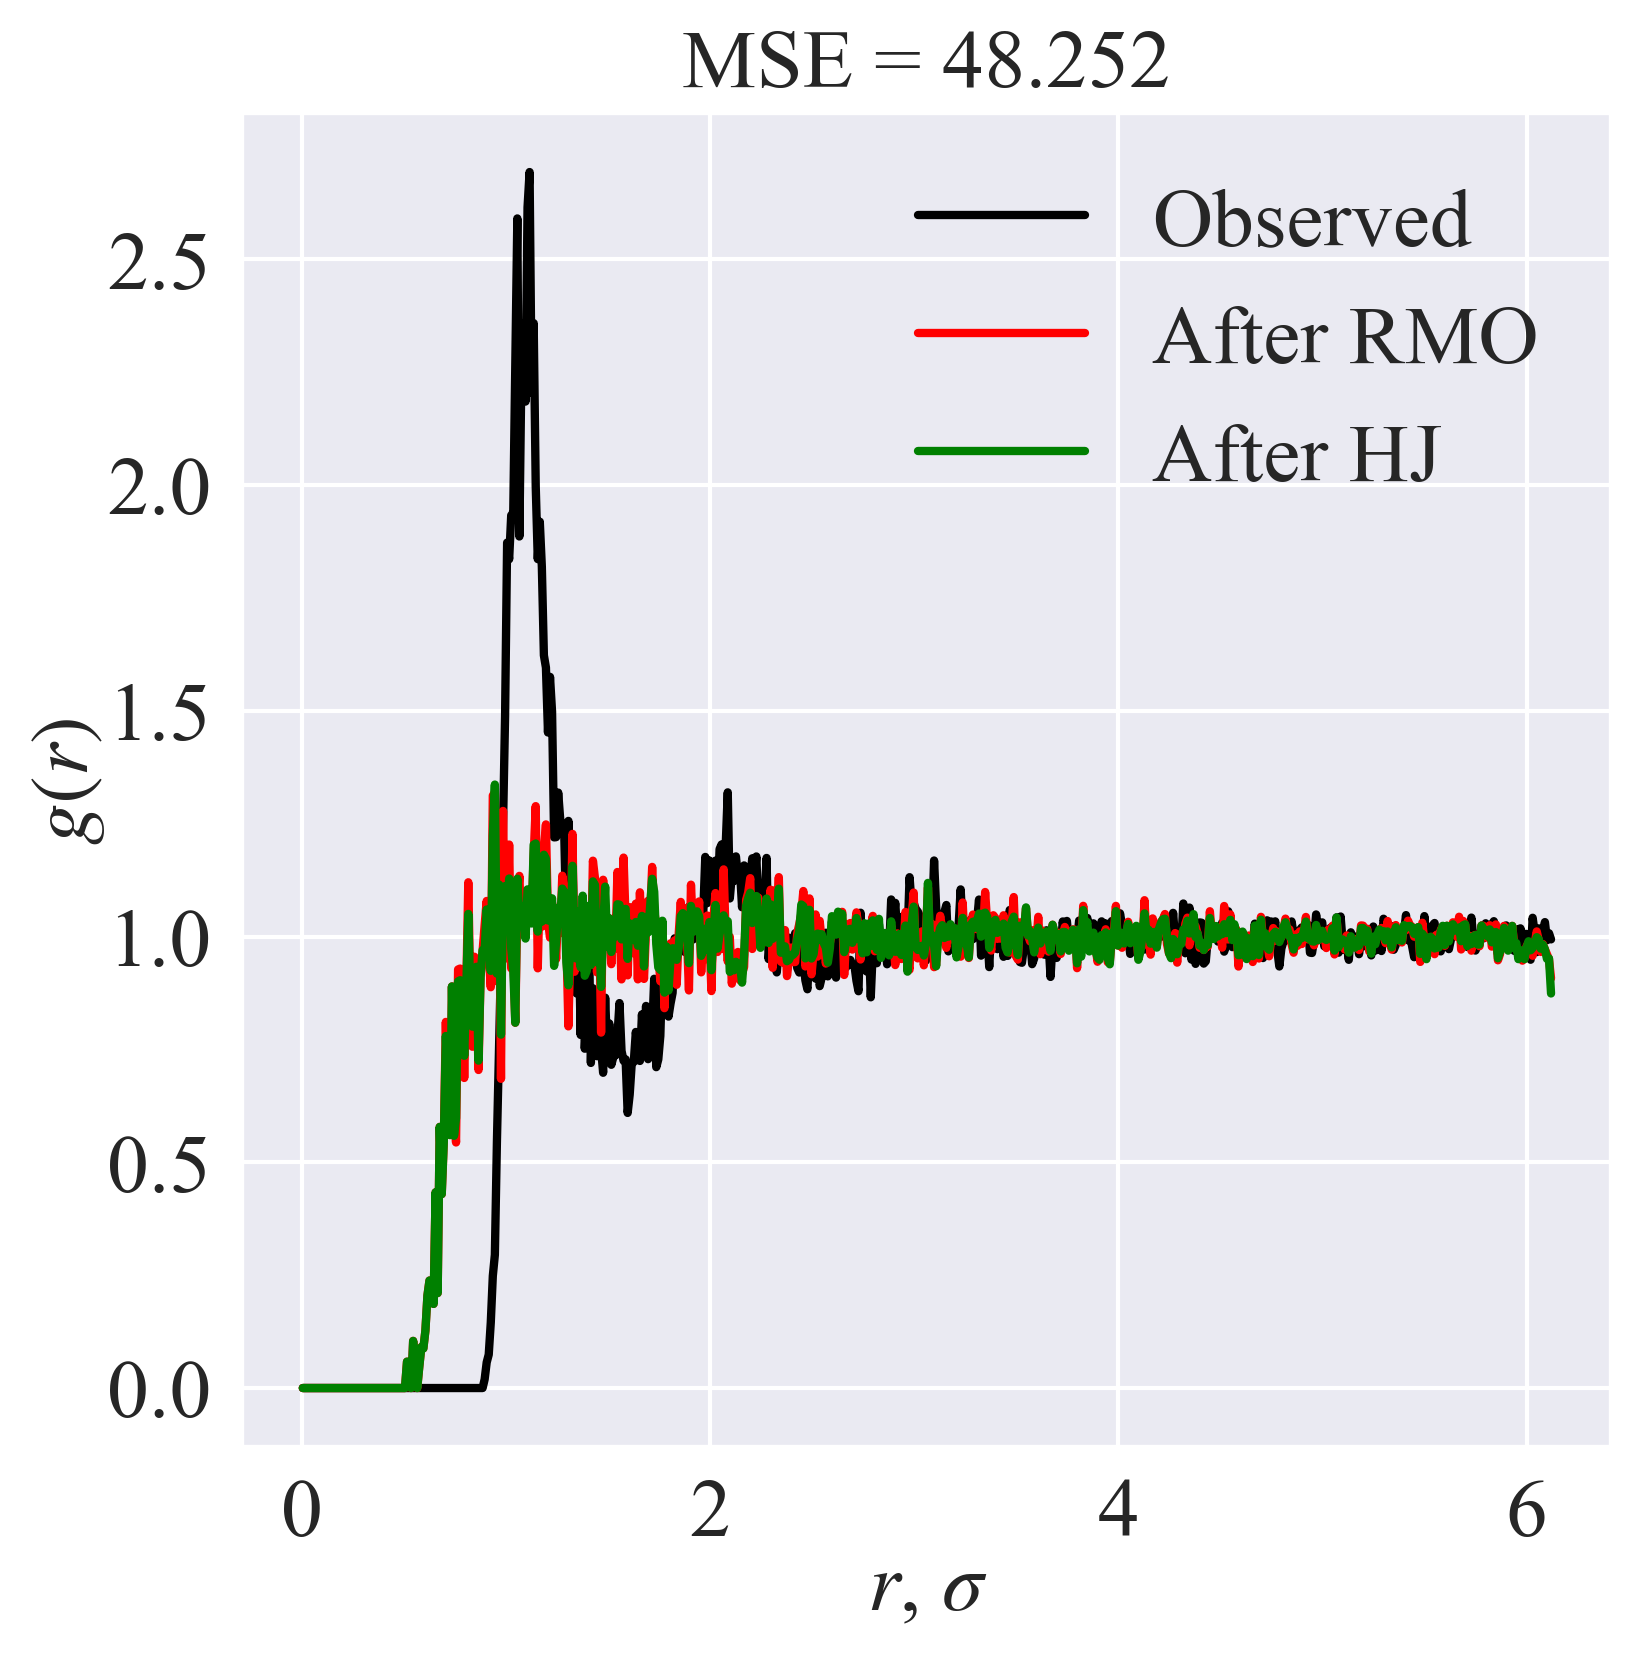

In [46]:
plotter = Plotter(
    path_to_plots=PATH_TO_PLOTS,
    labels=('radius', 'rdf'),
)
plotter.ax.plot(radii, obs_rdf, color='black', label='Observed')
plotter.ax.plot(radii, new_exp_rdf, color='red', label='After RMO')
plotter.ax.plot(radii, new_exp_rdf_hj, color='green', label='After HJ')
plotter.set_title(f'MSE = {mse(obs=obs_rdf, exp=new_exp_rdf_hj):.3f}')
plotter.get_legend()
plotter.save_plot('optimized_state_rmo_hj_random.png')
plt.show()

In [ ]:
cell_dimensions = np.ones(3) * 12.25
ovito_1 = OvitoProcessor(positions=some_positions, cell_dimensions=cell_dimensions)
ovito_2 = OvitoProcessor(positions=new_positions, cell_dimensions=cell_dimensions)

In [ ]:
indices_1 = get_unique_frame(ovito_1.get_voronoi_indices())
indices_2 = get_unique_frame(ovito_2.get_voronoi_indices())
for i in range(10):
    if i not in indices_1.columns:
        indices_1[i] = 0
    if i not in indices_2.columns:
        indices_2[i] = 0
merged_indices = indices_1.merge(
    right=indices_2, 
    on=list(range(10)), 
    how='outer',
).fillna(0).astype(int)
merged_indices['diff'] = merged_indices['counts_y'] - merged_indices['counts_x']
merged_indices

In [ ]:
volumes_1 = get_unique_frame(ovito_1.get_voronoi_volumes()).rename(columns={0: 'volume'})
volumes_2 = get_unique_frame(ovito_2.get_voronoi_volumes()).rename(columns={0: 'volume'})
merged_volumes = volumes_1.merge(
    right=volumes_2, 
    on='volume', 
    how='outer',
).fillna(0)
merged_volumes['diff'] = merged_volumes['counts_y'] - merged_volumes['counts_x']
merged_volumes

In [ ]:
coordinations_1 = get_unique_frame(ovito_1.get_voronoi_coordination()).rename(columns={0: 'coordination'})
coordinations_2 = get_unique_frame(ovito_2.get_voronoi_coordination()).rename(columns={0: 'coordination'})
merged_coordinations = coordinations_1.merge(
    right=coordinations_2, 
    on='coordination', 
    how='outer',
).fillna(0).astype(int)
merged_coordinations['diff'] = merged_coordinations['counts_y'] - merged_coordinations['counts_x']
merged_coordinations

In [ ]:
merged_indices = merged_indices[
    (merged_indices['counts_x'] > 1)
    & (merged_indices['counts_y'] > 1)
].reset_index(drop=True)
merged_indices

In [ ]:
merged_indices['diff'].describe()

In [ ]:
plt.bar(merged_coordinations['coordination'], merged_coordinations['counts_x'], alpha=0.5)
plt.bar(merged_coordinations['coordination'], merged_coordinations['counts_y'], alpha=0.5)
plt.show()

In [ ]:
hist, bins, _ = plt.hist(volumes_1['volume'], alpha=0.5)
plt.hist(volumes_2['volume'], alpha=0.5, bins=bins)
plt.show()

In [ ]:
radii, ovito_rdf_1, coordination_1 = ovito_1.get_rdf(is_coordination_returned=True)
radii, ovito_rdf_2, coordination_2 = ovito_2.get_rdf(is_coordination_returned=True)

In [ ]:
plt.plot(radii, ovito_rdf_1, label='1')
plt.plot(radii, ovito_rdf_2, label='2')
plt.legend()
plt.show()

In [ ]:
hist, bins, _ = plt.hist(coordination_1, alpha=0.5)
plt.hist(coordination_2, alpha=0.5, bins=bins)
plt.show()

In [ ]:
accuracies = np.array([1e-2, 1e-3, 1e-4, 1e-5])
times = np.array([291.500393, 547.916789, 981.426485, 1017.221477])
errors = np.array([0.1990364055106134, 0.13339311228418615, 0.0967833879874992, 0.09534158842519781])

plt.plot(accuracies, times / times.max(), label='Calculation time')
plt.plot(accuracies, errors / errors.max(), label='MSE after calculation')
plt.xscale('log')
plt.xlabel('Accuracy')
plt.legend()
plt.show()